In [1]:
import os, sys, socket, re, json, random
import numpy as np
import matplotlib.pyplot as plt

if 'SUMO_HOME' in os.environ:
    tools = os.path.join(os.environ['SUMO_HOME'], 'tools')
    sys.path.append(tools)
else:
    sys.exit("please declare environment variable 'SUMO_HOME'")

#sumoBinary = os.path.join(os.environ['SUMO_HOME'], 'bin/sumo-gui')
#sumoCmd = [sumoBinary, "-c", "longhighway.sumo.cfg", "--start"]

import traci
import sumolib
from sumolib import checkBinary
import sumolib.net
from sumolib.net import readNet
from sumolib.net import Net
from sumolib.net import NetReader
from sumolib.net import lane
from sumolib.net import edge
from sumolib.net import node 
from sumolib.net import connection
from sumolib.net import roundabout
from sumolib.net.edge import Edge

##################### Lead Traj ########################
dt = 0.0166666666666667
#dt = 0.04
duration = 2000
m2m = 1/2.2369
v0 = 30*m2m*np.ones(4300)
for i in range(230):
    v0 = np.append(v0, v0[-1]+1*dt*(0.04/dt))
v0 = np.append(v0, v0[-1]*np.ones(duration*2+500))
for i in range(230):
    v0 = np.append(v0, v0[-1]-2*dt*(0.04/dt))
v0 = np.append(v0, v0[-1]*np.ones(duration*2))
for i in range(350):
    v0 = np.append(v0, v0[-1]+1*dt*(0.04/dt))
v0 = np.append(v0, v0[-1]*np.ones(duration*2))
for i in range(120):
    v0 = np.append(v0, v0[-1]-1*dt*(0.04/dt))

v0 = np.append(v0, v0[-1]*np.ones(duration*2))
for i in range(230):
    v0 = np.append(v0, v0[-1]+1*dt*(0.04/dt))
v0 = np.append(v0, v0[-1]*np.ones(duration*2+500))
for i in range(230):
    v0 = np.append(v0, v0[-1]-2*dt*(0.04/dt))
v0 = np.append(v0, v0[-1]*np.ones(duration*2))
for i in range(350):
    v0 = np.append(v0, v0[-1]+1*dt*(0.04/dt))
v0 = np.append(v0, v0[-1]*np.ones(duration*2))
for i in range(120):
    v0 = np.append(v0, v0[-1]-1*dt*(0.04/dt))
    
v0 = np.append(v0, v0[-1]*np.ones(duration*2))
for i in range(230):
    v0 = np.append(v0, v0[-1]+1*dt*(0.04/dt))
v0 = np.append(v0, v0[-1]*np.ones(duration*2+500))
for i in range(230):
    v0 = np.append(v0, v0[-1]-2*dt*(0.04/dt))
v0 = np.append(v0, v0[-1]*np.ones(duration*2))
for i in range(350):
    v0 = np.append(v0, v0[-1]+1*dt*(0.04/dt))

v0 = np.append(v0, v0[-1]*np.ones(duration*3))

##################### Lead Traj ########################
dt = 1/60
duration = 2000
m2m = 1/2.2369
v18na = np.loadtxt('na_speed_18mph.txt')
a18na = np.diff(v18na)/0.1
a18na = np.append(0,a18na)
for i in range(len(a18na)):
    if a18na[i]>5:
        a18na[i] = 5
    elif a18na[i]<-6:
        a18na[i] = -6
        
#plt.plot(a18na)
v18new = np.zeros(a18na.shape)
v18new[0] = v18na[0]
for i in range(1,len(v18new)):
    v18new[i] = v18new[i-1] + 0.1*a18na[i]*1.3
v18new = v18new/m2m-13
for i in range(1,len(v18new)):
    if v18new[i]<0:
        v18new[i] = 0
v0 = v18new

x = np.linspace(0, v0.shape[0], v0.shape[0])
x1 = np.linspace(0, v0.shape[0], v0.shape[0]*6)
from scipy.interpolate import interp1d
vinterp = interp1d(x, v0)
v01 = vinterp(x1)

########################## Parameters of platoon ##########################
N_lane_0, N_lane_1, N_lane_2, N_behind = 5, 5, 2, 3

N_VEHICLES = N_lane_0 + N_lane_1 + N_lane_2

lead_v = v01
lead_a = np.diff(lead_v)/dt
lead_a = np.append(0, lead_a)

# used to randomly color the vehicles
random.seed(1)
step = 0

max_iter = len(lead_a)
#max_iter = 2
#print(max_iter)

position = np.zeros((max_iter+1, N_VEHICLES))
pos_ego = np.zeros((max_iter+1,))
speed = np.zeros((max_iter+1, N_VEHICLES))
accel = np.zeros((max_iter+1, N_VEHICLES))
light = np.zeros((max_iter+1, N_VEHICLES))

light_buffer = 25

def EIDM(spacing, v, v0, s0=3, a0=1.8, b0=2.8, T=1, sigma=4, Kf=1, Kg=0.6, *cv_arg):

    cv_arg = cv_arg[0]
    CAV_count = len(cv_arg)//2
    temp_v, temp_a = 0, 0
    alpha, beta = np.zeros((1,CAV_count)), np.zeros((1,CAV_count))
    if CAV_count > 0:
        for i in range(CAV_count):
            alpha[i] = 0.3/(0.3+np.exp(i))
            beta[i] = 0.3/(0.3+np.exp(i))
            temp_v += alpha[i]*cv_arg[2*i]
            temp_a += beta[i]*cv_arg[2*i+1]
        #s_star = s0 + v*T - v*alpha[0]*cv_arg[0]/(2*np.sqrt(a0*b0))
        s_star = s0 + v*T - v*cv_arg[0]/(2*np.sqrt(a0*b0))
    else:
        print('Error because no CAV speed and acceleration input!')
    a_free = a0*(1-(v/v0)**sigma)
    a_int = -a0*(s_star/spacing)**2
    acc = a_free + a_int
    
    return Kf*acc + Kg*(temp_v + temp_a)

def acc_linear(h, v, space, rel_v, rel_a, ks, kv, ka):
    return ks*(space-h*v) + kv*rel_v + ka*rel_a

s0=2.5
a0=5
b0=8
T=2.2
sigma=4
Kf=1
Kg=0

length = 5
spd = lead_v[0]
v0 = 33
dis = (s0+spd*T)/np.sqrt(1-(spd/v0)**sigma)

h = 2
ks, kv, ka = 2, 2, 1
#dis = spd*h
#dis = 45
#########################################################################

graph = sumolib.net.readNet('LLC.net.xml', withInternal=True) #internal edge are edges inside interseciton or connections 
vertex = graph.getNodes()
edge = graph.getEdges(withInternal=True)
#print('edge length:')
#print(len(edge))

sumoCmd = [sumolib.checkBinary('sumo-gui'), '-c', 'LLC_SUMO_no.sumo.cfg']
traci.start(sumoCmd)
step = 0

traci.route.add(routeID = 'route1', edges = ['-17.0.00'])
#traci.vehicle.add('ego', "route")
traci.vehicle.add('ego', "route1", departPos=str(200), departSpeed=str(spd), departLane = str(2), typeID="passenger")
traci.vehicle.setColor('ego', color=(255, 0, 0, 255))
traci.vehicle.setLaneChangeMode('ego', 256)

#UDP_IP = "192.168.0.11"
UDP_IP = "192.168.0.181"
UDP_PORT = 23333

'''
serverSock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
serverSock.bind((UDP_IP, UDP_PORT))

data, address = serverSock.recvfrom(1024*6)
data = data.decode('utf-8').split("$")[0]
y, x, z, vx, vy = data.split(";")
#x, y = '6448.97', '-6645.57'
X_offset, Y_offset = 0, 0      #10273, 1000.5  #882.504, 846.15
x, y, z = X_offset+float(x.replace("\x00", "")), Y_offset+float(y.replace("\x00", "")), float(z.replace("\x00", ""))*180/3.14159265
vx, vy = float(vx.replace("\x00", "")), float(vy.replace("\x00", ""))
eEdge = traci.vehicle.getRoadID('ego')
ePos = traci.vehicle.getPosition('ego')
traci.vehicle.moveToXY('ego', '', 0, x, y, angle=z, keepRoute=2)
'''

traci.simulationStep()
eLanePos = traci.vehicle.getLanePosition('ego')
#print(eLanePos)

def dis_ego(vID_tmp):
    posi = traci.vehicle.getPosition(vID_tmp)
    dis = ((ePos[0] - posi[0])**2 + (ePos[1] - posi[1])**2)**(1/2)
    return dis
    
while step<=max_iter:
    '''
    data, address = serverSock.recvfrom(1024*6)
    data = data.decode('utf-8').split("$")[0]
    y, x, z, vx, vy = data.split(";")
    #x, y = '6448.97', '-6645.57'
    X_offset, Y_offset = 0, 0      #10273, 1000.5  #882.504, 846.15
    x, y, z = X_offset+float(x.replace("\x00", "")), Y_offset+float(y.replace("\x00", "")), float(z.replace("\x00", ""))*180/3.14159265
    vx, vy = float(vx.replace("\x00", "")), float(vy.replace("\x00", ""))
    eEdge = traci.vehicle.getRoadID('ego')
    ePos = traci.vehicle.getPosition('ego')
    traci.vehicle.moveToXY('ego', '', 0, x, y, angle=z, keepRoute=2)
    traci.vehicle.setSpeed('ego', 0.0)
    eLanePos = traci.vehicle.getLanePosition('ego')
    #print(eLanePos)
    pos_ego[step] = eLanePos
    '''
    eLanePos = traci.vehicle.getLanePosition('ego')
    #print(eLanePos)
    if step==0:
        #eLanePos = 10
        for i in range(N_VEHICLES):
            if i < N_lane_0:
                position[0, i] = eLanePos + (N_lane_0-i)*dis
                speed[0, i] = spd
                accel[0, i] = 0
                
                vid = "%d" % i
                traci.vehicle.add(vid, "route1", departPos=str(position[0, i]), departSpeed=str(spd), departLane = str(0), typeID="passenger")
                traci.vehicle.setColor(vid, (random.uniform(0, 255), random.uniform(0, 255), random.uniform(0, 255), 255))
                traci.vehicle.setLaneChangeMode(vid, 256)
            elif i >= N_lane_0 and i < N_lane_0 + N_lane_1:
                position[0, i] = eLanePos + (N_lane_0+N_lane_1-i)*dis
                speed[0, i] = spd
                accel[0, i] = 0
                
                vid = "%d" % i
                traci.vehicle.add(vid, "route1", departPos=str(position[0, i]), departSpeed=str(spd), departLane = str(1), typeID="passenger")
                traci.vehicle.setColor(vid, (random.uniform(0, 255), random.uniform(0, 255), random.uniform(0, 255), 255))
                traci.vehicle.setLaneChangeMode(vid, 256)
            
            else:
                position[0, i] = eLanePos + (N_lane_0+N_lane_1+N_lane_2-i)*dis
                speed[0, i] = spd
                accel[0, i] = 0
                
                vid = "%d" % i
                traci.vehicle.add(vid, "route1", departPos=str(position[0, i]), departSpeed=str(spd), departLane = str(2), typeID="passenger")
                traci.vehicle.setColor(vid, (random.uniform(0, 255), random.uniform(0, 255), random.uniform(0, 255), 255))
                traci.vehicle.setLaneChangeMode(vid, 256)
            
            
            traci.gui.trackVehicle("View #0", "%d" % i)
            traci.gui.setZoom("View #0", 5000)
            
    elif step>=1:
        if True:
            #dt = 1
            space = position[step - 1, N_lane_0 + N_lane_1 + N_lane_2 - 1] - traci.vehicle.getLanePosition('ego')
            rel_v = speed[step - 1, N_lane_0 + N_lane_1 + N_lane_2 - 1] - traci.vehicle.getSpeed('ego')
            rel_acc = accel[step - 1, N_lane_0 + N_lane_1 + N_lane_2 - 1] - traci.vehicle.getAcceleration('ego')
            acceleration = EIDM(space, traci.vehicle.getSpeed('ego'), v0, s0, a0, b0, T, sigma, Kf, Kg, (rel_v,rel_acc))
            #acceleration = acc_linear(h, traci.vehicle.getSpeed('ego'), space, rel_v, rel_acc, ks, kv, ka)
            traci.vehicle.setSpeed('ego', traci.vehicle.getSpeed('ego') + acceleration*dt)
            
            for i in range(N_VEHICLES):
                if i == 0 or i == N_lane_0 or i == N_lane_0+N_lane_1:
                    #traci.vehicle.setSpeed("v.%d" % i, lead_v[step - 1//10])
                    #traci.vehicle.setSpeed("%d" % i, speed[step - 1,i] + lead_a[step - 1//1]*dt)
                    acceleration = lead_a[step]
                    Spd = speed[step - 1,i] + dt*acceleration
                    Pos = position[step - 1,i] + speed[step - 1,i]*dt
                    if i == 0:
                        traci.vehicle.moveTo("%d" % i, '-17.0.00_0', Pos)
                    elif i == N_lane_0:
                        traci.vehicle.moveTo("%d" % i, '-17.0.00_1', Pos)
                    elif i == N_lane_0 + N_lane_1:
                        traci.vehicle.moveTo("%d" % i, '-17.0.00_2', Pos) 
                    if lead_a[step - 1//1]<0:
                        traci.vehicle.setSignals("%d" % i, 3)
                else:
                    if i < N_lane_0:
                        #space = traci.vehicle.getLanePosition("v.%d" % (i-1)) - traci.vehicle.getLanePosition("v.%d" % i)
                        space = position[step - 1,i-1] - position[step - 1,i]
                        #v = traci.vehicle.getSpeed("v.%d" % i)
                        v = speed[step - 1,i]
                        #rel_v = traci.vehicle.getSpeed("v.%d" % (i-1)) - traci.vehicle.getSpeed("v.%d" % i)
                        rel_v = speed[step - 1,i-1] - speed[step - 1,i]
                        #rel_acc = traci.vehicle.getAcceleration("v.%d" % (i-1))- traci.vehicle.getAcceleration("v.%d" % i)
                        rel_acc = accel[step - 1,i-1] - accel[step - 1,i]
                        acceleration = EIDM(space, v, v0, s0, a0, b0, T, sigma, Kf, Kg, (rel_v,rel_acc))
                        #acceleration = acc_linear(h, v, space, rel_v, rel_acc, ks, kv, ka)
                        Spd = speed[step - 1,i] + dt*acceleration                
                        Pos = position[step - 1,i] + speed[step - 1,i]*dt #+ 0.5*acceleration*(dt**2)
                        traci.vehicle.moveTo("%d" % i, '-17.0.00_0', Pos)
                    elif i > N_lane_0 and i < N_lane_0 + N_lane_1:
                        space = position[step - 1,i-1] - position[step - 1,i]
                        v = speed[step - 1,i]
                        rel_v = speed[step - 1,i-1] - speed[step - 1,i]
                        rel_acc = accel[step - 1,i-1] - accel[step - 1,i]
                        acceleration = EIDM(space, v, v0, s0, a0, b0, T, sigma, Kf, Kg, (rel_v,rel_acc))
                        #acceleration = acc_linear(h, v, space, rel_v, rel_acc, ks, kv, ka)
                        Spd = speed[step - 1,i] + dt*acceleration    
                        Pos = position[step - 1,i] + speed[step - 1,i]*dt #+ 0.5*acceleration*(dt**2)
                        traci.vehicle.moveTo("%d" % i, '-17.0.00_1', Pos)
                    else:
                        space = position[step - 1,i-1] - position[step - 1,i]
                        v = speed[step - 1,i]
                        rel_v = speed[step - 1,i-1] - speed[step - 1,i]
                        rel_acc = accel[step - 1,i-1] - accel[step - 1,i]
                        acceleration = EIDM(space, v, v0, s0, a0, b0, T, sigma, Kf, Kg, (rel_v,rel_acc))
                        #acceleration = acc_linear(h, v, space, rel_v, rel_acc, ks, kv, ka)
                        Spd = speed[step - 1,i] + dt*acceleration    
                        Pos = position[step - 1,i] + speed[step - 1,i]*dt #+ 0.5*acceleration*(dt**2)
                        traci.vehicle.moveTo("%d" % i, '-17.0.00_2', Pos)            

                speed[step,i] = Spd
                position[step,i] = Pos
                accel[step,i] = acceleration                    
                #traci.vehicle.setSpeed("%d" % i, speed[step,i] + acceleration*dt)
                drag_decel = 0.12 + (0.25*(speed[step,i] + acceleration*dt)**2)/1750
                if step>=light_buffer and acceleration<-drag_decel:
                    if all(light[step-light_buffer:step,i]==3):
                        light[step,i] = 0
                    else:
                        light[step,i] = 3                            
                        traci.vehicle.setSignals("%d" % i, 3)
                print(acceleration)
    #print(traci.vehicle.getPosition('ego'))
    #print(traci.vehicle.getLanePosition('ego'))
                    
    '''
    Message=''
    Message =  "0" + "," + "0" + "," + Message
    for k in range(N_VEHICLES):
        vID = str(k)
        
        Position = traci.vehicle.getPosition(vID)
        sig = light[step,k]      #traci.vehicle.getSignals(vID)
        vel = traci.vehicle.getSpeed(vID)

        #if (Position[0]-x)**2 + (Position[1]-y)**2 > 90000:
        #        continue
        Message += str(vID)+","

        #xx = "{0:.3f}".format(position[0]-x) 
        xx = "{0:.3f}".format(Position[0]-X_offset) 

        #yy = "{0:.3f}".format(position[1]-y) 
        yy = "{0:.3f}".format(Position[1]-Y_offset) 

        Message += xx + "," + yy +","
        #print(vID,Position[0],Position[1])
        #print(vID,xx,yy)
        angle = traci.vehicle.getAngle(vID)
        angle = "{0:.3f}".format(angle) 
        Message += angle + ","
        
        Message +=  str(sig) + "," + str(vel) + ","

    Message = Message[:-1]
    #print(repr(Message))
    serverSock.sendto(Message.encode('utf-8'), (address[0], 23334))
    '''
    step += 1
    traci.simulationStep()

''' 
    for i in range(N_VEHICLES):
        position[step,i] = traci.vehicle.getLanePosition("%d" % i)
        #speed[step,i] = traci.vehicle.getSpeed("v.%d" % i)
        if step==0:
            speed[step,i] = spd
            accel[step,i] = 0
        else:
            speed[step,i] = (position[step,i]-position[step-1,i])/dt
            #accel[step,i] = traci.vehicle.getAcceleration("v.%d" % i)
            accel[step,i] = (speed[step,i]-speed[step-1,i])/dt
        #light[step,i] = traci.vehicle.getSignals("v.%d" % i)

    #plt.plot(speed[max(0,step-1000):step,N_lane_0 + N_lane_1])
    #print(traci.vehicle.getSpeed(str(N_lane_0 + N_lane_1)))
    if step >= max_iter:
        np.savetxt('./run_pos_trapz55mph_su.txt', position);
        np.savetxt('./run_vel_trapz55mph_su.txt', speed);
        np.savetxt('./run_accel_trapz55mph_su.txt', accel);
        break
''' 
traci.close()

0.0
[-1.77635684e-15]
[-1.77635684e-15]
[-1.77635684e-15]
[-1.77635684e-15]
0.0
[-1.77635684e-15]
[-1.77635684e-15]
[-1.77635684e-15]
[-1.77635684e-15]
0.0
[-1.77635684e-15]
0.0
[-1.65337829e-15]
[-1.77635684e-15]
[-1.77635684e-15]
[-1.77635684e-15]
0.0
[-1.65337829e-15]
[-1.77635684e-15]
[-1.77635684e-15]
[-1.77635684e-15]
0.0
[-1.65337829e-15]
0.0
[-1.66189219e-15]
[-1.76784294e-15]
[-1.77635684e-15]
[-1.77635684e-15]
0.0
[-1.66189219e-15]
[-1.76784294e-15]
[-1.77635684e-15]
[-1.77635684e-15]
0.0
[-1.66189219e-15]
0.0
[-1.66130276e-15]
[-1.76902179e-15]
[-1.77576742e-15]
[-1.77635684e-15]
0.0
[-1.66130276e-15]
[-1.76902179e-15]
[-1.77576742e-15]
[-1.77635684e-15]
0.0
[-1.66130276e-15]
0.0
[-1.66134357e-15]
[-1.76889937e-15]
[-1.77588983e-15]
[-1.77631603e-15]
0.0
[-1.66134357e-15]
[-1.76889937e-15]
[-1.77588983e-15]
[-1.77631603e-15]
0.0
[-1.66134357e-15]
0.0
[-1.66134075e-15]
[-1.76891067e-15]
[-1.77587288e-15]
[-1.77632733e-15]
0.0
[-1.66134075e-15]
[-1.76891067e-15]
[-1.77587288e-

[-1.66134093e-15]
[-1.76890977e-15]
[-1.77587465e-15]
[-1.77632562e-15]
0.0
[-1.66134093e-15]
0.0
[-1.66134093e-15]
[-1.76890977e-15]
[-1.77587465e-15]
[-1.77632562e-15]
0.0
[-1.66134093e-15]
[-1.76890977e-15]
[-1.77587465e-15]
[-1.77632562e-15]
0.0
[-1.66134093e-15]
0.0
[-1.66134093e-15]
[-1.76890977e-15]
[-1.77587465e-15]
[-1.77632562e-15]
0.0
[-1.66134093e-15]
[-1.76890977e-15]
[-1.77587465e-15]
[-1.77632562e-15]
0.0
[-1.66134093e-15]
0.0
[-1.66134093e-15]
[-1.76890977e-15]
[-1.77587465e-15]
[-1.77632562e-15]
0.0
[-1.66134093e-15]
[-1.76890977e-15]
[-1.77587465e-15]
[-1.77632562e-15]
0.0
[-1.66134093e-15]
0.0
[-1.66134093e-15]
[-1.76890977e-15]
[-1.77587465e-15]
[-1.77632562e-15]
0.0
[-1.66134093e-15]
[-1.76890977e-15]
[-1.77587465e-15]
[-1.77632562e-15]
0.0
[-1.66134093e-15]
0.0
[-1.66134093e-15]
[-1.76890977e-15]
[-1.77587465e-15]
[-1.77632562e-15]
0.0
[-1.66134093e-15]
[-1.76890977e-15]
[-1.77587465e-15]
[-1.77632562e-15]
0.0
[-1.66134093e-15]
0.0
[-1.66134093e-15]
[-1.76890977e-

[-1.76890977e-15]
[-1.77587465e-15]
[-1.77632562e-15]
0.0
[-1.66134093e-15]
0.0
[-1.66134093e-15]
[-1.76890977e-15]
[-1.77587465e-15]
[-1.77632562e-15]
0.0
[-1.66134093e-15]
[-1.76890977e-15]
[-1.77587465e-15]
[-1.77632562e-15]
0.0
[-1.66134093e-15]
0.0
[-1.66134093e-15]
[-1.76890977e-15]
[-1.77587465e-15]
[-1.77632562e-15]
0.0
[-1.66134093e-15]
[-1.76890977e-15]
[-1.77587465e-15]
[-1.77632562e-15]
0.0
[-1.66134093e-15]
0.0
[-1.66134093e-15]
[-1.76890977e-15]
[-1.77587465e-15]
[-1.77632562e-15]
0.0
[-1.66134093e-15]
[-1.76890977e-15]
[-1.77587465e-15]
[-1.77632562e-15]
0.0
[-1.66134093e-15]
0.0
[-1.66134093e-15]
[-1.76890977e-15]
[-1.77587465e-15]
[-1.77632562e-15]
0.0
[-1.66134093e-15]
[-1.76890977e-15]
[-1.77587465e-15]
[-1.77632562e-15]
0.0
[-1.66134093e-15]
0.0
[-1.66134093e-15]
[-1.76890977e-15]
[-1.77587465e-15]
[-1.77632562e-15]
0.0
[-1.66134093e-15]
[-1.76890977e-15]
[-1.77587465e-15]
[-1.77632562e-15]
0.0
[-1.66134093e-15]
0.0
[-1.66134093e-15]
[-1.76890977e-15]
[-1.77587465e-

0.0
[-1.19999933e-14]
[-5.39039395e-15]
[-2.01035924e-15]
[-1.79150807e-15]
0.0
[-1.19999933e-14]
[-5.39039395e-15]
[-2.01035924e-15]
[-1.79150807e-15]
0.0
[-1.66134093e-15]
0.0
[-1.19999933e-14]
[-5.39039395e-15]
[-2.01035924e-15]
[-1.79150807e-15]
0.0
[-1.19999933e-14]
[-5.39039395e-15]
[-2.01035924e-15]
[-1.79150807e-15]
0.0
[-1.66134093e-15]
0.0
[-1.19999933e-14]
[-5.39039395e-15]
[-2.01035924e-15]
[-1.79150807e-15]
0.0
[-1.19999933e-14]
[-5.39039395e-15]
[-2.01035924e-15]
[-1.79150807e-15]
0.0
[-1.66134093e-15]
0.0
[-1.19999933e-14]
[-5.39039395e-15]
[-2.01035924e-15]
[-1.79150807e-15]
0.0
[-1.19999933e-14]
[-5.39039395e-15]
[-2.01035924e-15]
[-1.79150807e-15]
0.0
[-1.66134093e-15]
0.0
[-1.19999933e-14]
[-5.39039395e-15]
[-2.01035924e-15]
[-1.79150807e-15]
0.0
[-1.19999933e-14]
[-5.39039395e-15]
[-2.01035924e-15]
[-1.79150807e-15]
0.0
[-1.66134093e-15]
0.0
[-1.19999933e-14]
[-5.39039395e-15]
[-2.01035924e-15]
[-1.79150807e-15]
0.0
[-1.19999933e-14]
[-5.39039395e-15]
[-2.01035924e-

0.0
[-1.19999933e-14]
[-5.39039395e-15]
[-2.01035924e-15]
[-1.79150807e-15]
0.0
[-1.66134093e-15]
0.0
[-1.19999933e-14]
[-5.39039395e-15]
[-2.01035924e-15]
[-1.79150807e-15]
0.0
[-1.19999933e-14]
[-5.39039395e-15]
[-2.01035924e-15]
[-1.79150807e-15]
0.0
[-1.66134093e-15]
0.0
[-1.19999933e-14]
[-5.39039395e-15]
[-2.01035924e-15]
[-1.79150807e-15]
0.0
[-1.19999933e-14]
[-5.39039395e-15]
[-2.01035924e-15]
[-1.79150807e-15]
0.0
[-1.66134093e-15]
0.0
[-1.19999933e-14]
[-5.39039395e-15]
[-2.01035924e-15]
[-1.79150807e-15]
0.0
[-1.19999933e-14]
[-5.39039395e-15]
[-2.01035924e-15]
[-1.79150807e-15]
0.0
[-1.66134093e-15]
0.0
[-1.19999933e-14]
[-5.39039395e-15]
[-2.01035924e-15]
[-1.79150807e-15]
0.0
[-1.19999933e-14]
[-5.39039395e-15]
[-2.01035924e-15]
[-1.79150807e-15]
0.0
[-1.66134093e-15]
0.0
[-1.19999933e-14]
[-5.39039395e-15]
[-2.01035924e-15]
[-1.79150807e-15]
0.0
[-1.19999933e-14]
[-5.39039395e-15]
[-2.01035924e-15]
[-1.79150807e-15]
0.0
[-1.66134093e-15]
0.0
[-1.19999933e-14]
[-5.390393

[-5.39039395e-15]
[-2.01035924e-15]
[-1.79150807e-15]
0.0
[-1.19999933e-14]
[-5.39039395e-15]
[-2.01035924e-15]
[-1.79150807e-15]
0.0
[-1.66134093e-15]
0.0
[-1.19999933e-14]
[-5.39039395e-15]
[-2.01035924e-15]
[-1.79150807e-15]
0.0
[-1.19999933e-14]
[-5.39039395e-15]
[-2.01035924e-15]
[-1.79150807e-15]
0.0
[-1.66134093e-15]
0.0
[-1.19999933e-14]
[-5.39039395e-15]
[-2.01035924e-15]
[-1.79150807e-15]
0.0
[-1.19999933e-14]
[-5.39039395e-15]
[-2.01035924e-15]
[-1.79150807e-15]
0.0
[-1.66134093e-15]
0.0
[-1.19999933e-14]
[-5.39039395e-15]
[-2.01035924e-15]
[-1.79150807e-15]
0.0
[-1.19999933e-14]
[-5.39039395e-15]
[-2.01035924e-15]
[-1.79150807e-15]
0.0
[-1.66134093e-15]
0.0
[-1.19999933e-14]
[-5.39039395e-15]
[-2.01035924e-15]
[-1.79150807e-15]
0.0
[-1.19999933e-14]
[-5.39039395e-15]
[-2.01035924e-15]
[-1.79150807e-15]
0.0
[-1.66134093e-15]
0.0
[-1.19999933e-14]
[-5.39039395e-15]
[-2.01035924e-15]
[-1.79150807e-15]
0.0
[-1.19999933e-14]
[-5.39039395e-15]
[-2.01035924e-15]
[-1.79150807e-15]


[-2.01035924e-15]
[-1.79150807e-15]
0.0
[-1.66134093e-15]
0.0
[-1.19999933e-14]
[-5.39039395e-15]
[-2.01035924e-15]
[-1.79150807e-15]
0.0
[-1.19999933e-14]
[-5.39039395e-15]
[-2.01035924e-15]
[-1.79150807e-15]
0.0
[-1.66134093e-15]
0.0
[-1.19999933e-14]
[-5.39039395e-15]
[-2.01035924e-15]
[-1.79150807e-15]
0.0
[-1.19999933e-14]
[-5.39039395e-15]
[-2.01035924e-15]
[-1.79150807e-15]
0.0
[-1.66134093e-15]
0.0
[-1.19999933e-14]
[-5.39039395e-15]
[-2.01035924e-15]
[-1.79150807e-15]
0.0
[-1.19999933e-14]
[-5.39039395e-15]
[-2.01035924e-15]
[-1.79150807e-15]
0.0
[-1.66134093e-15]
0.0
[-1.19999933e-14]
[-5.39039395e-15]
[-2.01035924e-15]
[-1.79150807e-15]
0.0
[-1.19999933e-14]
[-5.39039395e-15]
[-2.01035924e-15]
[-1.79150807e-15]
0.0
[-1.66134093e-15]
0.0
[-1.19999933e-14]
[-5.39039395e-15]
[-2.01035924e-15]
[-1.79150807e-15]
0.0
[-1.19999933e-14]
[-5.39039395e-15]
[-2.01035924e-15]
[-1.79150807e-15]
0.0
[-1.66134093e-15]
0.0
[-1.19999933e-14]
[-5.39039395e-15]
[-2.01035924e-15]
[-1.79150807e-

0.0
[-1.66134093e-15]
0.0
[-1.19999933e-14]
[-5.39039395e-15]
[-2.01035924e-15]
[-1.79150807e-15]
0.0
[-1.19999933e-14]
[-5.39039395e-15]
[-2.01035924e-15]
[-1.79150807e-15]
0.0
[-1.66134093e-15]
0.0
[-1.19999933e-14]
[-5.39039395e-15]
[-2.01035924e-15]
[-1.79150807e-15]
0.0
[-1.19999933e-14]
[-5.39039395e-15]
[-2.01035924e-15]
[-1.79150807e-15]
0.0
[-1.66134093e-15]
0.0
[-1.19999933e-14]
[-5.39039395e-15]
[-2.01035924e-15]
[-1.79150807e-15]
0.0
[-1.19999933e-14]
[-5.39039395e-15]
[-2.01035924e-15]
[-1.79150807e-15]
0.0
[-1.66134093e-15]
0.0
[-1.19999933e-14]
[-5.39039395e-15]
[-2.01035924e-15]
[-1.79150807e-15]
0.0
[-1.19999933e-14]
[-5.39039395e-15]
[-2.01035924e-15]
[-1.79150807e-15]
0.0
[-1.66134093e-15]
0.0
[-1.19999933e-14]
[-5.39039395e-15]
[-2.01035924e-15]
[-1.79150807e-15]
0.0
[-1.19999933e-14]
[-5.39039395e-15]
[-2.01035924e-15]
[-1.79150807e-15]
0.0
[-1.66134093e-15]
0.0
[-1.19999933e-14]
[-5.39039395e-15]
[-2.01035924e-15]
[-1.79150807e-15]
0.0
[-1.19999933e-14]
[-5.390393

0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[-5.40312533e-15]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[-5.40312533e-15]
0.0
[-1.66134093e-15]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[-5.40312533e-15]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[-5.40312533e-15]
0.0
[-1.66134093e-15]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[-5.40312533e-15]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[-5.40312533e-15]
0.0
[-1.66134093e-15]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[-5.40312533e-15]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[-5.40312533e-15]
0.0
[-1.66134093e-15]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[-5.40312533e-15]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[-5.40312533e-15]
0.0
[-1.66134093e-15]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[-5.40312533e-15]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[-5.4031

[-5.40312533e-15]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[-5.40312533e-15]
0.0
[-1.66134093e-15]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[-5.40312533e-15]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[-5.40312533e-15]
0.0
[-1.66134093e-15]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[-5.40312533e-15]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[-5.40312533e-15]
0.0
[-1.66134093e-15]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[-5.40312533e-15]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[-5.40312533e-15]
0.0
[-1.66134093e-15]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[-5.40312533e-15]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[-5.40312533e-15]
0.0
[-1.66134093e-15]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[-5.40312533e-15]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[-5.40312533e-15]
0.0
[-1.66134093e-15]
0.0
[-1.19999933e-14]
[1.

[1.26543244e-14]
[-1.26407117e-14]
[-5.40312533e-15]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[-5.40312533e-15]
0.0
[-1.66134093e-15]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[-5.40312533e-15]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[-5.40312533e-15]
0.0
[-1.66134093e-15]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[-5.40312533e-15]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[-5.40312533e-15]
0.0
[-1.66134093e-15]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[-5.40312533e-15]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[-5.40312533e-15]
0.0
[-1.66134093e-15]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[-5.40312533e-15]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[-5.40312533e-15]
0.0
[-1.66134093e-15]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[-5.40312533e-15]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[-5.40312533e-15]
0.0
[-1.6613

[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[-5.40312533e-15]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[-5.40312533e-15]
0.0
[-1.66134093e-15]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[-5.40312533e-15]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[-5.40312533e-15]
0.0
[-1.66134093e-15]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[-5.40312533e-15]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[-5.40312533e-15]
0.0
[-1.66134093e-15]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[-5.40312533e-15]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[-5.40312533e-15]
0.0
[-1.66134093e-15]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[-5.40312533e-15]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[-5.40312533e-15]
0.0
[-1.66134093e-15]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[-5.40312533e-15]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[-5.40312533

[1.26543244e-14]
[-1.26407117e-14]
[-5.40312533e-15]
0.0
[-1.66134093e-15]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[-5.40312533e-15]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[-5.40312533e-15]
0.0
[-1.66134093e-15]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[-5.40312533e-15]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[-5.40312533e-15]
0.0
[-1.66134093e-15]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[-5.40312533e-15]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[-5.40312533e-15]
0.0
[-1.66134093e-15]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[-5.40312533e-15]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[-5.40312533e-15]
0.0
[-1.66134093e-15]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[-5.40312533e-15]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[-5.40312533e-15]
0.0
[-1.66134093e-15]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[-5.4031

0.0
[1.1284394e-14]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[1.26128391e-14]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[1.26128391e-14]
0.0
[1.12843349e-14]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[1.26128391e-14]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[1.26128391e-14]
0.0
[1.1284339e-14]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[1.26128391e-14]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[1.26128391e-14]
0.0
[1.12843388e-14]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[1.26128391e-14]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[1.26128391e-14]
0.0
[1.12843388e-14]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[1.26128391e-14]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[1.26128391e-14]
0.0
[1.12843388e-14]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[1.26128391e-14]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[1.26

[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[1.26128391e-14]
0.0
[1.12843388e-14]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[1.26128391e-14]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[1.26128391e-14]
0.0
[1.12843388e-14]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[1.26128391e-14]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[1.26128391e-14]
0.0
[1.12843388e-14]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[1.26128391e-14]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[1.26128391e-14]
0.0
[1.12843388e-14]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[1.26128391e-14]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[1.26128391e-14]
0.0
[1.12843388e-14]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[1.26128391e-14]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[1.26128391e-14]
0.0
[1.12843388e-14]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[1.2612

0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[1.26128391e-14]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[1.26128391e-14]
0.0
[1.12843388e-14]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[1.26128391e-14]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[1.26128391e-14]
0.0
[1.12843388e-14]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[1.26128391e-14]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[1.26128391e-14]
0.0
[1.12843388e-14]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[1.26128391e-14]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[1.26128391e-14]
0.0
[1.12843388e-14]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[1.26128391e-14]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[1.26128391e-14]
0.0
[1.12843388e-14]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[1.26128391e-14]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[1.26128391e-14]
0.0
[1.

[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[1.26128391e-14]
0.0
[1.12843388e-14]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[1.26128391e-14]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[1.26128391e-14]
0.0
[1.12843388e-14]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[1.26128391e-14]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[1.26128391e-14]
0.0
[1.12843388e-14]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[1.26128391e-14]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[1.26128391e-14]
0.0
[1.12843388e-14]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[1.26128391e-14]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[1.26128391e-14]
0.0
[1.12843388e-14]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[1.26128391e-14]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[1.26128391e-14]
0.0
[1.12843388e-14]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[1.2612

[-1.26407117e-14]
[1.26128391e-14]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[1.26128391e-14]
0.0
[1.12843388e-14]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[1.26128391e-14]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[1.26128391e-14]
0.0
[1.12843388e-14]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[1.26128391e-14]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[1.26128391e-14]
0.0
[1.12843388e-14]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[1.26128391e-14]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[1.26128391e-14]
0.0
[1.12843388e-14]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[1.26128391e-14]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[1.26128391e-14]
0.0
[1.12843388e-14]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[1.26128391e-14]
0.0
[-1.19999933e-14]
[1.26543244e-14]
[-1.26407117e-14]
[1.26128391e-14]
0.0
[1.12843388e-14]
0.0
[-1.19999933e-14]
[1.

[-0.82933975]
-4.524186887838833
[-0.85108829]
[-0.11864243]
[-0.01421073]
[-0.00154404]
-4.524186887838833
[-0.85108829]
[-0.11864243]
[-0.01421073]
[-0.00154404]
-4.524186887838833
[-0.85108829]
-3.113615863685779
[-0.87297367]
[-0.12366667]
[-0.01500534]
[-0.00164901]
-3.113615863685779
[-0.87297367]
[-0.12366667]
[-0.01500534]
[-0.00164901]
-3.113615863685779
[-0.87297367]
-2.829070592459546
[-0.78942234]
[-0.1288053]
[-0.01582976]
[-0.00175901]
-2.829070592459546
[-0.78942234]
[-0.1288053]
[-0.01582976]
[-0.00175901]
-2.829070592459546
[-0.78942234]
-2.829070592459546
[-0.7947226]
[-0.12616254]
[-0.01668394]
[-0.00187435]
-2.829070592459546
[-0.7947226]
[-0.12616254]
[-0.01668394]
[-0.00187435]
-2.829070592459546
[-0.7947226]
-2.8290705924600257
[-0.81408188]
[-0.13055601]
[-0.01697792]
[-0.00199515]
-2.8290705924600257
[-0.81408188]
[-0.13055601]
[-0.01697792]
[-0.00199515]
-2.8290705924600257
[-0.81408188]
-2.829070592459546
[-0.83223877]
[-0.13554485]
[-0.01784136]
[-0.00207742

0.17736208236387885
[-0.38863291]
[-0.26718778]
[-0.08005581]
[-0.01732369]
0.17736208236387885
[-0.38863291]
0.17736208236389217
[-0.38249161]
[-0.26882446]
[-0.08134206]
[-0.01776022]
0.17736208236389217
[-0.38249161]
[-0.26882446]
[-0.08134206]
[-0.01776022]
0.17736208236389217
[-0.38249161]
0.17736208236387885
[-0.37543753]
[-0.26993978]
[-0.08267053]
[-0.01820266]
0.17736208236387885
[-0.37543753]
[-0.26993978]
[-0.08267053]
[-0.01820266]
0.17736208236387885
[-0.37543753]
0.17736208236386553
[-0.36862806]
[-0.27097377]
[-0.08396251]
[-0.01865407]
0.17736208236386553
[-0.36862806]
[-0.27097377]
[-0.08396251]
[-0.01865407]
0.17736208236386553
[-0.36862806]
0.1773620823639055
[-0.36197193]
[-0.27197874]
[-0.08525504]
[-0.01910843]
0.1773620823639055
[-0.36197193]
[-0.27197874]
[-0.08525504]
[-0.01910843]
0.1773620823639055
[-0.36197193]
0.11513258264032711
[-0.35546949]
[-0.27294445]
[-0.08654892]
[-0.01956885]
0.11513258264032711
[-0.35546949]
[-0.27294445]
[-0.08654892]
[-0.0195688

[-0.17902512]
0.0
[-0.17729897]
[-0.28014159]
[-0.15436582]
[-0.05410045]
0.0
[-0.17729897]
[-0.28014159]
[-0.15436582]
[-0.05410045]
0.0
[-0.17729897]
0.0
[-0.17559925]
[-0.27960861]
[-0.15534673]
[-0.0548165]
0.0
[-0.17559925]
[-0.27960861]
[-0.15534673]
[-0.0548165]
0.0
[-0.17559925]
0.0
[-0.17392519]
[-0.2790613]
[-0.15631805]
[-0.05553494]
0.0
[-0.17392519]
[-0.2790613]
[-0.15631805]
[-0.05553494]
0.0
[-0.17392519]
-0.00236974954019864
[-0.17227603]
[-0.27850001]
[-0.15727969]
[-0.05625566]
-0.00236974954019864
[-0.17227603]
[-0.27850001]
[-0.15727969]
[-0.05625566]
-0.00236974954019864
[-0.17227603]
-0.002907575120696393
[-0.17082713]
[-0.2779251]
[-0.1582316]
[-0.05697861]
-0.002907575120696393
[-0.17082713]
[-0.2779251]
[-0.1582316]
[-0.05697861]
-0.002907575120696393
[-0.17082713]
-0.002907575120696393
[-0.16925584]
[-0.27735009]
[-0.15917371]
[-0.05770369]
-0.002907575120696393
[-0.16925584]
[-0.27735009]
[-0.15917371]
[-0.05770369]
-0.002907575120696393
[-0.16925584]
-0.0029

0.07268937801796937
[-0.09989709]
0.07268937801796937
[-0.09853657]
[-0.23289614]
[-0.19466319]
[-0.09785235]
0.07268937801796937
[-0.09853657]
[-0.23289614]
[-0.19466319]
[-0.09785235]
0.07268937801796937
[-0.09853657]
0.07268937801796937
[-0.09747393]
[-0.23192493]
[-0.19502524]
[-0.09857575]
0.07268937801796937
[-0.09747393]
[-0.23192493]
[-0.19502524]
[-0.09857575]
0.07268937801796937
[-0.09747393]
0.07268937801796937
[-0.09638274]
[-0.23096396]
[-0.19538611]
[-0.09929641]
0.07268937801796937
[-0.09638274]
[-0.23096396]
[-0.19538611]
[-0.09929641]
0.07268937801796937
[-0.09638274]
0.07268937801796937
[-0.0952878]
[-0.22999678]
[-0.19573728]
[-0.10001566]
0.07268937801796937
[-0.0952878]
[-0.22999678]
[-0.19573728]
[-0.10001566]
0.07268937801796937
[-0.0952878]
0.10788022976836231
[-0.09418806]
[-0.22902651]
[-0.1960782]
[-0.10073274]
0.10788022976836231
[-0.09418806]
[-0.22902651]
[-0.1960782]
[-0.10073274]
0.10788022976836231
[-0.09418806]
0.11630300482877498
[-0.09047443]
[-0.228

-1.4305136914499128
[-0.21143116]
[-0.19141387]
[-0.20245334]
[-0.13492201]
-1.4305136914499128
[-0.21143116]
[-0.19141387]
[-0.20245334]
[-0.13492201]
-1.4305136914499128
[-0.21143116]
-1.4363421096351692
[-0.21839023]
[-0.19140196]
[-0.20244112]
[-0.13545726]
-1.4363421096351692
[-0.21839023]
[-0.19140196]
[-0.20244112]
[-0.13545726]
-1.4363421096351692
[-0.21839023]
-1.4363421096354223
[-0.22412981]
[-0.19156292]
[-0.20242891]
[-0.13598883]
-1.4363421096354223
[-0.22412981]
[-0.19156292]
[-0.20242891]
[-0.13598883]
-1.4363421096354223
[-0.22412981]
-1.4363421096351692
[-0.22971867]
[-0.19165769]
[-0.20242645]
[-0.13651677]
-1.4363421096351692
[-0.22971867]
[-0.19165769]
[-0.20242645]
[-0.13651677]
-1.4363421096351692
[-0.22971867]
-1.4363421096351825
[-0.23549445]
[-0.19178201]
[-0.20241568]
[-0.13704181]
-1.4363421096351825
[-0.23549445]
[-0.19178201]
[-0.20241568]
[-0.13704181]
-1.4363421096351825
[-0.23549445]
-1.436342109635409
[-0.24142048]
[-0.19195406]
[-0.20240511]
[-0.13756

[-0.32470093]
[-0.21552301]
[-0.20320277]
[-0.15859741]
-0.046521201931488676
[-0.32470093]
-0.03270074300536496
[-0.32443153]
[-0.21620988]
[-0.20328572]
[-0.15896487]
-0.03270074300536496
[-0.32443153]
[-0.21620988]
[-0.20328572]
[-0.15896487]
-0.03270074300536496
[-0.32443153]
-0.02907575120722372
[-0.3230325]
[-0.21689197]
[-0.20337185]
[-0.15932995]
-0.02907575120722372
[-0.3230325]
[-0.21689197]
[-0.20337185]
[-0.15932995]
-0.02907575120722372
[-0.3230325]
-0.02907575120721706
[-0.32235887]
[-0.21749328]
[-0.20346109]
[-0.15969271]
-0.02907575120721706
[-0.32235887]
[-0.21749328]
[-0.20346109]
[-0.15969271]
-0.02907575120721706
[-0.32235887]
-0.02907575120721706
[-0.32179048]
[-0.21815522]
[-0.20354781]
[-0.16005319]
-0.02907575120721706
[-0.32179048]
[-0.21815522]
[-0.20354781]
[-0.16005319]
-0.02907575120721706
[-0.32179048]
-0.02907575120721706
[-0.32111138]
[-0.21882143]
[-0.20364283]
[-0.160411]
-0.02907575120721706
[-0.32111138]
[-0.21882143]
[-0.20364283]
[-0.160411]
-0.02

[-0.13656967]
1.1746603487702756
[-0.12711782]
[-0.2299883]
[-0.21106774]
[-0.17661361]
1.1746603487702756
[-0.12711782]
[-0.2299883]
[-0.21106774]
[-0.17661361]
1.1746603487702756
[-0.12711782]
1.1746603487706686
[-0.12304942]
[-0.22937797]
[-0.21105699]
[-0.17688708]
1.1746603487706686
[-0.12304942]
[-0.22937797]
[-0.21105699]
[-0.17688708]
1.1746603487706686
[-0.12304942]
1.1746603487706753
[-0.11820909]
[-0.22899949]
[-0.21117683]
[-0.1771482]
1.1746603487706753
[-0.11820909]
[-0.22899949]
[-0.21117683]
[-0.1771482]
1.1746603487706753
[-0.11820909]
1.174660348770269
[-0.11308381]
[-0.22850562]
[-0.21130213]
[-0.17741842]
1.174660348770269
[-0.11308381]
[-0.22850562]
[-0.21130213]
[-0.17741842]
1.174660348770269
[-0.11308381]
1.5713311179371692
[-0.10766388]
[-0.22795812]
[-0.21141641]
[-0.1776871]
1.5713311179371692
[-0.10766388]
[-0.22795812]
[-0.21141641]
[-0.1776871]
1.5713311179371692
[-0.10766388]
1.6805784197759177
[-0.07276805]
[-0.22735193]
[-0.21152518]
[-0.17795381]
1.680

[-0.10278201]
[-0.19654856]
[-0.18937222]
-0.5582544231781439
[0.2056057]
[-0.10278201]
[-0.19654856]
[-0.18937222]
-0.5582544231781439
[0.2056057]
-0.5582544231779707
[0.20423395]
[-0.10048923]
[-0.19593117]
[-0.189445]
-0.5582544231779707
[0.20423395]
[-0.10048923]
[-0.19593117]
[-0.189445]
-0.5582544231779707
[0.20423395]
-0.5582544231781439
[0.2026156]
[-0.09824656]
[-0.1952987]
[-0.1895095]
-0.5582544231781439
[0.2026156]
[-0.09824656]
[-0.1952987]
[-0.1895095]
-0.5582544231781439
[0.2026156]
-0.6100884889056424
[0.20075599]
[-0.09603146]
[-0.19465791]
[-0.1895692]
-0.6100884889056424
[0.20075599]
[-0.09603146]
[-0.19465791]
[-0.1895692]
-0.6100884889056424
[0.20075599]
-0.6251286509546672
[0.19485801]
[-0.09384622]
[-0.19400673]
[-0.18962428]
-0.6251286509546672
[0.19485801]
[-0.09384622]
[-0.19400673]
[-0.18962428]
-0.6251286509546672
[0.19485801]
-0.6251286509546805
[0.19172571]
[-0.09197245]
[-0.19334558]
[-0.18967453]
-0.6251286509546805
[0.19172571]
[-0.09197245]
[-0.1933455

[0.05045781]
[-0.13791618]
[-0.18317366]
4.704456545324067
[0.64658738]
[0.05045781]
[-0.13791618]
[-0.18317366]
4.704456545324067
[0.64658738]
4.965362131472748
[0.66434295]
[0.05440091]
[-0.13654822]
[-0.18286778]
4.965362131472748
[0.66434295]
[0.05440091]
[-0.13654822]
[-0.18286778]
4.965362131472748
[0.66434295]
5.044642834448236
[0.70203734]
[0.05848604]
[-0.13515776]
[-0.18255268]
5.044642834448236
[0.70203734]
[0.05848604]
[-0.13515776]
[-0.18255268]
5.044642834448236
[0.70203734]
5.044642834446504
[0.72578808]
[0.06413137]
[-0.13374271]
[-0.18222938]
5.044642834446504
[0.72578808]
[0.06413137]
[-0.13374271]
[-0.18222938]
5.044642834446504
[0.72578808]
5.044642834448236
[0.74549197]
[0.06874103]
[-0.13219774]
[-0.18189758]
5.044642834448236
[0.74549197]
[0.06874103]
[-0.13219774]
[-0.18189758]
5.044642834448236
[0.74549197]
5.044642834448236
[0.76616452]
[0.07323848]
[-0.13072124]
[-0.18154939]
5.044642834448236
[0.76616452]
[0.07323848]
[-0.13072124]
[-0.18154939]
5.0446428344

[0.57127454]
[0.32953224]
[-0.01027616]
[-0.14430106]
-3.369879564914031
[0.57127454]
-3.369879564912912
[0.55488665]
[0.33185759]
[-0.007867]
[-0.14335961]
-3.369879564912912
[0.55488665]
[0.33185759]
[-0.007867]
[-0.14335961]
-3.369879564912912
[0.55488665]
-3.369879564914031
[0.53809832]
[0.33400928]
[-0.00544992]
[-0.1424031]
-3.369879564914031
[0.53809832]
[0.33400928]
[-0.00544992]
[-0.1424031]
-3.369879564914031
[0.53809832]
-3.151693440930803
[0.52091315]
[0.33602244]
[-0.00303781]
[-0.14143605]
-3.151693440930803
[0.52091315]
[0.33602244]
[-0.00303781]
[-0.14143605]
-3.151693440930803
[0.52091315]
-3.0820296279615444
[0.51951831]
[0.33789345]
[-0.00062783]
[-0.14045909]
-3.0820296279615444
[0.51951831]
[0.33789345]
[-0.00062783]
[-0.14045909]
-3.0820296279615444
[0.51951831]
-3.0820296279626103
[0.50608223]
[0.34081776]
[0.00177884]
[-0.13947198]
-3.0820296279626103
[0.50608223]
[0.34081776]
[0.00177884]
[-0.13947198]
-3.0820296279626103
[0.50608223]
-3.0820296279625836
[0.488

6.408295566065689
[0.99017779]
[0.44181146]
[0.13379783]
[-0.06946463]
6.408295566065689
[0.99017779]
[0.44181146]
[0.13379783]
[-0.06946463]
6.408295566065689
[0.99017779]
6.408295566065689
[1.0141805]
[0.44555794]
[0.13617987]
[-0.0679815]
6.408295566065689
[1.0141805]
[0.44555794]
[0.13617987]
[-0.0679815]
6.408295566065689
[1.0141805]
6.039840501030902
[1.03869968]
[0.44945019]
[0.13858028]
[-0.06649124]
6.039840501030902
[1.03869968]
[0.44945019]
[0.13858028]
[-0.06649124]
6.039840501030902
[1.03869968]
5.9169153706643485
[1.03622556]
[0.45349468]
[0.14099303]
[-0.06499263]
5.9169153706643485
[1.03622556]
[0.45349468]
[0.14099303]
[-0.06499263]
5.9169153706643485
[1.03622556]
5.9169153706643485
[1.05341281]
[0.45565364]
[0.14341961]
[-0.06348624]
5.9169153706643485
[1.05341281]
[0.45565364]
[0.14341961]
[-0.06348624]
5.9169153706643485
[1.05341281]
5.916915370662323
[1.07837194]
[0.4594883]
[0.14570965]
[-0.06197195]
5.916915370662323
[1.07837194]
[0.4594883]
[0.14570965]
[-0.0619

[0.80975028]
[0.33004071]
[0.05258937]
2.044025309864992
[1.77986312]
[0.80975028]
[0.33004071]
[0.05258937]
2.044025309864992
[1.77986312]
2.044025309865738
[1.7889087]
[0.81527512]
[0.33307124]
[0.05464566]
2.044025309865738
[1.7889087]
[0.81527512]
[0.33307124]
[0.05464566]
2.044025309865738
[1.7889087]
2.0440253098658445
[1.79583095]
[0.82238654]
[0.33652702]
[0.05667399]
2.0440253098658445
[1.79583095]
[0.82238654]
[0.33652702]
[0.05667399]
2.0440253098658445
[1.79583095]
2.044025309864992
[1.80269064]
[0.82924269]
[0.34009023]
[0.05874491]
2.044025309864992
[1.80269064]
[0.82924269]
[0.34009023]
[0.05874491]
2.044025309864992
[1.80269064]
0.7938433509237086
[1.80934889]
[0.83612358]
[0.34364968]
[0.06083015]
0.7938433509237086
[1.80934889]
[0.83612358]
[0.34364968]
[0.06083015]
0.7938433509237086
[1.80934889]
0.35472416472778434
[1.72288644]
[0.84299792]
[0.34723397]
[0.06292371]
0.35472416472778434
[1.72288644]
[0.84299792]
[0.34723397]
[0.06292371]
0.35472416472778434
[1.722886

[0.32958166]
-3.148903855739107
[0.30633658]
[0.89454296]
[0.53958054]
[0.19845571]
-3.148903855739107
[0.30633658]
[0.89454296]
[0.53958054]
[0.19845571]
-3.148903855739107
[0.30633658]
-2.408330825464038
[0.28312347]
[0.89117512]
[0.54221062]
[0.20095484]
-2.408330825464038
[0.28312347]
[0.89117512]
[0.54221062]
[0.20095484]
-2.408330825464038
[0.28312347]
-2.137067713728129
[0.31540683]
[0.8876753]
[0.54479873]
[0.20345721]
-2.137067713728129
[0.31540683]
[0.8876753]
[0.54479873]
[0.20345721]
-2.137067713728129
[0.31540683]
-2.137067713728875
[0.31155593]
[0.88817503]
[0.54734775]
[0.20596037]
-2.137067713728875
[0.31155593]
[0.88817503]
[0.54734775]
[0.20596037]
-2.137067713728875
[0.31155593]
-2.137067713728822
[0.29109921]
[0.88573003]
[0.55016362]
[0.20846446]
-2.137067713728822
[0.29109921]
[0.88573003]
[0.55016362]
[0.20846446]
-2.137067713728822
[0.29109921]
-2.137067713728129
[0.27191559]
[0.88218227]
[0.55271674]
[0.21099193]
-2.137067713728129
[0.27191559]
[0.88218227]
[0.

-1.4566951354799507
[-0.58474168]
-1.456695135480457
[-0.59481361]
[0.52906803]
[0.62044958]
[0.35257556]
-1.456695135480457
[-0.59481361]
[0.52906803]
[0.62044958]
[0.35257556]
-1.456695135480457
[-0.59481361]
-1.456695135480457
[-0.60476896]
[0.52152724]
[0.62006791]
[0.35460731]
-1.456695135480457
[-0.60476896]
[0.52152724]
[0.62006791]
[0.35460731]
-1.456695135480457
[-0.60476896]
-1.3431859805390545
[-0.61460479]
[0.51395515]
[0.61963656]
[0.35662252]
-1.3431859805390545
[-0.61460479]
[0.51395515]
[0.61963656]
[0.35662252]
-1.3431859805390545
[-0.61460479]
-1.299686078961626
[-0.6157498]
[0.50635361]
[0.61915482]
[0.35862116]
-1.299686078961626
[-0.6157498]
[0.50635361]
[0.61915482]
[0.35862116]
-1.299686078961626
[-0.6157498]
-1.2996860789615994
[-0.62220647]
[0.49936507]
[0.6186229]
[0.36060289]
-1.2996860789615994
[-0.62220647]
[0.49936507]
[0.6186229]
[0.36060289]
-1.2996860789615994
[-0.62220647]
-1.299686078961173
[-0.63125839]
[0.49192794]
[0.61808866]
[0.36256749]
-1.29968

[-0.74358605]
[0.11143268]
[0.52455757]
[0.43834964]
-0.6367589514375993
[-0.74358605]
[0.11143268]
[0.52455757]
[0.43834964]
-0.6367589514375993
[-0.74358605]
-0.6367589514375993
[-0.7442664]
[0.10501033]
[0.52182351]
[0.43911628]
-0.6367589514375993
[-0.7442664]
[0.10501033]
[0.52182351]
[0.43911628]
-0.6367589514375993
[-0.7442664]
-0.6367589514373861
[-0.74489553]
[0.09859908]
[0.5190676]
[0.43985999]
-0.6367589514373861
[-0.74489553]
[0.09859908]
[0.5190676]
[0.43985999]
-0.6367589514373861
[-0.74489553]
-0.6783255240564756
[-0.745486]
[0.0922213]
[0.51628076]
[0.44057922]
-0.6783255240564756
[-0.745486]
[0.0922213]
[0.51628076]
[0.44057922]
-0.6783255240564756
[-0.745486]
-0.6949104538519801
[-0.7491807]
[0.08587487]
[0.51346567]
[0.44127335]
-0.6949104538519801
[-0.7491807]
[0.08587487]
[0.51346567]
[0.44127335]
-0.6949104538519801
[-0.7491807]
-0.6949104538517403
[-0.75088807]
[0.07932425]
[0.51062237]
[0.44194255]
-0.6949104538517403
[-0.75088807]
[0.07932425]
[0.51062237]
[0.

[-0.76528677]
[-0.2098897]
[0.32610513]
[0.44098137]
-1.087433095149084
[-0.76528677]
[-0.2098897]
[0.32610513]
[0.44098137]
-1.087433095149084
[-0.76528677]
-1.0874330951490574
[-0.76610616]
[-0.21467586]
[0.32222687]
[0.44029435]
-1.0874330951490574
[-0.76610616]
[-0.21467586]
[0.32222687]
[0.44029435]
-1.0874330951490574
[-0.76610616]
-1.0874330951486844
[-0.76725945]
[-0.21917805]
[0.31838447]
[0.43957917]
-1.0874330951486844
[-0.76725945]
[-0.21917805]
[0.31838447]
[0.43957917]
-1.0874330951486844
[-0.76725945]
-1.087433095149084
[-0.76842223]
[-0.22369619]
[0.3145486]
[0.43884443]
-1.087433095149084
[-0.76842223]
[-0.22369619]
[0.3145486]
[0.43884443]
-1.087433095149084
[-0.76842223]
-1.1819463453573675
[-0.76961654]
[-0.2281858]
[0.31070007]
[0.4380875]
-1.1819463453573675
[-0.76961654]
[-0.2281858]
[0.31070007]
[0.4380875]
-1.1819463453573675
[-0.76961654]
-1.2211815507017842
[-0.77797159]
[-0.23265193]
[0.30684371]
[0.43730726]
-1.2211815507017842
[-0.77797159]
[-0.23265193]
[

[-0.43908855]
[0.10384407]
[0.36947149]
-2.3842115989900936
[-0.95025984]
[-0.43908855]
[0.10384407]
[0.36947149]
-2.3842115989900936
[-0.95025984]
-2.384211598990107
[-0.95627624]
[-0.44318094]
[0.09979039]
[0.36763781]
-2.384211598990107
[-0.95627624]
[-0.44318094]
[0.09979039]
[0.36763781]
-2.384211598990107
[-0.95627624]
-2.77257426603839
[-0.96242345]
[-0.44727451]
[0.09572116]
[0.36578942]
-2.77257426603839
[-0.96242345]
[-0.44727451]
[0.09572116]
[0.36578942]
-2.77257426603839
[-0.96242345]
-2.939558447047368
[-0.99792802]
[-0.45138468]
[0.09165078]
[0.36392252]
-2.939558447047368
[-0.99792802]
[-0.45138468]
[0.09165078]
[0.36392252]
-2.939558447047368
[-0.99792802]
-2.939558447047368
[-1.01591349]
[-0.45771322]
[0.0875771]
[0.36203853]
-2.939558447047368
[-1.01591349]
[-0.45771322]
[0.0875771]
[0.36203853]
-2.939558447047368
[-1.01591349]
-2.9395584470463554
[-1.02325856]
[-0.46267861]
[0.08333504]
[0.3601373]
-2.9395584470463554
[-1.02325856]
[-0.46267861]
[0.08333504]
[0.3601

[-0.59843781]
[-0.15372428]
[0.21910702]
6.361774364134147
[-0.23968756]
[-0.59843781]
[-0.15372428]
[0.21910702]
6.361774364134147
[-0.23968756]
6.361774364134147
[-0.20946003]
[-0.5964592]
[-0.15696959]
[0.21645131]
6.361774364134147
[-0.20946003]
[-0.5964592]
[-0.15696959]
[0.21645131]
6.361774364134147
[-0.20946003]
6.361774364131976
[-0.17852395]
[-0.59404773]
[-0.16025455]
[0.21377458]
6.361774364131976
[-0.17852395]
[-0.59404773]
[-0.16025455]
[0.21377458]
6.361774364131976
[-0.17852395]
6.502281889361816
[-0.14681611]
[-0.59143423]
[-0.1634758]
[0.21108816]
6.502281889361816
[-0.14681611]
[-0.59143423]
[-0.1634758]
[0.21108816]
6.502281889361816
[-0.14681611]
6.565304622584867
[-0.10387398]
[-0.58859438]
[-0.1666563]
[0.208399]
6.565304622584867
[-0.10387398]
[-0.58859438]
[-0.1666563]
[0.208399]
6.565304622584867
[-0.10387398]
6.565304622582655
[-0.06655203]
[-0.58473887]
[-0.16979158]
[0.20570523]
6.565304622582655
[-0.06655203]
[-0.58473887]
[-0.16979158]
[0.20570523]
6.5653

-6.6321788503610435
[-0.11160918]
[-0.382434]
[-0.27918613]
[0.06114077]
-6.6321788503610435
[-0.11160918]
[-0.382434]
[-0.27918613]
[0.06114077]
-6.6321788503610435
[-0.11160918]
-6.6321788503610435
[-0.1302164]
[-0.3822324]
[-0.28071172]
[0.05859417]
-6.6321788503610435
[-0.1302164]
[-0.3822324]
[-0.28071172]
[0.05859417]
-6.6321788503610435
[-0.1302164]
-6.632178850358805
[-0.15186702]
[-0.38031525]
[-0.28195872]
[0.05602499]
-6.632178850358805
[-0.15186702]
[-0.38031525]
[-0.28195872]
[0.05602499]
-6.632178850358805
[-0.15186702]
-6.6321788503610435
[-0.17423914]
[-0.37886383]
[-0.28307284]
[0.05348396]
-6.6321788503610435
[-0.17423914]
[-0.37886383]
[-0.28307284]
[0.05348396]
-6.6321788503610435
[-0.17423914]
-7.193525652163331
[-0.19745759]
[-0.37755644]
[-0.28420218]
[0.0509575]
-7.193525652163331
[-0.19745759]
[-0.37755644]
[-0.28420218]
[0.0509575]
-7.193525652163331
[-0.19745759]
-7.455022609522146
[-0.26323462]
[-0.37642927]
[-0.2853138]
[0.04843602]
-7.455022609522146
[-0.2

[-0.41960002]
[-0.33155042]
[-0.06885376]
0.9624073649581383
[-0.74848174]
0.9624073649581366
[-0.74968465]
[-0.4213912]
[-0.33238765]
[-0.07091904]
0.9624073649581366
[-0.74968465]
[-0.4213912]
[-0.33238765]
[-0.07091904]
0.9624073649581366
[-0.74968465]
1.5412664310584523
[-0.75020404]
[-0.42317405]
[-0.33320987]
[-0.07297892]
1.5412664310584523
[-0.75020404]
[-0.42317405]
[-0.33320987]
[-0.07297892]
1.5412664310584523
[-0.75020404]
1.8201420255704637
[-0.7068476]
[-0.42493105]
[-0.33403332]
[-0.07502878]
1.8201420255704637
[-0.7068476]
[-0.42493105]
[-0.33403332]
[-0.07502878]
1.8201420255704637
[-0.7068476]
1.8201420255704637
[-0.6876733]
[-0.42342355]
[-0.33485569]
[-0.07707015]
1.8201420255704637
[-0.6876733]
[-0.42342355]
[-0.33485569]
[-0.07707015]
1.8201420255704637
[-0.6876733]
1.8201420255698408
[-0.68635473]
[-0.42386939]
[-0.33543386]
[-0.07910278]
1.8201420255698408
[-0.68635473]
[-0.42386939]
[-0.33543386]
[-0.07910278]
1.8201420255698408
[-0.68635473]
1.8201420255704637

[-0.18912546]
0.8751801113363289
[0.28869452]
[-0.30228745]
[-0.35439435]
[-0.18912546]
0.8751801113363289
[0.28869452]
0.875180111336622
[0.29367388]
[-0.29787626]
[-0.35391655]
[-0.19045272]
0.875180111336622
[0.29367388]
[-0.29787626]
[-0.35391655]
[-0.19045272]
0.875180111336622
[0.29367388]
0.875180111336622
[0.2995975]
[-0.29437175]
[-0.35353045]
[-0.19175436]
0.875180111336622
[0.2995975]
[-0.29437175]
[-0.35353045]
[-0.19175436]
0.875180111336622
[0.2995975]
0.8751801113363022
[0.30533859]
[-0.29068179]
[-0.35318188]
[-0.19305256]
0.8751801113363022
[0.30533859]
[-0.29068179]
[-0.35318188]
[-0.19305256]
0.8751801113363022
[0.30533859]
1.4688575752822253
[0.31098349]
[-0.28696978]
[-0.35279533]
[-0.19434194]
1.4688575752822253
[0.31098349]
[-0.28696978]
[-0.35279533]
[-0.19434194]
1.4688575752822253
[0.31098349]
1.7678056733974223
[0.36053548]
[-0.28321928]
[-0.35238792]
[-0.19561735]
1.7678056733974223
[0.36053548]
[-0.28321928]
[-0.35238792]
[-0.19561735]
1.7678056733974223
[0

[1.19339693]
[0.07396366]
[-0.26976369]
[-0.24443998]
5.163853414396016
[1.19339693]
5.163853414397721
[1.23886064]
[0.0862234]
[-0.26736461]
[-0.24472657]
5.163853414397721
[1.23886064]
[0.0862234]
[-0.26736461]
[-0.24472657]
5.163853414397721
[1.23886064]
5.163853414397774
[1.25430871]
[0.09583784]
[-0.26456474]
[-0.24499323]
5.163853414397774
[1.25430871]
[0.09583784]
[-0.26456474]
[-0.24499323]
5.163853414397774
[1.25430871]
5.1638534143959625
[1.27232465]
[0.10354786]
[-0.26194303]
[-0.24521272]
5.1638534143959625
[1.27232465]
[0.10354786]
[-0.26194303]
[-0.24521272]
5.1638534143959625
[1.27232465]
5.163853414397774
[1.29053479]
[0.11167047]
[-0.25940835]
[-0.2454292]
5.163853414397774
[1.29053479]
[0.11167047]
[-0.25940835]
[-0.2454292]
5.163853414397774
[1.29053479]
5.843009132654249
[1.30908022]
[0.1198644]
[-0.25679853]
[-0.24563314]
5.843009132654249
[1.30908022]
[0.1198644]
[-0.25679853]
[-0.24563314]
5.843009132654249
[1.30908022]
6.198950157372085
[1.37833444]
[0.12816455]

[-0.21414681]
-0.4305485683321919
[1.72032685]
-0.5175483714880613
[1.70354994]
[0.68374484]
[-0.01622678]
[-0.21284466]
-0.5175483714880613
[1.70354994]
[0.68374484]
[-0.01622678]
[-0.21284466]
-0.5175483714880613
[1.70354994]
-0.5175483714880613
[1.6922771]
[0.6905609]
[-0.01126567]
[-0.21151611]
-0.5175483714880613
[1.6922771]
[0.6905609]
[-0.01126567]
[-0.21151611]
-0.5175483714880613
[1.6922771]
-0.5175483714879547
[1.68653725]
[0.69774689]
[-0.00634969]
[-0.21016133]
-0.5175483714879547
[1.68653725]
[0.69774689]
[-0.00634969]
[-0.21016133]
-0.5175483714879547
[1.68653725]
-0.5175483714880613
[1.68017665]
[0.70522022]
[-0.00137661]
[-0.20878528]
-0.5175483714880613
[1.68017665]
[0.70522022]
[-0.00137661]
[-0.20878528]
-0.5175483714880613
[1.68017665]
-0.5175483714880613
[1.67364074]
[0.71254187]
[0.00364035]
[-0.20738012]
-0.5175483714880613
[1.67364074]
[0.71254187]
[0.00364035]
[-0.20738012]
-0.5175483714880613
[1.67364074]
-0.5965788789494297
[1.6669072]
[0.71977455]
[0.0086695

[1.22723303]
[0.99122113]
[0.31463154]
[-0.07874645]
0.11048785458726229
[1.22723303]
0.08447605069605402
[1.21982045]
[0.99347946]
[0.31962451]
[-0.07595634]
0.08447605069605402
[1.21982045]
[0.99347946]
[0.31962451]
[-0.07595634]
0.08447605069605402
[1.21982045]
0.06978180289735292
[1.21048742]
[0.99566867]
[0.32460085]
[-0.07314916]
0.06978180289735292
[1.21048742]
[0.99566867]
[0.32460085]
[-0.07314916]
0.06978180289735292
[1.21048742]
0.06978180289724634
[1.20205488]
[0.99764473]
[0.32955991]
[-0.070325]
0.06978180289724634
[1.20205488]
[0.99764473]
[0.32955991]
[-0.070325]
0.06978180289724634
[1.20205488]
0.06978180289735292
[1.19461957]
[0.99962239]
[0.33449053]
[-0.06748412]
0.06978180289735292
[1.19461957]
[0.99962239]
[0.33449053]
[-0.06748412]
0.06978180289735292
[1.19461957]
0.06978180289735292
[1.18713598]
[1.00159673]
[0.33940866]
[-0.06462755]
0.06978180289735292
[1.18713598]
[1.00159673]
[0.33940866]
[-0.06462755]
0.06978180289735292
[1.18713598]
0.06978180289724634
[1.

[0.60199916]
[0.14091818]
-0.15410148139810786
[0.7276795]
-0.15410148139810786
[0.72126645]
[1.0028878]
[0.60512157]
[0.14429916]
-0.15410148139810786
[0.72126645]
[1.0028878]
[0.60512157]
[0.14429916]
-0.15410148139810786
[0.72126645]
-0.15410148139810786
[0.71483391]
[1.0013266]
[0.60821483]
[0.14767915]
-0.15410148139810786
[0.71483391]
[1.0013266]
[0.60821483]
[0.14767915]
-0.15410148139810786
[0.71483391]
-0.15410148139810786
[0.70843649]
[0.99972084]
[0.61127832]
[0.1510588]
-0.15410148139810786
[0.70843649]
[0.99972084]
[0.61127832]
[0.1510588]
-0.15410148139810786
[0.70843649]
-0.14129459861003113
[0.70207048]
[0.99807879]
[0.61430807]
[0.15443775]
-0.14129459861003113
[0.70207048]
[0.99807879]
[0.61430807]
[0.15443775]
-0.14129459861003113
[0.70207048]
-0.1337484555530466
[0.69669766]
[0.99640005]
[0.61730487]
[0.15781549]
-0.1337484555530466
[0.69669766]
[0.99640005]
[0.61730487]
[0.15781549]
-0.1337484555530466
[0.69669766]
-0.1337484555530466
[0.69094988]
[0.99475702]
[0.6

[0.74592348]
[0.36790081]
0.8868104118194609
[0.50187753]
0.8868104118194609
[0.51098862]
[0.84766872]
[0.74690744]
[0.37075681]
0.8868104118194609
[0.51098862]
[0.84766872]
[0.74690744]
[0.37075681]
0.8868104118194609
[0.51098862]
0.8868104118191411
[0.51078081]
[0.84599235]
[0.74796205]
[0.37359995]
0.8868104118191411
[0.51078081]
[0.84599235]
[0.74796205]
[0.37359995]
0.8868104118191411
[0.51078081]
0.8868104118194609
[0.51127307]
[0.84369908]
[0.74894967]
[0.37643726]
0.8868104118194609
[0.51127307]
[0.84369908]
[0.74894967]
[0.37643726]
0.8868104118194609
[0.51127307]
0.8868104118191411
[0.51175576]
[0.84150839]
[0.74987186]
[0.37925813]
0.8868104118191411
[0.51175576]
[0.84150839]
[0.74987186]
[0.37925813]
0.8868104118191411
[0.51175576]
1.2578418272322978
[0.51227806]
[0.83931918]
[0.75078033]
[0.38206321]
1.2578418272322978
[0.51227806]
[0.83931918]
[0.75078033]
[0.38206321]
1.2578418272322978
[0.51227806]
1.4857708866876607
[0.54077902]
[0.83714247]
[0.75166437]
[0.38485607]
1

[0.92137891]
[0.80913427]
[0.54934313]
-0.43613626810770967
[1.18686917]
[0.92137891]
[0.80913427]
[0.54934313]
-0.43613626810770967
[1.18686917]
-0.43613626810792283
[1.1814753]
[0.92246556]
[0.81000176]
[0.55135144]
-0.43613626810792283
[1.1814753]
[0.92246556]
[0.81000176]
[0.55135144]
-0.43613626810792283
[1.1814753]
-1.2693015398658503
[1.17600365]
[0.92356106]
[0.81083343]
[0.55336095]
-1.2693015398658503
[1.17600365]
[0.92356106]
[0.81083343]
[0.55336095]
-1.2693015398658503
[1.17600365]
-1.8026965748455126
[1.10794808]
[0.92462572]
[0.81166921]
[0.55535802]
-1.8026965748455126
[1.10794808]
[0.92462572]
[0.81166921]
[0.55535802]
-1.8026965748455126
[1.10794808]
-1.8026965748460455
[1.06287646]
[0.92096981]
[0.81250335]
[0.55734657]
-1.8026965748460455
[1.06287646]
[0.92096981]
[0.81250335]
[0.55734657]
-1.8026965748460455
[1.06287646]
-1.802696574846152
[1.0536739]
[0.91907322]
[0.81298483]
[0.55932596]
-1.802696574846152
[1.0536739]
[0.91907322]
[0.81298483]
[0.55932596]
-1.802

[-0.11634605]
[0.67465931]
[0.80780232]
[0.65411671]
-0.25005146038186155
[-0.11634605]
[0.67465931]
[0.80780232]
[0.65411671]
-0.25005146038186155
[-0.11634605]
-0.25005146038175496
[-0.12234681]
[0.67092781]
[0.80707387]
[0.65531302]
-0.25005146038175496
[-0.12234681]
[0.67092781]
[0.80707387]
[0.65531302]
-0.25005146038175496
[-0.12234681]
-0.25005146038186155
[-0.12692996]
[0.66589887]
[0.80625031]
[0.65650743]
-0.25005146038186155
[-0.12692996]
[0.66589887]
[0.80625031]
[0.65650743]
-0.25005146038186155
[-0.12692996]
-0.25005146038186155
[-0.1315318]
[0.66104385]
[0.80531385]
[0.65768116]
-0.25005146038186155
[-0.1315318]
[0.66104385]
[0.80531385]
[0.65768116]
-0.25005146038186155
[-0.1315318]
-0.05268226642300533
[-0.13605173]
[0.65615765]
[0.80437082]
[0.65883391]
-0.05268226642300533
[-0.13605173]
[0.65615765]
[0.80437082]
[0.65883391]
-0.05268226642300533
[-0.13605173]
0.07850452825941545
[-0.1255717]
[0.65126268]
[0.80339906]
[0.65997325]
0.07850452825941545
[-0.1255717]
[0.6

[-0.19942242]
[0.37450117]
[0.70201056]
[0.69948322]
0.0029075751207230383
[-0.19942242]
[0.37450117]
[0.70201056]
[0.69948322]
0.0029075751207230383
[-0.19942242]
0.0029075751208296197
[-0.19963435]
[0.370448]
[0.69980411]
[0.6996007]
0.0029075751208296197
[-0.19963435]
[0.370448]
[0.69980411]
[0.6996007]
0.0029075751208296197
[-0.19963435]
0.0029075751207230383
[-0.19981985]
[0.36641438]
[0.69758372]
[0.69970158]
0.0029075751207230383
[-0.19981985]
[0.36641438]
[0.69758372]
[0.69970158]
0.0029075751207230383
[-0.19981985]
0.001187007118197414
[-0.19997943]
[0.36240048]
[0.6953496]
[0.69978587]
0.001187007118197414
[-0.19997943]
[0.36240048]
[0.6953496]
[0.69978587]
0.001187007118197414
[-0.19997943]
0.0
[-0.20024394]
[0.35840646]
[0.69310194]
[0.69985361]
0.0
[-0.20024394]
[0.35840646]
[0.69310194]
[0.69985361]
0.0
[-0.20024394]
0.0
[-0.20044251]
[0.35442264]
[0.69084097]
[0.69990479]
0.0
[-0.20044251]
[0.35442264]
[0.69084097]
[0.69990479]
0.0
[-0.20044251]
0.0
[-0.20053557]
[0.3504

[0.52220206]
[0.66855795]
-0.05233635217290811
[-0.17847857]
[0.13959576]
[0.52220206]
[0.66855795]
-0.05233635217290811
[-0.17847857]
-0.05233635217290811
[-0.17794745]
[0.13700519]
[0.51948939]
[0.66759796]
-0.05233635217290811
[-0.17794745]
[0.13700519]
[0.51948939]
[0.66759796]
-0.05233635217290811
[-0.17794745]
-0.05233635217290811
[-0.17746534]
[0.13448633]
[0.51677814]
[0.66662456]
-0.05233635217290811
[-0.17746534]
[0.13448633]
[0.51677814]
[0.66662456]
-0.05233635217290811
[-0.17746534]
-0.05233635217290811
[-0.17697561]
[0.13198039]
[0.51406985]
[0.66563848]
-0.05233635217290811
[-0.17697561]
[0.13198039]
[0.51406985]
[0.66563848]
-0.05233635217290811
[-0.17697561]
-0.07433412919855442
[-0.17648242]
[0.12949548]
[0.51136039]
[0.66463986]
-0.07433412919855442
[-0.17648242]
[0.12949548]
[0.51136039]
[0.66463986]
-0.07433412919855442
[-0.17648242]
-0.0901348287423076
[-0.17765243]
[0.12703068]
[0.50865079]
[0.66362847]
-0.0901348287423076
[-0.17765243]
[0.12703068]
[0.50865079]


[-0.06951697]
[0.34734265]
[0.58661582]
-4.184000598712405
[-0.78648593]
[-0.06951697]
[0.34734265]
[0.58661582]
-4.184000598712405
[-0.78648593]
-4.18400059871523
[-0.80530963]
[-0.07522739]
[0.34418605]
[0.58492513]
-4.18400059871523
[-0.80530963]
[-0.07522739]
[0.34418605]
[0.58492513]
-4.18400059871523
[-0.80530963]
-4.556063596761568
[-0.82414004]
[-0.08098801]
[0.34098629]
[0.58323007]
-4.556063596761568
[-0.82414004]
[-0.08098801]
[0.34098629]
[0.58323007]
-4.556063596761568
[-0.82414004]
-4.832389850636254
[-0.8712072]
[-0.08682562]
[0.33777073]
[0.58152078]
-4.832389850636254
[-0.8712072]
[-0.08682562]
[0.33777073]
[0.58152078]
-4.832389850636254
[-0.8712072]
-4.832389850636307
[-0.91087043]
[-0.09487425]
[0.33453517]
[0.57979988]
-4.832389850636307
[-0.91087043]
[-0.09487425]
[0.33453517]
[0.57979988]
-4.832389850636307
[-0.91087043]
-4.832389850636254
[-0.93146675]
[-0.10242541]
[0.33111862]
[0.57806686]
-4.832389850636254
[-0.93146675]
[-0.10242541]
[0.33111862]
[0.57806686

[-0.46609861]
[0.12224361]
[0.46469123]
-0.5175483714876883
[-1.3122978]
-0.5175483714880613
[-1.31113084]
[-0.47194807]
[0.11801842]
[0.46223212]
-0.5175483714880613
[-1.31113084]
[-0.47194807]
[0.11801842]
[0.46223212]
-0.5175483714880613
[-1.31113084]
-0.5175483714880613
[-1.30992853]
[-0.4776862]
[0.11374679]
[0.45975857]
-0.5175483714880613
[-1.30992853]
[-0.4776862]
[0.11374679]
[0.45975857]
-0.5175483714880613
[-1.30992853]
-0.3695207652361532
[-1.30865096]
[-0.48339686]
[0.10947345]
[0.45726949]
-0.3695207652361532
[-1.30865096]
[-0.48339686]
[0.10947345]
[0.45726949]
-0.3695207652361532
[-1.30865096]
-0.2558666106233076
[-1.29602858]
[-0.48907074]
[0.10518954]
[0.45476817]
-0.2558666106233076
[-1.29602858]
[-0.48907074]
[0.10518954]
[0.45476817]
-0.2558666106233076
[-1.29602858]
-0.25586661062325433
[-1.28603191]
[-0.49385346]
[0.10089657]
[0.45225375]
-0.25586661062325433
[-1.28603191]
[-0.49385346]
[0.10089657]
[0.45225375]
-0.25586661062325433
[-1.28603191]
-0.2558666106231

[-0.93679684]
[-0.7084296]
[-0.15052215]
[0.28402565]
0.12211815507020773
[-0.93679684]
[-0.7084296]
[-0.15052215]
[0.28402565]
0.12211815507020773
[-0.93679684]
0.12211815507015444
[-0.92939923]
[-0.71031434]
[-0.15458712]
[0.28089192]
0.12211815507015444
[-0.92939923]
[-0.71031434]
[-0.15458712]
[0.28089192]
0.12211815507015444
[-0.92939923]
0.12211815507020773
[-0.92326387]
[-0.71217612]
[-0.15862959]
[0.27775107]
0.12211815507020773
[-0.92326387]
[-0.71217612]
[-0.15862959]
[0.27775107]
0.12211815507020773
[-0.92326387]
0.12211815507020773
[-0.9170422]
[-0.71407274]
[-0.16266146]
[0.27460399]
0.12211815507020773
[-0.9170422]
[-0.71407274]
[-0.16266146]
[0.27460399]
0.12211815507020773
[-0.9170422]
0.12211815507020773
[-0.91083136]
[-0.71590406]
[-0.16668611]
[0.27144987]
0.12211815507020773
[-0.91083136]
[-0.71590406]
[-0.16668611]
[0.27144987]
0.12211815507020773
[-0.91083136]
0.16744145121531773
[-0.90462522]
[-0.71768431]
[-0.17069585]
[0.26828864]
0.16744145121531773
[-0.904625

[-0.70472581]
[-0.3662034]
[0.07932318]
0.33146356376200004
[-0.4133562]
[-0.70472581]
[-0.3662034]
[0.07932318]
0.33146356376200004
[-0.4133562]
0.33146356376200004
[-0.40714135]
[-0.70314493]
[-0.368817]
[0.07606707]
0.33146356376200004
[-0.40714135]
[-0.70314493]
[-0.368817]
[0.07606707]
0.33146356376200004
[-0.40714135]
0.24373876224659696
[-0.40098165]
[-0.70152157]
[-0.37140973]
[0.07281677]
0.24373876224659696
[-0.40098165]
[-0.70152157]
[-0.37140973]
[0.07281677]
0.24373876224659696
[-0.40098165]
0.1715469321223395
[-0.40151105]
[-0.69986417]
[-0.37397335]
[0.0695695]
0.1715469321223395
[-0.40151105]
[-0.69986417]
[-0.37397335]
[0.0695695]
0.1715469321223395
[-0.40151105]
0.17154693212249938
[-0.40081985]
[-0.69867627]
[-0.37650891]
[0.06632622]
0.17154693212249938
[-0.40081985]
[-0.69867627]
[-0.37650891]
[0.06632622]
0.17154693212249938
[-0.40081985]
0.1715469321224461
[-0.39512347]
[-0.69735393]
[-0.3790544]
[0.06308695]
0.1715469321224461
[-0.39512347]
[-0.69735393]
[-0.379

[-0.6087251]
[-0.4824606]
[-0.1108668]
-0.8761467758154318
[-0.40779754]
[-0.6087251]
[-0.4824606]
[-0.1108668]
-0.8761467758154318
[-0.40779754]
-0.7879528577149841
[-0.40230802]
[-0.60753104]
[-0.48366924]
[-0.11366941]
-0.7879528577149841
[-0.40230802]
[-0.60753104]
[-0.48366924]
[-0.11366941]
-0.7879528577149841
[-0.40230802]
-0.7879528577149841
[-0.39815897]
[-0.60576077]
[-0.48486053]
[-0.11646184]
-0.7879528577149841
[-0.39815897]
[-0.60576077]
[-0.48486053]
[-0.11646184]
-0.7879528577149841
[-0.39815897]
-0.7879528577149308
[-0.40024139]
[-0.60411336]
[-0.48598972]
[-0.11924395]
-0.7879528577149308
[-0.40024139]
[-0.60411336]
[-0.48598972]
[-0.11924395]
-0.7879528577149308
[-0.40024139]
-0.7879528577149841
[-0.40190124]
[-0.60291587]
[-0.48711032]
[-0.12201232]
-0.7879528577149841
[-0.40190124]
[-0.60291587]
[-0.48711032]
[-0.12201232]
-0.7879528577149841
[-0.40190124]
-0.7879528577149308
[-0.40361318]
[-0.60166913]
[-0.48824402]
[-0.12477093]
-0.7879528577149308
[-0.40361318]


[-0.35122949]
[-0.52943726]
[-0.52217834]
[-0.24998966]
-0.25877418574403066
[-0.35122949]
-0.25877418574403066
[-0.35065374]
[-0.52811036]
[-0.52245088]
[-0.25212145]
-0.25877418574403066
[-0.35065374]
[-0.52811036]
[-0.52245088]
[-0.25212145]
-0.25877418574403066
[-0.35065374]
-0.25877418574403066
[-0.35006481]
[-0.52680085]
[-0.5227107]
[-0.25424023]
-0.25877418574403066
[-0.35006481]
[-0.52680085]
[-0.5227107]
[-0.25424023]
-0.25877418574403066
[-0.35006481]
-0.2587741857438175
[-0.3494775]
[-0.52549326]
[-0.52295863]
[-0.25634609]
-0.2587741857438175
[-0.3494775]
[-0.52549326]
[-0.52295863]
[-0.25634609]
-0.2587741857438175
[-0.3494775]
-0.21698869205188487
[-0.34889084]
[-0.52418977]
[-0.52319362]
[-0.25843908]
-0.21698869205188487
[-0.34889084]
[-0.52418977]
[-0.52319362]
[-0.25843908]
-0.21698869205188487
[-0.34889084]
-0.1802696574846152
[-0.34515279]
[-0.52289016]
[-0.52341602]
[-0.2605191]
-0.1802696574846152
[-0.34515279]
[-0.52289016]
[-0.52341602]
[-0.2605191]
-0.18026965

[-0.71841966]
-3.5530567975191563
[-0.7318064]
[-0.50604645]
[-0.52474386]
[-0.35123583]
-3.5530567975191563
[-0.7318064]
[-0.50604645]
[-0.52474386]
[-0.35123583]
-3.5530567975191563
[-0.7318064]
-3.7514741590409706
[-0.74533905]
[-0.50767575]
[-0.52483078]
[-0.35267703]
-3.7514741590409706
[-0.74533905]
[-0.50767575]
[-0.52483078]
[-0.35267703]
-3.7514741590409706
[-0.74533905]
-3.9310415632126983
[-0.77396372]
[-0.50938758]
[-0.52492442]
[-0.35411112]
-3.9310415632126983
[-0.77396372]
[-0.50938758]
[-0.52492442]
[-0.35411112]
-3.9310415632126983
[-0.77396372]
-3.9310415632126716
[-0.80095409]
[-0.51231071]
[-0.52502929]
[-0.35553539]
-3.9310415632126716
[-0.80095409]
[-0.51231071]
[-0.52502929]
[-0.35553539]
-3.9310415632126716
[-0.80095409]
-3.9310415632126983
[-0.81532861]
[-0.51516365]
[-0.52523107]
[-0.35695048]
-3.9310415632126983
[-0.81532861]
[-0.51516365]
[-0.52523107]
[-0.35695048]
-3.9310415632126983
[-0.81532861]
-3.931041563210007
[-0.83075923]
[-0.51720138]
[-0.52543224

[-0.95717593]
[-0.63197155]
[-0.54609988]
[-0.42053977]
-0.09304240386303064
[-0.95717593]
[-0.63197155]
[-0.54609988]
[-0.42053977]
-0.09304240386303064
[-0.95717593]
-0.09304240386304397
[-0.95420946]
[-0.63392177]
[-0.54673997]
[-0.42161278]
-0.09304240386304397
[-0.95420946]
[-0.63392177]
[-0.54673997]
[-0.42161278]
-0.09304240386304397
[-0.95420946]
-0.09304240386296403
[-0.95269947]
[-0.63586864]
[-0.54737749]
[-0.42268173]
-0.09304240386296403
[-0.95269947]
[-0.63586864]
[-0.54737749]
[-0.42268173]
-0.09304240386296403
[-0.95269947]
-0.09304240386304397
[-0.95092346]
[-0.63790912]
[-0.54802403]
[-0.42374592]
-0.09304240386304397
[-0.95092346]
[-0.63790912]
[-0.54802403]
[-0.42374592]
-0.09304240386304397
[-0.95092346]
-0.09304240386303064
[-0.94901188]
[-0.63991149]
[-0.54868606]
[-0.42480632]
-0.09304240386303064
[-0.94901188]
[-0.63991149]
[-0.54868606]
[-0.42480632]
-0.09304240386303064
[-0.94901188]
-0.0870320253051382
[-0.94696091]
[-0.64189364]
[-0.54935355]
[-0.42586345]


[-0.71127096]
[-0.59464773]
[-0.48158795]
0.3285559886412637
[-0.71250118]
0.328555988641277
[-0.70697217]
[-0.71154522]
[-0.59542477]
[-0.48250337]
0.328555988641277
[-0.70697217]
[-0.71154522]
[-0.59542477]
[-0.48250337]
0.328555988641277
[-0.70697217]
0.3285559886412637
[-0.70141068]
[-0.71170675]
[-0.59623238]
[-0.48341745]
0.3285559886412637
[-0.70141068]
[-0.71170675]
[-0.59623238]
[-0.48341745]
0.3285559886412637
[-0.70141068]
0.3507395168806271
[-0.69578238]
[-0.71183426]
[-0.59702808]
[-0.48433214]
0.3507395168806271
[-0.69578238]
[-0.71183426]
[-0.59702808]
[-0.48433214]
0.3507395168806271
[-0.69578238]
0.3721696154520959
[-0.68843028]
[-0.71191942]
[-0.59782032]
[-0.48524426]
0.3721696154520959
[-0.68843028]
[-0.71191942]
[-0.59782032]
[-0.48524426]
0.3721696154520959
[-0.68843028]
0.3721696154518428
[-0.68114923]
[-0.71183755]
[-0.59860767]
[-0.48615463]
0.3721696154518428
[-0.68114923]
[-0.71183755]
[-0.59860767]
[-0.48615463]
0.3721696154518428
[-0.68114923]
0.37216961545

[-0.66064515]
[-0.63013076]
[-0.53341431]
0.45648929395295745
[-0.37704856]
0.45648929395295745
[-0.37189586]
[-0.65882723]
[-0.63038538]
[-0.53416828]
0.45648929395295745
[-0.37189586]
[-0.65882723]
[-0.63038538]
[-0.53416828]
0.45648929395295745
[-0.37189586]
0.6238383434165851
[-0.36671076]
[-0.65698621]
[-0.63061816]
[-0.53492072]
0.6238383434165851
[-0.36671076]
[-0.65698621]
[-0.63061816]
[-0.53492072]
0.6238383434165851
[-0.36671076]
0.7908604328351609
[-0.34901861]
[-0.65511375]
[-0.63083798]
[-0.53566826]
0.7908604328351609
[-0.34901861]
[-0.65511375]
[-0.63083798]
[-0.53566826]
0.7908604328351609
[-0.34901861]
0.7908604328356938
[-0.33196412]
[-0.65227138]
[-0.63104344]
[-0.53641172]
0.7908604328356938
[-0.33196412]
[-0.65227138]
[-0.63104344]
[-0.53641172]
0.7908604328356938
[-0.33196412]
0.7908604328356938
[-0.32697412]
[-0.64947717]
[-0.63116357]
[-0.53715088]
0.7908604328356938
[-0.32697412]
[-0.64947717]
[-0.63116357]
[-0.53715088]
0.7908604328356938
[-0.32697412]
0.7908

[-0.56683723]
1.572998140309405
[0.57794003]
1.3425240049121534
[0.59147299]
[-0.37004938]
[-0.5948748]
[-0.56707849]
1.3425240049121534
[0.59147299]
[-0.37004938]
[-0.5948748]
[-0.56707849]
1.3425240049121534
[0.59147299]
1.104878545873369
[0.58751292]
[-0.36324619]
[-0.59329609]
[-0.56730987]
1.104878545873369
[0.58751292]
[-0.36324619]
[-0.59329609]
[-0.56730987]
1.104878545873369
[0.58751292]
1.1048785458734223
[0.58341756]
[-0.35770048]
[-0.59168348]
[-0.56752773]
1.1048785458734223
[0.58341756]
[-0.35770048]
[-0.59168348]
[-0.56752773]
1.1048785458734223
[0.58341756]
1.104878545873369
[0.59605958]
[-0.35206564]
[-0.59013319]
[-0.56773251]
1.104878545873369
[0.59605958]
[-0.35206564]
[-0.59013319]
[-0.56773251]
1.104878545873369
[0.59605958]
1.1048785458734223
[0.60703445]
[-0.34517714]
[-0.58854133]
[-0.56793133]
1.1048785458734223
[0.60703445]
[-0.34517714]
[-0.58854133]
[-0.56793133]
1.1048785458734223
[0.60703445]
1.104878545873369
[0.61769607]
[-0.33845716]
[-0.58682729]
[-0.

[1.71184831]
[0.17726809]
[-0.4165784]
[-0.54930465]
4.829482275514998
[1.71184831]
[0.17726809]
[-0.4165784]
[-0.54930465]
4.829482275514998
[1.71184831]
4.829482275511694
[1.73264478]
[0.18832663]
[-0.41228003]
[-0.54838588]
4.829482275511694
[1.73264478]
[0.18832663]
[-0.41228003]
[-0.54838588]
4.829482275511694
[1.73264478]
4.194216915469671
[1.75331685]
[0.19948755]
[-0.40797659]
[-0.54742853]
4.194216915469671
[1.75331685]
[0.19948755]
[-0.40797659]
[-0.54742853]
4.194216915469671
[1.75331685]
3.5152583209498367
[1.72670724]
[0.21070269]
[-0.40361802]
[-0.54645115]
3.5152583209498367
[1.72670724]
[0.21070269]
[-0.40361802]
[-0.54645115]
3.5152583209498367
[1.72670724]
3.5152583209497834
[1.69811158]
[0.21845004]
[-0.39921126]
[-0.54544863]
3.5152583209497834
[1.69811158]
[0.21845004]
[-0.39921126]
[-0.54544863]
3.5152583209497834
[1.69811158]
3.515258320949677
[1.71773603]
[0.22624162]
[-0.39502072]
[-0.54442164]
3.515258320949677
[1.71773603]
[0.22624162]
[-0.39502072]
[-0.54442

-0.03198332632784684
[1.47764915]
[0.74449757]
[-0.06210055]
[-0.43011745]
-0.03198332632784684
[1.47764915]
-0.03198332632795342
[1.47061872]
[0.75022057]
[-0.05629689]
[-0.42751317]
-0.03198332632795342
[1.47061872]
[0.75022057]
[-0.05629689]
[-0.42751317]
-0.03198332632795342
[1.47061872]
-0.03198332632795342
[1.46353663]
[0.75585734]
[-0.05049053]
[-0.42488569]
-0.03198332632795342
[1.46353663]
[0.75585734]
[-0.05049053]
[-0.42488569]
-0.03198332632795342
[1.46353663]
-0.03198332632795342
[1.45640562]
[0.76140801]
[-0.0446821]
[-0.42223512]
-0.03198332632795342
[1.45640562]
[0.76140801]
[-0.0446821]
[-0.42223512]
-0.03198332632795342
[1.45640562]
-0.03198332632795342
[1.44922836]
[0.76687272]
[-0.0388722]
[-0.41956159]
-0.03198332632795342
[1.44922836]
[0.76687272]
[-0.0388722]
[-0.41956159]
-0.03198332632795342
[1.44922836]
-0.03198332632795342
[1.44200743]
[0.77225164]
[-0.03306145]
[-0.41686524]
-0.03198332632795342
[1.44200743]
[0.77225164]
[-0.03306145]
[-0.41686524]
-0.031983

[0.98835602]
[0.9519533]
[0.30175466]
[-0.2162984]
-0.0029075751207230383
[0.98835602]
[0.9519533]
[0.30175466]
[-0.2162984]
-0.0029075751207230383
[0.98835602]
-0.0029075751207230383
[0.98141328]
[0.95278321]
[0.30663214]
[-0.21255752]
-0.0029075751207230383
[0.98141328]
[0.95278321]
[0.30663214]
[-0.21255752]
-0.0029075751207230383
[0.98141328]
-0.0029075751207230383
[0.97449811]
[0.95355597]
[0.31148254]
[-0.20880705]
-0.0029075751207230383
[0.97449811]
[0.95355597]
[0.31148254]
[-0.20880705]
-0.0029075751207230383
[0.97449811]
-0.0029075751207230383
[0.96761082]
[0.95427213]
[0.31630562]
[-0.20504724]
-0.0029075751207230383
[0.96761082]
[0.95427213]
[0.31630562]
[-0.20504724]
-0.0029075751207230383
[0.96761082]
-0.0029075751208296197
[0.96075172]
[0.95493222]
[0.32110113]
[-0.20127835]
-0.0029075751208296197
[0.96075172]
[0.95493222]
[0.32110113]
[-0.20127835]
-0.0029075751208296197
[0.96075172]
-0.0029075751207230383
[0.95392111]
[0.95553679]
[0.32586882]
[-0.19750063]
-0.00290757

[0.59020437]
0.0290757512071238
[0.58564934]
[0.90081629]
[0.57180186]
[0.05876217]
0.0290757512071238
[0.58564934]
[0.90081629]
[0.57180186]
[0.05876217]
0.0290757512071238
[0.58564934]
0.0039026709084666322
[0.58112441]
[0.89891249]
[0.57443613]
[0.062569]
0.0039026709084666322
[0.58112441]
[0.89891249]
[0.57443613]
[0.062569]
0.0039026709084666322
[0.58112441]
-0.026168176086507344
[0.57473737]
[0.89698594]
[0.57703807]
[0.06636841]
-0.026168176086507344
[0.57473737]
[0.89698594]
[0.57703807]
[0.06636841]
-0.026168176086507344
[0.57473737]
-0.026168176086507344
[0.56803332]
[0.89489551]
[0.57960742]
[0.07016041]
-0.026168176086507344
[0.56803332]
[0.89489551]
[0.57960742]
[0.07016041]
-0.026168176086507344
[0.56803332]
-0.026168176086400763
[0.56350962]
[0.89275976]
[0.58213366]
[0.07394478]
-0.026168176086400763
[0.56350962]
[0.89275976]
[0.58213366]
[0.07394478]
-0.026168176086400763
[0.56350962]
-0.026168176086507344
[0.55886269]
[0.89075615]
[0.58462597]
[0.07772054]
-0.02616817

0.8490119352500614
[0.41414814]
[0.73566717]
[0.68209387]
[0.29862546]
0.8490119352500614
[0.41414814]
[0.73566717]
[0.68209387]
[0.29862546]
0.8490119352500614
[0.41414814]
0.8490119352500614
[0.4152076]
[0.73338338]
[0.68278727]
[0.30155876]
0.8490119352500614
[0.4152076]
[0.73338338]
[0.68278727]
[0.30155876]
0.8490119352500614
[0.4152076]
0.8490119352500614
[0.41623396]
[0.73124551]
[0.68339205]
[0.30447661]
0.8490119352500614
[0.41623396]
[0.73124551]
[0.68339205]
[0.30447661]
0.8490119352500614
[0.41623396]
1.0162562627285254
[0.41729559]
[0.72910897]
[0.68399009]
[0.30737341]
1.0162562627285254
[0.41729559]
[0.72910897]
[0.68399009]
[0.30737341]
1.0162562627285254
[0.41729559]
1.224089125822161
[0.43099497]
[0.72698913]
[0.68456545]
[0.31025538]
1.224089125822161
[0.43099497]
[0.72698913]
[0.68456545]
[0.31025538]
1.224089125822161
[0.43099497]
1.224089125822907
[0.44767379]
[0.72583119]
[0.68512061]
[0.31312089]
1.224089125822907
[0.44767379]
[0.72583119]
[0.68512061]
[0.313120

[0.17225858]
[0.56620235]
[0.6806698]
[0.45944598]
-0.13665603067376964
[0.17225858]
[0.56620235]
[0.6806698]
[0.45944598]
-0.13665603067376964
[0.17225858]
-0.022319524663778623
[0.16958491]
[0.56339081]
[0.67999505]
[0.46120298]
-0.022319524663778623
[0.16958491]
[0.56339081]
[0.67999505]
[0.46120298]
-0.022319524663778623
[0.16958491]
0.12502573019087748
[0.17556535]
[0.5605798]
[0.67930222]
[0.46294345]
0.12502573019087748
[0.17556535]
[0.5605798]
[0.67930222]
[0.46294345]
0.12502573019087748
[0.17556535]
0.12502573019087748
[0.18399587]
[0.55841756]
[0.67859346]
[0.46466592]
0.12502573019087748
[0.18399587]
[0.55841756]
[0.67859346]
[0.46466592]
0.12502573019087748
[0.18399587]
0.12502573019098406
[0.18185637]
[0.55643033]
[0.67791739]
[0.46637064]
0.12502573019098406
[0.18185637]
[0.55643033]
[0.67791739]
[0.46637064]
0.12502573019098406
[0.18185637]
0.12502573019087748
[0.18049054]
[0.55368352]
[0.67723775]
[0.46806126]
0.12502573019087748
[0.18049054]
[0.55368352]
[0.67723775]


[0.61066799]
[0.54586883]
-2.7883645407698765
[-0.01584859]
[0.42447191]
[0.61066799]
[0.54586883]
-2.7883645407698765
[-0.01584859]
-2.788364540769983
[-0.03617667]
[0.42056895]
[0.60930252]
[0.54646308]
-2.788364540769983
[-0.03617667]
[0.42056895]
[0.60930252]
[0.54646308]
-2.788364540769983
[-0.03617667]
-2.788364540769983
[-0.05004399]
[0.41648643]
[0.60789183]
[0.54704227]
-2.788364540769983
[-0.05004399]
[0.41648643]
[0.60789183]
[0.54704227]
-2.788364540769983
[-0.05004399]
-2.7883645407680646
[-0.06438653]
[0.41281404]
[0.60645539]
[0.5476043]
-2.7883645407680646
[-0.06438653]
[0.41281404]
[0.60645539]
[0.5476043]
-2.7883645407680646
[-0.06438653]
-2.7883645407698765
[-0.07871189]
[0.40901716]
[0.60503536]
[0.54815066]
-2.7883645407698765
[-0.07871189]
[0.40901716]
[0.60503536]
[0.54815066]
-2.7883645407698765
[-0.07871189]
-2.740019944271239
[-0.09305304]
[0.40516847]
[0.60359034]
[0.54868438]
-2.740019944271239
[-0.09305304]
[0.40516847]
[0.60359034]
[0.54868438]
-2.74001994

[0.49128137]
[0.55408704]
-4.410791458131413
[-0.99197533]
-4.410791458128429
[-1.01386635]
[0.10016589]
[0.48849613]
[0.55370847]
-4.410791458128429
[-1.01386635]
[0.10016589]
[0.48849613]
[0.55370847]
-4.410791458128429
[-1.01386635]
-4.41079145813136
[-1.03467453]
[0.09203174]
[0.48569678]
[0.5533161]
-4.41079145813136
[-1.03467453]
[0.09203174]
[0.48569678]
[0.5533161]
-4.41079145813136
[-1.03467453]
-4.410791458131413
[-1.05552362]
[0.08396695]
[0.48278336]
[0.55290668]
-4.410791458131413
[-1.05552362]
[0.08396695]
[0.48278336]
[0.55290668]
-4.410791458131413
[-1.05552362]
-4.042370036813612
[-1.0763322]
[0.07580525]
[0.47985006]
[0.55247292]
-4.042370036813612
[-1.0763322]
[0.07580525]
[0.47985006]
[0.55247292]
-4.042370036813612
[-1.0763322]
-3.529796196553825
[-1.0691283]
[0.06756458]
[0.47687801]
[0.55202199]
-3.529796196553825
[-1.0691283]
[0.06756458]
[0.47687801]
[0.55202199]
-3.529796196553825
[-1.0691283]
-3.529796196553825
[-1.05109771]
[0.06135622]
[0.4738695]
[0.551551

[-0.98571349]
[-0.25995284]
[0.29331471]
[0.50228824]
-0.07304998177719568
[-0.98571349]
-0.06105907753513051
[-0.98208655]
[-0.26510277]
[0.28943449]
[0.50086152]
-0.06105907753513051
[-0.98208655]
[-0.26510277]
[0.28943449]
[0.50086152]
-0.06105907753513051
[-0.98208655]
-0.06105907753507722
[-0.97813932]
[-0.27016014]
[0.28554444]
[0.49941717]
-0.06105907753507722
[-0.97813932]
[-0.27016014]
[0.28554444]
[0.49941717]
-0.06105907753507722
[-0.97813932]
-0.06105907753507722
[-0.97501723]
[-0.27515264]
[0.28164849]
[0.49795526]
-0.06105907753507722
[-0.97501723]
[-0.27515264]
[0.28164849]
[0.49795526]
-0.06105907753507722
[-0.97501723]
-0.06105907753513051
[-0.97178638]
[-0.28016334]
[0.27774482]
[0.49647611]
-0.06105907753513051
[-0.97178638]
[-0.28016334]
[0.27774482]
[0.49647611]
-0.06105907753513051
[-0.97178638]
-0.06105907753507722
[-0.96851477]
[-0.28511953]
[0.27382774]
[0.49497962]
-0.06105907753507722
[-0.96851477]
[-0.28511953]
[0.27382774]
[0.49497962]
-0.06105907753507722


[-0.49852065]
[0.02047936]
[0.36675261]
0.19771510820884686
[-0.67298128]
[-0.49852065]
[0.02047936]
[0.36675261]
0.19771510820884686
[-0.67298128]
0.19771510820890015
[-0.66770411]
[-0.50025196]
[0.01672358]
[0.3643208]
0.19771510820890015
[-0.66770411]
[-0.50025196]
[0.01672358]
[0.3643208]
0.19771510820890015
[-0.66770411]
0.19771510820890015
[-0.66245137]
[-0.50189814]
[0.01296027]
[0.36187913]
0.19771510820890015
[-0.66245137]
[-0.50189814]
[0.01296027]
[0.36187913]
0.19771510820890015
[-0.66245137]
0.2501921953575348
[-0.65720362]
[-0.50350131]
[0.00921348]
[0.35942584]
0.2501921953575348
[-0.65720362]
[-0.50350131]
[0.00921348]
[0.35942584]
0.2501921953575348
[-0.65720362]
0.3285559886411171
[-0.64798222]
[-0.50505731]
[0.00547878]
[0.35696294]
0.3285559886411171
[-0.64798222]
[-0.50505731]
[0.00547878]
[0.35696294]
0.3285559886411171
[-0.64798222]
0.328555988641277
[-0.63684857]
[-0.50626504]
[0.00175705]
[0.3544901]
0.328555988641277
[-0.63684857]
[-0.50626504]
[0.00175705]
[0

[-0.45642658]
[-0.52261565]
[-0.18281536]
[0.20011603]
-0.6694506911950171
[-0.45642658]
[-0.52261565]
[-0.18281536]
[0.20011603]
-0.6694506911950171
[-0.45642658]
-0.5088256461259455
[-0.448977]
[-0.52262433]
[-0.1854829]
[0.19735126]
-0.5088256461259455
[-0.448977]
[-0.52262433]
[-0.1854829]
[0.19735126]
-0.5088256461259455
[-0.448977]
-0.5088256461259455
[-0.43738922]
[-0.52203293]
[-0.18813298]
[0.1945856]
-0.5088256461259455
[-0.43738922]
[-0.52203293]
[-0.18813298]
[0.1945856]
-0.5088256461259455
[-0.43738922]
-0.5088256461259455
[-0.43758524]
[-0.52112644]
[-0.1907207]
[0.19181936]
-0.5088256461259455
[-0.43758524]
[-0.52112644]
[-0.1907207]
[0.19181936]
-0.5088256461259455
[-0.43758524]
-0.5088256461259455
[-0.43697096]
[-0.52107206]
[-0.19326803]
[0.18905603]
-0.5088256461259455
[-0.43697096]
[-0.52107206]
[-0.19326803]
[0.18905603]
-0.5088256461259455
[-0.43697096]
-0.5088256461259455
[-0.43644405]
[-0.52088755]
[-0.19586024]
[0.18629407]
-0.5088256461259455
[-0.43644405]
[-0

[-0.46830833]
[-0.30530099]
[0.03812649]
0.14603646696619066
[-0.24641459]
0.09594997898375368
[-0.24583057]
[-0.46688059]
[-0.30670552]
[0.03557153]
0.09594997898375368
[-0.24583057]
[-0.46688059]
[-0.30670552]
[0.03557153]
0.09594997898375368
[-0.24583057]
0.09594997898380697
[-0.24663846]
[-0.46561892]
[-0.30808955]
[0.03302379]
0.09594997898380697
[-0.24663846]
[-0.46561892]
[-0.30808955]
[0.03302379]
0.09594997898380697
[-0.24663846]
0.09594997898375368
[-0.2437898]
[-0.46444696]
[-0.30946662]
[0.03048332]
0.09594997898375368
[-0.2437898]
[-0.46444696]
[-0.30946662]
[0.03048332]
0.09594997898375368
[-0.2437898]
0.09594997898375368
[-0.24121906]
[-0.46299434]
[-0.31083085]
[0.02794919]
0.09594997898375368
[-0.24121906]
[-0.46299434]
[-0.31083085]
[0.02794919]
0.09594997898375368
[-0.24121906]
0.09594997898370039
[-0.23864545]
[-0.46156894]
[-0.31215514]
[0.02542197]
0.09594997898370039
[-0.23864545]
[-0.46156894]
[-0.31215514]
[0.02542197]
0.09594997898370039
[-0.23864545]
0.079203

2.7505660642005836
[0.73508928]
[-0.2089166]
[-0.33481197]
[-0.10644858]
2.7505660642005836
[0.73508928]
[-0.2089166]
[-0.33481197]
[-0.10644858]
2.7505660642005836
[0.73508928]
2.31785292560291
[0.74985719]
[-0.20236685]
[-0.33403152]
[-0.10819802]
2.31785292560291
[0.74985719]
[-0.20236685]
[-0.33403152]
[-0.10819802]
2.31785292560291
[0.74985719]
1.5991663163957526
[0.73198507]
[-0.1957695]
[-0.33320113]
[-0.1099357]
1.5991663163957526
[0.73198507]
[-0.1957695]
[-0.33320113]
[-0.1099357]
1.5991663163957526
[0.73198507]
1.5991663163956993
[0.69299987]
[-0.19157924]
[-0.33233091]
[-0.1116541]
1.5991663163956993
[0.69299987]
[-0.19157924]
[-0.33233091]
[-0.1116541]
1.5991663163956993
[0.69299987]
1.5991663163957526
[0.70640222]
[-0.18889483]
[-0.33160586]
[-0.11335432]
1.5991663163957526
[0.70640222]
[-0.18889483]
[-0.33160586]
[-0.11335432]
1.5991663163957526
[0.70640222]
1.5991663163946868
[0.71592651]
[-0.18231845]
[-0.33095587]
[-0.11505009]
1.5991663163946868
[0.71592651]
[-0.1823

[0.45977232]
[0.05680214]
[-0.24621894]
[-0.18023858]
-0.6361979069553136
[0.45977232]
[0.05680214]
[-0.24621894]
[-0.18023858]
-0.6361979069553136
[0.45977232]
-0.4652120193150999
[0.46156187]
[0.0597455]
[-0.24424932]
[-0.18086839]
-0.4652120193150999
[0.46156187]
[0.0597455]
[-0.24424932]
[-0.18086839]
-0.4652120193150999
[0.46156187]
-0.4652120193150999
[0.46859193]
[0.06320094]
[-0.24227095]
[-0.18148003]
-0.4652120193150999
[0.46859193]
[0.06320094]
[-0.24227095]
[-0.18148003]
-0.4652120193150999
[0.46859193]
-0.4652120193147802
[0.46309834]
[0.06699515]
[-0.24024173]
[-0.18207334]
-0.4652120193147802
[0.46309834]
[0.06699515]
[-0.24024173]
[-0.18207334]
-0.4652120193147802
[0.46309834]
-0.4652120193150999
[0.45847059]
[0.06982318]
[-0.2381756]
[-0.18264521]
-0.4652120193150999
[0.45847059]
[0.06982318]
[-0.2381756]
[-0.18264521]
-0.4652120193150999
[0.45847059]
-0.4652120193150999
[0.4537603]
[0.07273401]
[-0.23616889]
[-0.18319673]
-0.4652120193150999
[0.4537603]
[0.07273401]
[

[0.70459719]
1.0816179449075847
[0.70748332]
[0.27105505]
[-0.09518272]
[-0.18380889]
1.0816179449075847
[0.70748332]
[0.27105505]
[-0.09518272]
[-0.18380889]
1.0816179449075847
[0.70748332]
0.6633929271236383
[0.71033394]
[0.27434674]
[-0.09257025]
[-0.18329467]
0.6633929271236383
[0.71033394]
[0.27434674]
[-0.09257025]
[-0.18329467]
0.6633929271236383
[0.71033394]
-0.08431967850086153
[0.68171766]
[0.27762897]
[-0.08994444]
[-0.18276939]
-0.08431967850086153
[0.68171766]
[0.27762897]
[-0.08994444]
[-0.18276939]
-0.08431967850086153
[0.68171766]
-0.08431967850086153
[0.62868084]
[0.27853667]
[-0.08731327]
[-0.18222739]
-0.08431967850086153
[0.62868084]
[0.27853667]
[-0.08731327]
[-0.18222739]
-0.08431967850086153
[0.62868084]
-0.08431967850086153
[0.63025405]
[0.27763148]
[-0.08485498]
[-0.18166971]
-0.08431967850086153
[0.63025405]
[0.27763148]
[-0.08485498]
[-0.18166971]
-0.08431967850086153
[0.63025405]
-0.08431967850086153
[0.62790647]
[0.28072129]
[-0.08252519]
[-0.18110982]
-0.0

[-0.37428368]
[0.24635166]
[0.05123487]
[-0.12353663]
-3.877117796331042
[-0.37428368]
[0.24635166]
[0.05123487]
[-0.12353663]
-3.877117796331042
[-0.37428368]
-3.1227356796509476
[-0.36576059]
[0.24216776]
[0.05258678]
[-0.12238237]
-3.1227356796509476
[-0.36576059]
[0.24216776]
[0.05258678]
[-0.12238237]
-3.1227356796509476
[-0.36576059]
-3.122735679653079
[-0.33124924]
[0.24017735]
[0.05390089]
[-0.12122614]
-3.122735679653079
[-0.33124924]
[0.24017735]
[0.05390089]
[-0.12122614]
-3.122735679653079
[-0.33124924]
-3.122735679653079
[-0.35210192]
[0.24000406]
[0.05535098]
[-0.12006828]
-3.122735679653079
[-0.35210192]
[0.24000406]
[0.05535098]
[-0.12006828]
-3.122735679653079
[-0.35210192]
-3.122735679653079
[-0.36900863]
[0.23566094]
[0.05690597]
[-0.11889588]
-3.122735679653079
[-0.36900863]
[0.23566094]
[0.05690597]
[-0.11889588]
-3.122735679653079
[-0.36900863]
-3.122735679653079
[-0.38617681]
[0.23179912]
[0.05812434]
[-0.11771167]
-3.122735679653079
[-0.38617681]
[0.23179912]
[0

[-0.82993819]
-3.5094431707083906
[-0.82671606]
[0.04406278]
[0.09704668]
[-0.05234514]
-3.5094431707083906
[-0.82671606]
[0.04406278]
[0.09704668]
[-0.05234514]
-3.5094431707083906
[-0.82671606]
-3.5094431707083906
[-0.80191627]
[0.03948112]
[0.09672149]
[-0.05130742]
-3.5094431707083906
[-0.80191627]
[0.03948112]
[0.09672149]
[-0.05130742]
-3.5094431707083906
[-0.80191627]
-3.5094431707083373
[-0.82127983]
[0.03641759]
[0.09648763]
[-0.05027876]
-3.5094431707083373
[-0.82127983]
[0.03641759]
[0.09648763]
[-0.05027876]
-3.5094431707083373
[-0.82127983]
-3.5094431707083906
[-0.83748925]
[0.03002233]
[0.09633058]
[-0.04924931]
-3.5094431707083906
[-0.83748925]
[0.03002233]
[0.09633058]
[-0.04924931]
-3.5094431707083906
[-0.83748925]
-3.5094431707083906
[-0.85390994]
[0.0240126]
[0.09589232]
[-0.0482205]
-3.5094431707083906
[-0.85390994]
[0.0240126]
[0.09589232]
[-0.0482205]
-3.5094431707083906
[-0.85390994]
-3.1339181870290034
[-0.87030051]
[0.01788493]
[0.09546408]
[-0.04721895]
-3.133

[-0.80156219]
[-0.22813343]
[0.03732521]
[-0.00924381]
-0.2529590355024247
[-0.80156219]
[-0.22813343]
[0.03732521]
[-0.00924381]
-0.2529590355024247
[-0.80156219]
-0.28786130947450417
[-0.80010788]
[-0.23221806]
[0.03561532]
[-0.00886845]
-0.28786130947450417
[-0.80010788]
[-0.23221806]
[0.03561532]
[-0.00886845]
-0.28786130947450417
[-0.80010788]
-0.3576317398484541
[-0.80125249]
[-0.23627356]
[0.03388813]
[-0.00850734]
-0.3576317398484541
[-0.80125249]
[-0.23627356]
[0.03388813]
[-0.00850734]
-0.3576317398484541
[-0.80125249]
-0.3576317398484541
[-0.80496173]
[-0.24049931]
[0.03214338]
[-0.00816014]
-0.3576317398484541
[-0.80496173]
[-0.24049931]
[0.03214338]
[-0.00816014]
-0.3576317398484541
[-0.80496173]
-0.3576317398484541
[-0.80346164]
[-0.24489014]
[0.03036632]
[-0.00782693]
-0.3576317398484541
[-0.80346164]
[-0.24489014]
[0.03036632]
[-0.00782693]
-0.3576317398484541
[-0.80346164]
-0.3576317398484541
[-0.80229087]
[-0.24887045]
[0.02855779]
[-0.00750889]
-0.3576317398484541
[-

[-0.44573158]
[-0.09125415]
[-0.01227989]
-0.942054339113092
[-0.83880431]
[-0.44573158]
[-0.09125415]
[-0.01227989]
-0.942054339113092
[-0.83880431]
-0.7850490734355287
[-0.8396089]
[-0.44887968]
[-0.09372779]
[-0.0127746]
-0.7850490734355287
[-0.8396089]
[-0.44887968]
[-0.09372779]
[-0.0127746]
-0.7850490734355287
[-0.8396089]
-0.45939686907370714
[-0.8285199]
[-0.45200913]
[-0.09621178]
[-0.01328119]
-0.45939686907370714
[-0.8285199]
[-0.45200913]
[-0.09621178]
[-0.01328119]
-0.45939686907370714
[-0.8285199]
-0.4593968690736805
[-0.80485378]
[-0.45422283]
[-0.09870231]
[-0.01380228]
-0.4593968690736805
[-0.80485378]
[-0.45422283]
[-0.09870231]
[-0.01380228]
-0.4593968690736805
[-0.80485378]
-0.4593968690736805
[-0.80538018]
[-0.45547982]
[-0.10113171]
[-0.01433738]
-0.4593968690736805
[-0.80538018]
[-0.45547982]
[-0.10113171]
[-0.01433738]
-0.4593968690736805
[-0.80538018]
-0.4593968690733874
[-0.80414154]
[-0.45850825]
[-0.10349748]
[-0.01488139]
-0.4593968690733874
[-0.80414154]
[

-0.8228437591636073
[-1.09003754]
[-0.64729911]
[-0.24608162]
[-0.06235628]
-0.8228437591636073
[-1.09003754]
-0.8228437591630344
[-1.09308451]
[-0.6493412]
[-0.24897406]
[-0.06362348]
-0.8228437591630344
[-1.09308451]
[-0.6493412]
[-0.24897406]
[-0.06362348]
-0.8228437591630344
[-1.09308451]
-0.8228437591636073
[-1.09452519]
[-0.65291489]
[-0.25181089]
[-0.06489913]
-0.8228437591636073
[-1.09452519]
[-0.65291489]
[-0.25181089]
[-0.06489913]
-0.8228437591636073
[-1.09452519]
-0.822843759163594
[-1.09596854]
[-0.65625367]
[-0.25476704]
[-0.06618281]
-0.822843759163594
[-1.09596854]
[-0.65625367]
[-0.25476704]
[-0.06618281]
-0.822843759163594
[-1.09596854]
-0.718643962244383
[-1.09730152]
[-0.65959851]
[-0.2577033]
[-0.06748745]
-0.718643962244383
[-1.09730152]
[-0.65959851]
[-0.2577033]
[-0.06748745]
-0.718643962244383
[-1.09730152]
-0.49428777052229034
[-1.09065361]
[-0.66292361]
[-0.26064669]
[-0.06880207]
-0.49428777052229034
[-1.09065361]
[-0.66292361]
[-0.26064669]
[-0.06880207]
-0

[-0.78994075]
[-0.42662234]
[-0.16287548]
-0.2994802374340999
[-0.94731413]
-0.12428651617715669
[-0.94471678]
[-0.79137399]
[-0.42934072]
[-0.16476004]
-0.12428651617715669
[-0.94471678]
[-0.79137399]
[-0.42934072]
[-0.16476004]
-0.12428651617715669
[-0.94471678]
0.26749691110618645
[-0.92885613]
[-0.79277083]
[-0.43205629]
[-0.16664763]
0.26749691110618645
[-0.92885613]
[-0.79277083]
[-0.43205629]
[-0.16664763]
0.26749691110618645
[-0.92885613]
0.26749691110599993
[-0.89706877]
[-0.79313684]
[-0.43476262]
[-0.16854264]
0.26749691110599993
[-0.89706877]
[-0.79313684]
[-0.43476262]
[-0.16854264]
0.26749691110599993
[-0.89706877]
0.26749691110618645
[-0.89472871]
[-0.79228821]
[-0.43738477]
[-0.17044418]
0.26749691110618645
[-0.89472871]
[-0.79228821]
[-0.43738477]
[-0.17044418]
0.26749691110618645
[-0.89472871]
0.26749691110618645
[-0.89010422]
[-0.79360581]
[-0.43990965]
[-0.17234657]
0.26749691110618645
[-0.89010422]
[-0.79360581]
[-0.43990965]
[-0.17234657]
0.26749691110618645
[-0.8

-2.991894799220316
[-0.95561246]
[-0.82310724]
[-0.5647872]
[-0.28118669]
-2.991894799220316
[-0.95561246]
[-0.82310724]
[-0.5647872]
[-0.28118669]
-2.991894799220316
[-0.95561246]
-2.9918947992203093
[-0.96365705]
[-0.8243579]
[-0.56688464]
[-0.28326741]
-2.9918947992203093
[-0.96365705]
[-0.8243579]
[-0.56688464]
[-0.28326741]
-2.9918947992203093
[-0.96365705]
-2.780208546151678
[-0.97195533]
[-0.82567076]
[-0.56896427]
[-0.28535447]
-2.780208546151678
[-0.97195533]
[-0.82567076]
[-0.56896427]
[-0.28535447]
-2.780208546151678
[-0.97195533]
-2.2882616200046613
[-0.96465066]
[-0.82703115]
[-0.57104225]
[-0.28744149]
-2.2882616200046613
[-0.96465066]
[-0.82703115]
[-0.57104225]
[-0.28744149]
-2.2882616200046613
[-0.96465066]
-2.2882616200062236
[-0.93735024]
[-0.82724388]
[-0.57311661]
[-0.28953003]
-2.2882616200062236
[-0.93735024]
[-0.82724388]
[-0.57311661]
[-0.28953003]
-2.2882616200062236
[-0.93735024]
-2.28826162000622
[-0.9475966]
[-0.82600705]
[-0.57509739]
[-0.29161978]
-2.2882

[-0.84417816]
[-0.66706598]
[-0.40103824]
0.0
[-0.80766016]
[-0.84417816]
[-0.66706598]
[-0.40103824]
0.0
[-0.80766016]
0.0
[-0.80274761]
[-0.84390827]
[-0.66849159]
[-0.40304371]
0.0
[-0.80274761]
[-0.84390827]
[-0.66849159]
[-0.40304371]
0.0
[-0.80274761]
0.0
[-0.79778798]
[-0.84361032]
[-0.6699041]
[-0.40504558]
0.0
[-0.79778798]
[-0.84361032]
[-0.6699041]
[-0.40504558]
0.0
[-0.79778798]
0.0
[-0.79278585]
[-0.8432843]
[-0.67130345]
[-0.40704379]
0.0
[-0.79278585]
[-0.8432843]
[-0.67130345]
[-0.40704379]
0.0
[-0.79278585]
0.0
[-0.78774558]
[-0.84293022]
[-0.67268955]
[-0.40903825]
0.0
[-0.78774558]
[-0.84293022]
[-0.67268955]
[-0.40903825]
0.0
[-0.78774558]
0.0
[-0.78267132]
[-0.84254808]
[-0.67406231]
[-0.4110289]
0.0
[-0.78267132]
[-0.84254808]
[-0.67406231]
[-0.4110289]
0.0
[-0.78267132]
0.0
[-0.77756703]
[-0.84213788]
[-0.67542165]
[-0.41301565]
0.0
[-0.77756703]
[-0.84213788]
[-0.67542165]
[-0.41301565]
0.0
[-0.77756703]
0.0
[-0.77243648]
[-0.84169963]
[-0.67676748]
[-0.41499842

[-0.51103101]
[-0.77896111]
[-0.72735539]
[-0.51408404]
0.0
[-0.51103101]
[-0.77896111]
[-0.72735539]
[-0.51408404]
0.0
[-0.51103101]
0.0
[-0.50692383]
[-0.7771627]
[-0.72785314]
[-0.51573337]
0.0
[-0.50692383]
[-0.7771627]
[-0.72785314]
[-0.51573337]
0.0
[-0.50692383]
0.0
[-0.50284767]
[-0.77534548]
[-0.72833418]
[-0.51737464]
0.0
[-0.50284767]
[-0.77534548]
[-0.72833418]
[-0.51737464]
0.0
[-0.50284767]
0.0
[-0.49880244]
[-0.77350971]
[-0.72879851]
[-0.51900777]
0.0
[-0.49880244]
[-0.77350971]
[-0.72879851]
[-0.51900777]
0.0
[-0.49880244]
0.0
[-0.49478804]
[-0.77165567]
[-0.7292461]
[-0.5206327]
0.0
[-0.49478804]
[-0.77165567]
[-0.7292461]
[-0.5206327]
0.0
[-0.49478804]
0.0
[-0.49080435]
[-0.76978365]
[-0.72967696]
[-0.52224936]
0.0
[-0.49080435]
[-0.76978365]
[-0.72967696]
[-0.52224936]
0.0
[-0.49080435]
0.0
[-0.48685128]
[-0.76789391]
[-0.73009105]
[-0.5238577]
0.0
[-0.48685128]
[-0.76789391]
[-0.73009105]
[-0.5238577]
0.0
[-0.48685128]
0.0
[-0.48292868]
[-0.76598674]
[-0.73048838]


TraCIException: Vehicle '1' is not known

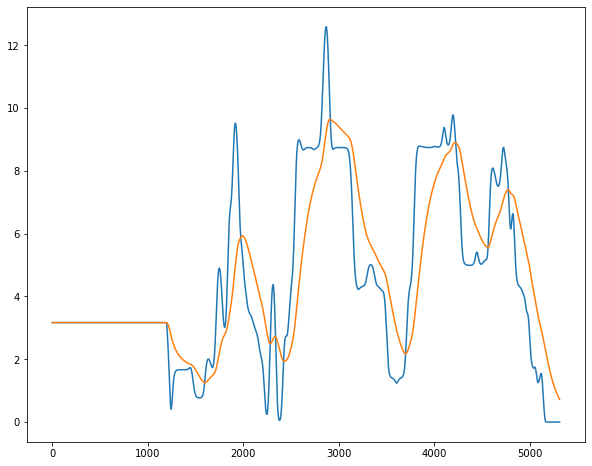

In [2]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.plot((speed[3:step,10]))
plt.plot((speed[3:step,11]))
#plt.plot((speed[:,17]/m2m))

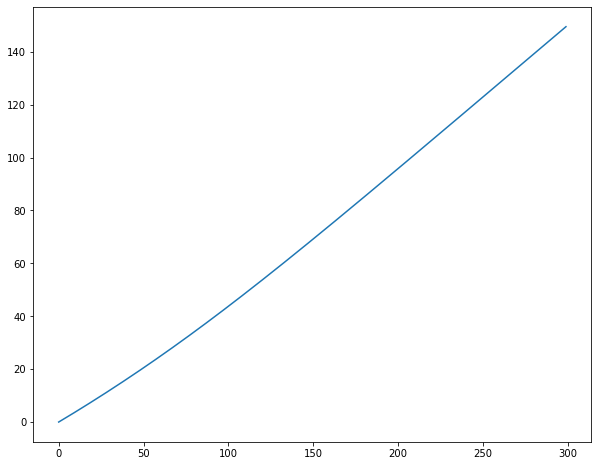

In [4]:
plt.figure(figsize=(10,8))
plt.plot(np.diff(position[:step,1])/1)
#plt.plot(np.diff(position[:1000,17])/1)
#plt.plot((speed[:3,11]/m2m))

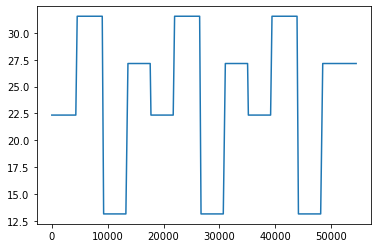

In [10]:
plt.plot(lead_v[:])

In [12]:
max_iter*dt/60

15.130555555555587

In [10]:
lead_a.shape

(54470,)

## Trapezoid

In [1]:
import os, sys, socket, re, json, random
import numpy as np
import matplotlib.pyplot as plt

if 'SUMO_HOME' in os.environ:
    tools = os.path.join(os.environ['SUMO_HOME'], 'tools')
    sys.path.append(tools)
else:
    sys.exit("please declare environment variable 'SUMO_HOME'")

#sumoBinary = os.path.join(os.environ['SUMO_HOME'], 'bin/sumo-gui')
#sumoCmd = [sumoBinary, "-c", "longhighway.sumo.cfg", "--start"]

import traci
import sumolib
from sumolib import checkBinary
import sumolib.net
from sumolib.net import readNet
from sumolib.net import Net
from sumolib.net import NetReader
from sumolib.net import lane
from sumolib.net import edge
from sumolib.net import node 
from sumolib.net import connection
from sumolib.net import roundabout
from sumolib.net.edge import Edge

##################### Lead Traj ########################
dt = 0.0166666666666667
#dt = 0.04
duration = 1200
m2m = 1/2.2369
v0 = 50*m2m*np.ones(4300)
#v0 = 30*m2m*np.ones(4300)
for i in range(230):
    v0 = np.append(v0, v0[-1]+1*dt*(0.04/dt))
v0 = np.append(v0, v0[-1]*np.ones(duration*2+500))
for i in range(230):
    v0 = np.append(v0, v0[-1]-2*dt*(0.04/dt))
v0 = np.append(v0, v0[-1]*np.ones(duration*2))
for i in range(350):
    v0 = np.append(v0, v0[-1]+1*dt*(0.04/dt))
v0 = np.append(v0, v0[-1]*np.ones(duration*2))
for i in range(120):
    v0 = np.append(v0, v0[-1]-1*dt*(0.04/dt))

v0 = np.append(v0, v0[-1]*np.ones(duration*2))
for i in range(230):
    v0 = np.append(v0, v0[-1]+1*dt*(0.04/dt))
v0 = np.append(v0, v0[-1]*np.ones(duration*2+500))
for i in range(230):
    v0 = np.append(v0, v0[-1]-2*dt*(0.04/dt))
v0 = np.append(v0, v0[-1]*np.ones(duration*2))
for i in range(350):
    v0 = np.append(v0, v0[-1]+1*dt*(0.04/dt))
v0 = np.append(v0, v0[-1]*np.ones(duration*2))
for i in range(120):
    v0 = np.append(v0, v0[-1]-1*dt*(0.04/dt))
    
v0 = np.append(v0, v0[-1]*np.ones(duration*2))
for i in range(230):
    v0 = np.append(v0, v0[-1]+1*dt*(0.04/dt))
v0 = np.append(v0, v0[-1]*np.ones(duration*2+500))
for i in range(230):
    v0 = np.append(v0, v0[-1]-2*dt*(0.04/dt))
v0 = np.append(v0, v0[-1]*np.ones(duration*2))
for i in range(350):
    v0 = np.append(v0, v0[-1]+1*dt*(0.04/dt))

v0 = np.append(v0, v0[-1]*np.ones(duration*3))

########################## Parameters of platoon ##########################
N_lane_0, N_lane_1, N_lane_2, N_behind = 0, 0, 2, 3

N_VEHICLES = N_lane_0 + N_lane_1 + N_lane_2

lead_v = v0
lead_a = np.diff(lead_v)/dt
lead_a = np.append(0, lead_a)

# used to randomly color the vehicles
random.seed(1)
step = 0

max_iter = len(lead_a)
#max_iter = 2
#print(max_iter)

position = np.zeros((max_iter+1, N_VEHICLES))
pos_ego = np.zeros((max_iter+1,))
speed = np.zeros((max_iter+1, N_VEHICLES))
speed_record = np.zeros((max_iter+1, N_VEHICLES))
accel = np.zeros((max_iter+1, N_VEHICLES))
light = np.zeros((max_iter+1, N_VEHICLES))

def EIDM(spacing, v, v0, s0=3, a0=1.8, b0=2.8, T=1, sigma=4, Kf=1, Kg=0.6, *cv_arg):

    cv_arg = cv_arg[0]
    CAV_count = len(cv_arg)//2
    temp_v, temp_a = 0, 0
    alpha, beta = np.zeros((1,CAV_count)), np.zeros((1,CAV_count))
    if CAV_count > 0:
        for i in range(CAV_count):
            alpha[i] = 0.3/(0.3+np.exp(i))
            beta[i] = 0.3/(0.3+np.exp(i))
            temp_v += alpha[i]*cv_arg[2*i]
            temp_a += beta[i]*cv_arg[2*i+1]
        #s_star = s0 + v*T - v*alpha[0]*cv_arg[0]/(2*np.sqrt(a0*b0))
        s_star = s0 + v*T - v*cv_arg[0]/(2*np.sqrt(a0*b0))
    else:
        print('Error because no CAV speed and acceleration input!')
    a_free = a0*(1-(v/v0)**sigma)
    a_int = -a0*(s_star/spacing)**2
    acc = a_free + a_int
    
    return Kf*acc + Kg*(temp_v + temp_a)

def acc_linear(h, v, space, rel_v, rel_a, ks, kv, ka):
    return ks*(space-h*v) + kv*rel_v + ka*rel_a

s0=2
a0=4
b0=6
T=1.2
sigma=4
Kf=1
Kg=0.5

length = 5
spd = lead_v[0]
v0 = 33
dis = (s0+spd*T)/np.sqrt(1-(spd/v0)**sigma)

# 30mph SU
#h = 2
#ks, kv, ka = 0.3, 0.1, 0.1
# 50mph SU
h = 2
ks, kv, ka = 0.2, 0.1, 0.1
# SS
#h = 1
#ks, kv, ka = 2, 2, 1
dis = spd*h + 5
#dis = 45
#########################################################################

graph = sumolib.net.readNet('LLC.net.xml', withInternal=True) #internal edge are edges inside interseciton or connections 
vertex = graph.getNodes()
edge = graph.getEdges(withInternal=True)
#print('edge length:')
#print(len(edge))

sumoCmd = [sumolib.checkBinary('sumo-gui'), '-c', 'LLC_SUMO_no.sumo.cfg']
traci.start(sumoCmd)
step = 0

traci.route.add(routeID = 'route1', edges = ['-17.0.00'])
#traci.vehicle.add('ego', "route")
traci.vehicle.add('ego', "route1", departPos=str(500), departSpeed=str(spd), departLane = str(2), typeID="vtypeauto")
traci.vehicle.setColor('ego', color=(255, 0, 0, 255))
traci.vehicle.setLaneChangeMode('ego', 256)

#UDP_IP = "192.168.0.11"
UDP_IP = "192.168.0.181"
UDP_PORT = 23333

'''
serverSock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
serverSock.bind((UDP_IP, UDP_PORT))

data, address = serverSock.recvfrom(1024*6)
data = data.decode('utf-8').split("$")[0]
y, x, z, vx, vy = data.split(";")
#x, y = '6448.97', '-6645.57'
X_offset, Y_offset = 0, 0      #10273, 1000.5  #882.504, 846.15
x, y, z = X_offset+float(x.replace("\x00", "")), Y_offset+float(y.replace("\x00", "")), float(z.replace("\x00", ""))*180/3.14159265
vx, vy = float(vx.replace("\x00", "")), float(vy.replace("\x00", ""))
eEdge = traci.vehicle.getRoadID('ego')
ePos = traci.vehicle.getPosition('ego')
traci.vehicle.moveToXY('ego', '', 0, x, y, angle=z, keepRoute=2)
'''

traci.simulationStep()
eLanePos = traci.vehicle.getLanePosition('ego')
print(eLanePos)

def dis_ego(vID_tmp):
	posi = traci.vehicle.getPosition(vID_tmp)
	dis = ((ePos[0] - posi[0])**2 + (ePos[1] - posi[1])**2)**(1/2)
	return dis
	
while step<=max_iter:
	'''
	data, address = serverSock.recvfrom(1024*6)
	data = data.decode('utf-8').split("$")[0]
	y, x, z, vx, vy = data.split(";")
	#x, y = '6448.97', '-6645.57'
	X_offset, Y_offset = 0, 0      #10273, 1000.5  #882.504, 846.15
	x, y, z = X_offset+float(x.replace("\x00", "")), Y_offset+float(y.replace("\x00", "")), float(z.replace("\x00", ""))*180/3.14159265
	vx, vy = float(vx.replace("\x00", "")), float(vy.replace("\x00", ""))
	eEdge = traci.vehicle.getRoadID('ego')
	ePos = traci.vehicle.getPosition('ego')
	traci.vehicle.moveToXY('ego', '', 0, x, y, angle=z, keepRoute=2)
	traci.vehicle.setSpeed('ego', 0.0)
	eLanePos = traci.vehicle.getLanePosition('ego')
	#print(eLanePos)
	pos_ego[step] = eLanePos
	'''
	eLanePos = traci.vehicle.getLanePosition('ego')
	#print(eLanePos)
	if step==0:
		for i in range(N_VEHICLES):
			position[0, i] = eLanePos + (N_lane_0+N_lane_1+N_lane_2-i)*dis
			speed[0, i] = spd
			accel[0, i] = 0
			vid = "%d" % i
			traci.vehicle.add(vid, "route1", departPos=str(position[0, i]), departSpeed=str(spd), departLane = str(2), typeID="vtypeauto")
			traci.vehicle.setColor(vid, (random.uniform(0, 255), random.uniform(0, 255), random.uniform(0, 255), 255))
			traci.vehicle.setLaneChangeMode(vid, 256)
			speed_record[step,i] = spd
			traci.gui.trackVehicle("View #0", "%d" % i)
			traci.gui.setZoom("View #0", 5000)
			
	elif step>=1:
		if True:
			#dt = 1
			space = position[step, N_lane_0 + N_lane_1 + N_lane_2 - 1] - traci.vehicle.getLanePosition('ego')
			rel_v = speed[step, N_lane_0 + N_lane_1 + N_lane_2 - 1] - traci.vehicle.getSpeed('ego')
			rel_acc = accel[step, N_lane_0 + N_lane_1 + N_lane_2 - 1] - traci.vehicle.getAcceleration('ego')
			#acceleration = EIDM(space, traci.vehicle.getSpeed('ego'), v0, s0, a0, b0, T, sigma, Kf, Kg, (rel_v,rel_acc))
			acceleration = acc_linear(h, traci.vehicle.getSpeed('ego'), space, rel_v, rel_acc, ks, kv, ka)
			traci.vehicle.setSpeed('ego', traci.vehicle.getSpeed('ego') + acceleration*dt)
            
			for i in range(N_VEHICLES):
				if i == 0:
					#traci.vehicle.setSpeed("v.%d" % i, lead_v[step//10])
					traci.vehicle.setSpeed("%d" % i, speed[step-1,i] + lead_a[step//1]*dt)
					Pos = position[step,i] + speed[step,i]*dt + 0.5*lead_a[step+1]*(dt**2)
					#traci.vehicle.moveTo("%d" % i, '-17.0.00_2', Pos) 
					if lead_a[step//1]<0:
						traci.vehicle.setSignals("%d" % i, 3)
				else:
					space = position[step-1,i-1] - position[step-1,i]
					v = speed[step-1,i]
					rel_v = speed[step-1,i-1] - speed[step-1,i]
					rel_acc = accel[step-1,i-1] - accel[step-1,i]
					#acceleration = EIDM(space, v, v0, s0, a0, b0, T, sigma, Kf, Kg, (rel_v,rel_acc))
					acceleration = acc_linear(h, v, space, rel_v, rel_acc, ks, kv, ka)
					Pos = position[step,i] + speed[step,i]*dt + 0.5*acceleration*(dt**2)
					#traci.vehicle.moveTo("%d" % i, '-17.0.00_2', Pos)       
					traci.vehicle.setSpeed("%d" % i, speed[step-1,i] + acceleration*dt)
					speed_record[step,i] = speed[step-1,i] + acceleration*dt
	#print(traci.vehicle.getPosition('ego'))
	#print(traci.vehicle.getLanePosition('ego'))
	print(traci.vehicle.getSpeed("1"), traci.vehicle.getAcceleration("1"))
	'''
	Message=''
	Message =  "0" + "," + "0" + "," + Message
	for k in range(N_VEHICLES):
		vID = str(k)
		
		Position = traci.vehicle.getPosition(vID)
		sig = light[step,k]      #traci.vehicle.getSignals(vID)
		vel = traci.vehicle.getSpeed(vID)

		#if (Position[0]-x)**2 + (Position[1]-y)**2 > 90000:
		#		continue
		Message += str(vID)+","

		#xx = "{0:.3f}".format(position[0]-x) 
		xx = "{0:.3f}".format(Position[0]-X_offset) 

		#yy = "{0:.3f}".format(position[1]-y) 
		yy = "{0:.3f}".format(Position[1]-Y_offset) 

		Message += xx + "," + yy +","
		#print(vID,Position[0],Position[1])
		#print(vID,xx,yy)
		angle = traci.vehicle.getAngle(vID)
		angle = "{0:.3f}".format(angle) 
		Message += angle + ","
		
		Message +=  str(sig) + "," + str(vel) + ","

	Message = Message[:-1]
	#print(repr(Message))
	serverSock.sendto(Message.encode('utf-8'), (address[0], 23334))
	'''
	step += 1
	traci.simulationStep()
    
	for i in range(N_VEHICLES):
		position[step,i] = traci.vehicle.getLanePosition("%d" % i)
		if step==0:
			speed[step,i] = spd
			accel[step,i] = 0
		else:
			speed[step,i] = traci.vehicle.getSpeed("%d" % i)
			#speed[step,i] = (position[step,i]-position[step-1,i])/dt
			accel[step,i] = traci.vehicle.getAcceleration("%d" % i)
			#accel[step,i] = (speed[step,i]-speed[step-1,i])/dt
		#light[step,i] = traci.vehicle.getSignals("v.%d" % i)
	print(speed[step-1,1], accel[step-1,1])
	#plt.plot(speed[max(0,step-1000):step,N_lane_0 + N_lane_1])
	#print(traci.vehicle.getSpeed(str(N_lane_0 + N_lane_1)))
	if step >= max_iter-1:
		np.savetxt('./run_pos_trapz50mph_su.txt', position);
		np.savetxt('./run_vel_trapz50mph_su.txt', speed);
		np.savetxt('./run_accel_trapz50mph_su.txt', accel);
		break

traci.close()

500.0
-1073741824.0 -1073741824.0
22.35236264473155 0.0
22.35236264473155 0.0
22.35236264473155 0.0
22.369029311398215 0.9803921568626893
22.369029311398215 0.9803921568626893
22.369029311398215 0.0
22.369029311398215 0.0
22.383922157803443 0.8760497885428384
22.383922157803443 0.8760497885428384
22.385555200287104 0.09606132256829582
22.385555200287104 0.09606132256829582
22.398862068285645 0.7827569410906258
22.398862068285645 0.7827569410906258
22.401779601947084 0.17161962714345022
22.401779601947084 0.17161962714345022
22.4138284517141 0.7087558686479954
22.4138284517141 0.7087558686479954
22.417737434490693 0.22994016332902714
22.417737434490693 0.22994016332902714
22.42878716704475 0.64998426788567
22.42878716704475 0.64998426788567
22.43345789656898 0.2747487955430639
22.43345789656898 0.2747487955430639
22.443711143787894 0.6031321893477952
22.443711143787894 0.6031321893477952
22.448963747622393 0.3089766961470191
22.448963747622393 0.3089766961470191
22.458579069043193 0.565

23.207267367539398 0.13528874616790007
23.20953502202192 0.13339144014841675
23.20953502202192 0.13339144014841675
23.211770488852675 0.1314980488678978
23.211770488852675 0.1314980488678978
23.213973835289828 0.1296086139501456
23.213973835289828 0.1296086139501456
23.21614512910463 0.1277231655765079
23.21614512910463 0.1277231655765079
23.218284438745535 0.12584174358272715
23.218284438745535 0.12584174358272715
23.220391833185055 0.123964378795282
23.220391833185055 0.123964378795282
23.22246738204728 0.12209110954272846
23.22246738204728 0.12209110954272846
23.224511155487104 0.12022196704840418
23.224511155487104 0.12022196704840418
23.226523224289117 0.11835698835373791
23.226523224289117 0.11835698835373791
23.228503659772155 0.11649620488457196
23.228503659772155 0.11649620488457196
23.230452533865805 0.11463965256761893
23.230452533865805 0.11463965256761893
23.232369919034745 0.11278736287887708
23.232369919034745 0.11278736287887708
23.234255888337756 0.11093937076534596
23

23.159433325689957 -0.12736852518729586
23.15725481473552 -0.12814770320216318
23.15725481473552 -0.12814770320216318
23.155063169245196 -0.1289203229602432
23.155063169245196 -0.1289203229602432
23.152858500622436 -0.12968638957409986
23.152858500622436 -0.12968638957409986
23.150640920181072 -0.1304459083155423
23.150640920181072 -0.1304459083155423
23.14841053914269 -0.13119888461060927
23.14841053914269 -0.13119888461060927
23.146167468633966 -0.13194532404270376
23.146167468633966 -0.13194532404270376
23.143911819684046 -0.13268523234820442
23.143911819684046 -0.13268523234820442
23.141643703221927 -0.13341861541876449
23.141643703221927 -0.13341861541876449
23.13936323007385 -0.13414547929859483
23.13936323007385 -0.13414547929859483
23.13707051096072 -0.13486583018425502
23.13707051096072 -0.13486583018425502
23.134765656495507 -0.13557967442423546
23.134765656495507 -0.13557967442423546
23.13244877718071 -0.13628701851749436
23.13244877718071 -0.13628701851749436
23.13011998340

22.58024387383985 -0.16588065960664766
22.58024387383985 -0.16588065960664766
22.577428924363293 -0.16558526332697537
22.577428924363293 -0.16558526332697537
22.57461905286225 -0.16528655888487934
22.57461905286225 -0.16528655888487934
22.57181431521502 -0.16498456748420867
22.57181431521502 -0.16498456748420867
22.569014766939286 -0.1646793103371719
22.569014766939286 -0.1646793103371719
22.566220463192117 -0.16437080865702233
22.566220463192117 -0.16437080865702233
22.56343145876985 -0.16405908366286492
22.56343145876985 -0.16405908366286492
22.560647808108058 -0.1637441565758944
22.560647808108058 -0.1637441565758944
22.55786956528152 -0.16342604861981325
22.55786956528152 -0.16342604861981325
22.555096784004178 -0.1631047810202049
22.555096784004178 -0.1631047810202049
22.552329517629104 -0.1627803750043246
22.552329517629104 -0.1627803750043246
22.549567819148514 -0.16245285179942756
22.549567819148514 -0.16245285179942756
22.546811741193743 -0.162122232633605
22.546811741193743 -

22.184661310426346 -0.07514761758057255
22.184661310426346 -0.07514761758057255
22.183393406296666 -0.07458259586352468
22.183393406296666 -0.07458259586352468
22.18213510373441 -0.07401779777977173
22.18213510373441 -0.07401779777977173
22.18088639869313 -0.07345323772240168
22.18088639869313 -0.07345323772240168
22.17964728688274 -0.07288893002285256
22.17964728688274 -0.07288893002285256
22.17841776377065 -0.07232488894652365
22.17841776377065 -0.07232488894652365
22.177197824582795 -0.07176112869737326
22.177197824582795 -0.07176112869737326
22.175987464304765 -0.07119766341352995
22.175987464304765 -0.07119766341352995
22.174786677682867 -0.07063450717042735
22.174786677682867 -0.07063450717042735
22.17359545922524 -0.07007167397808736
22.17359545922524 -0.07007167397808736
22.172413803202918 -0.06950917778362796
22.172413803202918 -0.06950917778362796
22.171241703650963 -0.06894703246791944
22.171241703650963 -0.06894703246791944
22.17007915436952 -0.06838525184955516
22.17007915

22.102987240289032 0.017810106025998893
22.103295558005883 0.01813633628532831
22.103295558005883 0.01813633628532831
22.10360939129388 0.01846078164688566
22.10360939129388 0.01846078164688566
22.103928709780906 0.018783440413309736
22.103928709780906 0.018783440413309736
22.104253483066927 0.019104310942410888
22.104253483066927 0.019104310942410888
22.104583680724932 0.01942339164738
22.104583680724932 0.01942339164738
22.10491927230185 0.01974068099511662
22.10491927230185 0.01974068099511662
22.10526022731949 0.020056177508318822
22.10526022731949 0.020056177508318822
22.105606515275458 0.02036987976276638
22.105606515275458 0.02036987976276638
22.10595810564408 0.020681786389619605
22.10595810564408 0.020681786389619605
22.106314967877328 0.02099189607332953
22.106314967877328 0.02099189607332953
22.106677071405716 0.02130020755226483
22.106677071405716 0.02130020755226483
22.107044385639234 0.021606719618711835
22.107044385639234 0.021606719618711835
22.107416879968245 0.0219114

22.230699466956146 0.0483850350777255
22.230699466956146 0.0483850350777255
22.231522041087235 0.048386713593457135
22.231522041087235 0.048386713593457135
22.232344621384478 0.048387076308387116
22.232344621384478 0.048387076308387116
22.23316718556782 0.04838612843183863
22.23316718556782 0.04838612843183863
22.23398971144605 0.04838387519006246
22.23398971144605 0.04838387519006246
22.23481217691701 0.048380321821221456
22.23481217691701 0.048380321821221456
22.235634559967878 0.04837547358040611
22.235634559967878 0.04837547358040611
22.236456838675373 0.04836933573503689
22.236456838675373 0.04836933573503689
22.23727899120602 0.04836191356737211
22.23727899120602 0.04836191356737211
22.23810099581637 0.04835321237367191
22.23810099581637 0.04835321237367191
22.23892283085324 0.04834323746294444
22.23892283085324 0.04834323746294444
22.239744474753934 0.048331994158408685
22.239744474753934 0.048331994158408685
22.24056590604647 0.04831948779624059
22.24056590604647 0.048319487796

22.368580105659703 0.030913006480784922
22.368580105659703 0.030913006480784922
22.369103103171906 0.030764559541338214
22.369103103171906 0.030764559541338214
22.36962357294752 0.030615869153858537
22.36962357294752 0.030615869153858537
22.370141510932708 0.030466940305101987
22.370141510932708 0.030466940305101987
22.370656913158243 0.03031777797262942
22.370656913158243 0.03031777797262942
22.371169775739215 0.030168387116029125
22.371169775739215 0.030168387116029125
22.37168009487488 0.030018772686112107
22.37168009487488 0.030018772686112107
22.37218786684835 0.0298689396159258
22.37218786684835 0.0298689396159258
22.372693088026423 0.0297188928278595
22.372693088026423 0.0297188928278595
22.373195754859314 0.029568637228837746
22.373195754859314 0.029568637228837746
22.373695863880428 0.029418177712619138
22.373695863880428 0.029418177712619138
22.374193411706138 0.02926751915937837
22.374193411706138 0.02926751915937837
22.374688395035516 0.02911666643403437
22.374688395035516 

22.419635401361223 0.006734677123009693
22.419635401361223 0.006734677123009693
22.419747616555714 0.0066008937936016185
22.419747616555714 0.0066008937936016185
22.419857563420077 0.006467462609591353
22.419857563420077 0.006467462609591353
22.41996524797843 0.006334385785364435
22.41996524797843 0.006334385785364435
22.420070676292166 0.006201665513990118
22.420070676292166 0.006201665513990118
22.420173854459723 0.006069303973908839
22.420173854459723 0.006069303973908839
22.420274788616176 0.005937303320781866
22.420274788616176 0.005937303320781866
22.42037348493302 0.005805665696686567
22.42037348493302 0.005805665696686567
22.420469949617768 0.005674393220503174
22.420469949617768 0.005674393220503174
22.420564188913737 0.005543487998154967
22.420564188913737 0.005543487998154967
22.420656209099626 0.005412952111114196
22.420656209099626 0.005412952111114196
22.42074601648933 0.00528278762956802
22.42074601648933 0.00528278762956802
22.4208336174315 0.005152996598416634
22.42083

22.406888667500315 -0.011145328253297079
22.406698473332124 -0.01118789224651597
22.406698473332124 -0.01118789224651597
22.40650756359248 -0.011229984684913527
22.40650756359248 -0.011229984684913527
22.406315946285392 -0.01127160629930385
22.406315946285392 -0.01127160629930385
22.40612362940224 -0.011312757832413086
22.40612362940224 -0.011312757832413086
22.405930620921648 -0.011353440034908732
22.405930620921648 -0.011353440034908732
22.405736928809283 -0.011393653668534398
22.405736928809283 -0.011393653668534398
22.40554256101771 -0.011433399504228952
22.40554256101771 -0.011433399504228952
22.405347525486242 -0.01147267832170856
22.405347525486242 -0.01147267832170856
22.405151830140735 -0.01151149091218345
22.405151830140735 -0.01151149091218345
22.40495548289348 -0.011549838073760303
22.40495548289348 -0.011549838073760303
22.404758491642998 -0.011587720616666823
22.404758491642998 -0.011587720616666823
22.40456086427391 -0.011625139358027153
22.40456086427391 -0.011625139358

22.365778158456287 -0.011965719195927704
22.365778158456287 -0.011965719195927704
22.365575185248982 -0.011939600429692918
22.365575185248982 -0.011939600429692918
22.36537265979082 -0.011913262244935567
22.36537265979082 -0.011913262244935567
22.365170585785002 -0.011886706224494085
22.365170585785002 -0.011886706224494085
22.364968966907828 -0.011859933951415888
22.364968966907828 -0.011859933951415888
22.3647678068087 -0.0118329470074945
22.3647678068087 -0.0118329470074945
22.364567109110123 -0.011805746975150386
22.364567109110123 -0.011805746975150386
22.36436687740773 -0.011778335434923171
22.36436687740773 -0.011778335434923171
22.364167115270273 -0.011750713967979422
22.364167115270273 -0.011750713967979422
22.363967826239644 -0.011722884154649778
22.363967826239644 -0.011722884154649778
22.363769013830893 -0.011694847573593011
22.363769013830893 -0.011694847573593011
22.363570681532213 -0.011666605804721791
22.363570681532213 -0.011666605804721791
22.363372832804984 -0.011638

22.337286076990356 -0.004340112573435603
22.337212995689438 -0.004298900054025392
22.337212995689438 -0.004298900054025392
22.337140614199186 -0.004257734720713348
22.337140614199186 -0.004257734720713348
22.337068931701687 -0.004216617499921807
22.337068931701687 -0.004216617499921807
22.33699794736336 -0.004175549313266495
22.33699794736336 -0.004175549313266495
22.336927660335046 -0.00413453107734754
22.336927660335046 -0.00413453107734754
22.33685806975208 -0.004093563703958459
22.33685806975208 -0.004093563703958459
22.336789174734392 -0.004052648099250224
22.336789174734392 -0.004052648099250224
22.336720974386576 -0.004011785165612109
22.336720974386576 -0.004011785165612109
22.336653467797994 -0.003970975798954909
22.336653467797994 -0.003970975798954909
22.33658665404284 -0.003930220891427726
22.33658665404284 -0.003930220891427726
22.336520532180245 -0.0038895213291191473
22.336520532180245 -0.0038895213291191473
22.336455101254344 -0.0038488779941470803
22.336455101254344 -0

22.335496315009163 0.002441450213343815
22.335496315009163 0.002441450213343815
22.335538111339954 0.0024586076935908265
22.335538111339954 0.0024586076935908265
22.335580197059926 0.0024756305865945277
22.335580197059926 0.0024756305865945277
22.335622569882386 0.002492518968215804
22.335622569882386 0.002492518968215804
22.335665227521904 0.0025092729128526597
22.335665227521904 0.0025092729128526597
22.335708167694445 0.0025258925024264924
22.335708167694445 0.0025258925024264924
22.33575138811737 0.0025423778190676836
22.33575138811737 0.0025423778190676836
22.33579488650952 0.0025587289501311926
22.33579488650952 0.0025587289501311926
22.335838660591268 0.0025749459850618116
22.335838660591268 0.0025749459850618116
22.33588270808457 0.002591029017692977
22.33588270808457 0.002591029017692977
22.33592702671301 0.0026069781435299933
22.33592702671301 0.0026069781435299933
22.33597161420189 0.0026227934635117247
22.33597161420189 0.0026227934635117247
22.336016468278235 0.00263847507

22.346816868340053 0.003467395628868363
22.346816868340053 0.003467395628868363
22.346875730264706 0.00346246615609068
22.346875730264706 0.00346246615609068
22.346934507128214 0.0034574625592858196
22.346934507128214 0.0034574625592858196
22.34699319767777 0.00345238526791417
22.34699319767777 0.00345238526791417
22.347051800667874 0.00344723471206307
22.347051800667874 0.00344723471206307
22.347110314860334 0.0034420113211929082
22.347110314860334 0.0034420113211929082
22.347168739024276 0.0034367155260179726
22.347168739024276 0.0034367155260179726
22.347227071936143 0.0034313477568345845
22.347227071936143 0.0034313477568345845
22.3472853123797 0.0034259084445660147
22.3472853123797 0.0034259084445660147
22.347343459146042 0.0034203980201355346
22.347343459146042 0.0034203980201355346
22.347401511033592 0.0034148169146753977
22.347401511033592 0.0034148169146753977
22.347459466848104 0.003409165559526841
22.347459466848104 0.003409165559526841
22.347517325402677 0.00340344438665805

22.35563939184925 0.0015953090782512148
22.355666315858375 0.001583765242559941
22.355666315858375 0.001583765242559941
22.35569304367238 0.0015722243533222058
22.35569304367238 0.0015722243533222058
22.35571957534646 0.0015606867104288405
22.35571957534646 0.0015606867104288405
22.35574591094089 0.0015491526135616928
22.35574591094089 0.0015491526135616928
22.35577205052102 0.0015376223605217626
22.35577205052102 0.0015376223605217626
22.35579799415724 0.0015260962482741165
22.35579799415724 0.0015260962482741165
22.35582374192496 0.0015145745719029732
22.35582374192496 0.0015145745719029732
22.355849293904598 0.0015030576256566184
22.355849293904598 0.0015030576256566184
22.355874650181544 0.0014915457027384223
22.355874650181544 0.0014915457027384223
22.35589981084614 0.001480039093843957
22.35589981084614 0.001480039093843957
22.355924775993675 0.0014685380902957443
22.355924775993675 0.0014685380902957443
22.355949545724332 0.001457042979863592
22.355949545724332 0.001457042979863

22.35748662022214 -0.00031963952990314977
22.35748662022214 -0.00031963952990314977
22.357481069273767 -0.0003265263748797973
22.357481069273767 -0.0003265263748797973
22.357475401863677 -0.0003333770640983188
22.357475401863677 -0.0003333770640983188
22.357469618607226 -0.00034019155597106606
22.357469618607226 -0.00034019155597106606
22.357463720120464 -0.00034696980953733997
22.357463720120464 -0.00034696980953733997
22.357457707020117 -0.00035371178509034076
22.357457707020117 -0.00035371178509034076
22.357451579923563 -0.0003604174443861505
22.357451579923563 -0.0003604174443861505
22.357445339448812 -0.00036708675001678406
22.357445339448812 -0.00036708675001678406
22.3574389862145 -0.0003737196654101888
22.3574389862145 -0.0003737196654101888
22.35743252083985 -0.0003803161558751606
22.35743252083985 -0.0003803161558751606
22.357425943944666 -0.00038687618734744477
22.357425943944666 -0.00038687618734744477
22.35741925614931 -0.0003933997268077024
22.35741925614931 -0.0003933997

22.355002140883435 -0.0009852071025139753
22.354985387392865 -0.0009854994452914124
22.354985387392865 -0.0009854994452914124
22.354968629405462 -0.000985763964887182
22.354968629405462 -0.000985763964887182
22.35495186739247 -0.0009860007643299816
22.35495186739247 -0.0009860007643299816
22.35493510182336 -0.00098620994748444
22.35493510182336 -0.00098620994748444
22.354918333165855 -0.0009863916180062032
22.354918333165855 -0.0009863916180062032
22.354901561885896 -0.0009865458799688841
22.354901561885896 -0.0009865458799688841
22.35488478844764 -0.0009866728384910106
22.35488478844764 -0.0009866728384910106
22.354868013313478 -0.000986772597855179
22.354868013313478 -0.000986772597855179
22.354851236943997 -0.000986845263597883
22.354851236943997 -0.000986845263597883
22.354834459798 -0.0009868909410466343
22.354834459798 -0.0009868909410466343
22.35481768233248 -0.0009869097363648773
22.35481768233248 -0.0009869097363648773
22.35480090500264 -0.0009869017552980896
22.35480090500264

22.351973062276443 -0.000613565064063149
22.351973062276443 -0.000613565064063149
22.351962683590603 -0.0006105109317435536
22.351962683590603 -0.0006105109317435536
22.35195235689985 -0.0006074523971937437
22.35195235689985 -0.0006074523971937437
22.351942082277304 -0.0006043895615615677
22.351942082277304 -0.0006043895615615677
22.351931859794394 -0.0006013225241140256
22.351931859794394 -0.0006013225241140256
22.35192168952085 -0.0005982513849540496
22.35192168952085 -0.0005982513849540496
22.351911571524713 -0.0005951762433486397
22.351911571524713 -0.0005951762433486397
22.35190150587235 -0.0005920971979378464
22.35190150587235 -0.0005920971979378464
22.351891492628422 -0.0005890143486156188
22.351891492628422 -0.0005890143486156188
22.351881531855955 -0.000585927792141159
22.351881531855955 -0.000585927792141159
22.351871623616265 -0.0005828376288263826
22.351871623616265 -0.0005828376288263826
22.351861767969037 -0.0005797439545945588
22.351861767969037 -0.0005797439545945588
22

22.350947419651426 -7.247951697643335e-05
22.35094623067784 -6.993962261624213e-05
22.35094623067784 -6.993962261624213e-05
22.350945084743337 -6.740791203650159e-05
22.350945084743337 -6.740791203650159e-05
22.35094398170817 -6.488442160028117e-05
22.35094398170817 -6.488442160028117e-05
22.350942921432 -6.236918641675134e-05
22.350942921432 -6.236918641675134e-05
22.35094190377388 -5.9862242431015194e-05
22.35094190377388 -5.9862242431015194e-05
22.350940928592276 -5.736362370732743e-05
22.350940928592276 -5.736362370732743e-05
22.35093999574505 -5.487336619079114e-05
22.35093999574505 -5.487336619079114e-05
22.350939105089513 -5.239150227379575e-05
22.350939105089513 -5.239150227379575e-05
22.35093825648236 -4.9918067692461214e-05
22.35093825648236 -4.9918067692461214e-05
22.350937449779757 -4.745309442121063e-05
22.350937449779757 -4.745309442121063e-05
22.350936684837276 -4.499661652429869e-05
22.350936684837276 -4.499661652429869e-05
22.35093596150995 -4.254866618513166e-05
22.35

22.351320704128916 0.00024119010475106626
22.35132481628501 0.00024189153498522338
22.35132481628501 0.00024189153498522338
22.35132894020687 0.0002425836387190242
22.35132894020687 0.0002425836387190242
22.351333075736225 0.0002432664326711213
22.351333075736225 0.0002432664326711213
22.35133722271515 0.00024393993669491462
22.35133722271515 0.00024393993669491462
22.351341380986014 0.00024460416855397264
22.351341380986014 0.00024460416855397264
22.35134555039152 0.00024525914747474574
22.35134555039152 0.00024525914747474574
22.351349730774686 0.00024590489205673503
22.351349730774686 0.00024590489205673503
22.351353921978863 0.00024654142215334047
22.351353921978863 0.00024654142215334047
22.351358123847717 0.00024716875615507993
22.351358123847717 0.00024716875615507993
22.351362336225268 0.00024778691475128595
22.351362336225268 0.00024778691475128595
22.351366558955842 0.00024839591612349336
22.351366558955842 0.00024839591612349336
22.35137079188413 0.00024899578158798407
22.35

22.352191847817398 0.00022910343112832432
22.352191847817398 0.00022910343112832432
22.352195731745688 0.00022846637000551546
22.352195731745688 0.00022846637000551546
22.352199604781816 0.00022782565460321324
22.352199604781816 0.00022782565460321324
22.352203466864207 0.00022718131710482392
22.352203466864207 0.00022718131710482392
22.352207317931825 0.00022653338927578742
22.352207317931825 0.00022653338927578742
22.35221115792417 0.00022588190267256055
22.35221115792417 0.00022588190267256055
22.35221498678129 0.00022522688947854957
22.35221498678129 0.00022522688947854957
22.352218804443762 0.0002245683806232618
22.352218804443762 0.0002245683806232618
22.352222610852714 0.000223906408917053
22.352222610852714 0.000223906408917053
22.352226405949793 0.000223241004662481
22.352226405949793 0.000223241004662481
22.35223018967721 0.00022257220108786788
22.35223018967721 0.00022257220108786788
22.352233961977685 0.00022190002786882197
22.352233961977685 0.00022190002786882197
22.35223

22.352716506367532 5.774514419573172e-05
22.352716506367532 5.774514419573172e-05
22.352717474566536 5.695288256688132e-05
22.352717474566536 5.695288256688132e-05
22.352718429324348 5.616222425681585e-05
22.352718429324348 5.616222425681585e-05
22.35271937066844 5.537318180452476e-05
22.35271937066844 5.537318180452476e-05
22.352720298626572 5.4585772555610135e-05
22.352720298626572 5.4585772555610135e-05
22.35272121322673 5.380000925804458e-05
22.35272121322673 5.380000925804458e-05
22.352722114497173 5.3015908421497544e-05
22.352722114497173 5.3015908421497544e-05
22.352723002466387 5.223348321190796e-05
22.352723002466387 5.223348321190796e-05
22.352723877163125 5.1452749303012644e-05
22.352723877163125 5.1452749303012644e-05
22.352724738616367 5.067372006973367e-05
22.352724738616367 5.067372006973367e-05
22.35272558685535 4.989641076784156e-05
22.35272558685535 4.989641076784156e-05
22.35272642190954 4.912083477225839e-05
22.35272642190954 4.912083477225839e-05
22.352727243808662

22.35270182574383 -5.1712074413417745e-05
22.35270182574383 -5.1712074413417745e-05
22.35270094094928 -5.2046738161112336e-05
22.35270094094928 -5.2046738161112336e-05
22.352700050511967 -5.2378665483341616e-05
22.352700050511967 -5.2378665483341616e-05
22.352699154478362 -5.270785909688664e-05
22.352699154478362 -5.270785909688664e-05
22.35269825289491 -5.3034320673612665e-05
22.35269825289491 -5.3034320673612665e-05
22.35269734580802 -5.335805230335127e-05
22.35269734580802 -5.335805230335127e-05
22.35269643326407 -5.367905586695087e-05
22.35269643326407 -5.367905586695087e-05
22.3526955153094 -5.3997333663226204e-05
22.3526955153094 -5.3997333663226204e-05
22.352694591990304 -5.4312887990991995e-05
22.352694591990304 -5.4312887990991995e-05
22.35269366335305 -5.462572073109667e-05
22.35269366335305 -5.462572073109667e-05
22.35269272944386 -5.4935834809304436e-05
22.35269272944386 -5.4935834809304436e-05
22.352691790308917 -5.524323189748055e-05
22.352691790308917 -5.524323189748055e

22.904127554710435 1.5582392765558113
22.89197990513649 -0.7145676219966854
22.89197990513649 -0.7145676219966854
22.91858590338321 1.5650587203952384
22.91858590338321 1.5650587203952384
22.906554415447765 -0.7077345844379579
22.906554415447765 -0.7077345844379579
22.933276802447903 1.5719051176551806
22.933276802447903 1.5719051176551806
22.92136192625885 -0.7008750699442851
22.92136192625885 -0.7008750699442851
22.948201144022345 1.57877751549971
22.948201144022345 1.57877751549971
22.936403313527464 -0.6939900291106686
22.936403313527464 -0.6939900291106686
22.96335978794635 1.5856749658167542
22.96335978794635 1.5856749658167542
22.951679421014592 -0.6870804077503662
22.951679421014592 -0.6870804077503662
22.97875356194444 1.5925965252851797
22.97875356194444 1.5925965252851797
22.96719106044829 -0.6801471468324058
22.96719106044829 -0.6801471468324058
22.994383261790805 1.599541255442084
22.994383261790805 1.599541255442084
22.98293901168964 -0.6731911824213993
22.98293901168964 

25.05139852403731 0.7833556797553388
25.064714195557283 0.7832747952924989
25.064714195557283 0.7832747952924989
25.078028092843187 0.7831704285826102
25.078028092843187 0.7831704285826102
25.091339901986718 0.7830475966782762
25.091339901986718 0.7830475966782762
25.104649236364363 0.7829020222144202
25.104649236364363 0.7829020222144202
25.117955776440294 0.7827376515253343
25.117955776440294 0.7827376515253343
25.13125914608204 0.7825511553968855
25.13125914608204 0.7825511553968855
25.14455902199769 0.7823456420970173
25.14455902199769 0.7823456420970173
25.15785503691756 0.7821185246982472
25.15785503691756 0.7821185246982472
25.171146865261367 0.7818722555180352
25.171146865261367 0.7818722555180352
25.184434147350345 0.7816048287634119
25.184434147350345 0.7816048287634119
25.197716556467423 0.781318183357543
25.197716556467423 0.781318183357543
25.210993739531766 0.7810107684907517
25.210993739531766 0.7810107684907517
25.224265369593546 0.7806841212811831
25.224265369593546 0.

27.33907115899674 0.4636658700898224
27.33907115899674 0.4636658700898224
27.34691174572477 0.461210984001739
27.34691174572477 0.461210984001739
27.35471055281715 0.45875335837517717
27.35471055281715 0.45875335837517717
27.36246753501687 0.4562930705717312
27.36246753501687 0.4562930705717312
27.370182648378066 0.4538301977174713
27.370182648378066 0.4538301977174713
27.37785585026201 0.4513648167025257
27.37785585026201 0.4513648167025257
27.38548709933308 0.4488970041806627
27.38548709933308 0.4488970041806627
27.3930763555547 0.44642683656594695
27.3930763555547 0.44642683656594695
27.40062358018529 0.4439543900346202
27.40062358018529 0.4439543900346202
27.40812873577414 0.44147974052071287
27.40812873577414 0.44147974052071287
27.41559178615735 0.43900296371813347
27.41559178615735 0.43900296371813347
27.423012696453657 0.43652413507690735
27.423012696453657 0.43652413507690735
27.43039143306033 0.43404332980422144
27.43039143306033 0.43404332980422144
27.43772796364897 0.431560

28.085817394227192 0.03067243117125512
28.08630609041458 0.028746834552313937
28.08630609041458 0.028746834552313937
28.08676216810261 0.026828099295779097
28.08676216810261 0.026828099295779097
28.087185744354212 0.024916250094264566
28.087185744354212 0.024916250094264566
28.087576936647277 0.023011311356794174
28.087576936647277 0.023011311356794174
28.087935862869806 0.02111330720754769
28.087935862869806 0.02111330720754769
28.08826264131512 0.0192222614889956
28.08826264131512 0.0192222614889956
28.088557390677014 0.017338197758555357
28.088557390677014 0.017338197758555357
28.088820230045005 0.015461139293606986
28.088820230045005 0.015461139293606986
28.0890512788995 0.013591109087940366
28.0890512788995 0.013591109087940366
28.08925065710703 0.011728129854680995
28.08925065710703 0.011728129854680995
28.089418484915477 0.009872224026289986
28.089418484915477 0.009872224026289986
28.089554882949297 0.008023413754146117
28.089554882949297 0.008023413754146117
28.089659972204778 

27.686368731218945 -0.2041746005461926
27.686368731218945 -0.2041746005461926
27.68289167372711 -0.2045327936373804
27.68289167372711 -0.2045327936373804
27.679408645184452 -0.2048840319210148
27.679408645184452 -0.2048840319210148
27.67591976351522 -0.2052283334841701
27.67591976351522 -0.2052283334841701
27.6724251463342 -0.20556571653074227
27.6724251463342 -0.20556571653074227
27.668924910944753 -0.20589619937914996
27.668924910944753 -0.20589619937914996
27.665419174336893 -0.2062198004623346
27.665419174336893 -0.2062198004623346
27.661908053185353 -0.2065365383258796
27.661908053185353 -0.2065365383258796
27.658391663847688 -0.20684643162738323
27.658391663847688 -0.20684643162738323
27.65487012236237 -0.2071494991362499
27.65487012236237 -0.2071494991362499
27.651343544446938 -0.20744575973139107
27.651343544446938 -0.20744575973139107
27.647812045496114 -0.20773523240143443
27.647812045496114 -0.20773523240143443
27.644275740579985 -0.20801793624284293
27.644275740579985 -0.20

27.052711416280186 -0.1758355205888302
27.04973135603327 -0.17529766158328725
27.04973135603327 -0.17529766158328725
27.04676048374337 -0.17475719352354283
27.04676048374337 -0.17475719352354283
27.043798843339864 -0.17421414138266633
27.043798843339864 -0.17421414138266633
27.040846478328067 -0.1736685301057234
27.040846478328067 -0.1736685301057234
27.03790343178977 -0.17312038460580517
27.03790343178977 -0.17312038460580517
27.0349697463837 -0.1725697297686261
27.0349697463837 -0.1725697297686261
27.032045464346123 -0.17201659044583634
27.032045464346123 -0.17201659044583634
27.029130627491284 -0.17146099146108226
27.029130627491284 -0.17146099146108226
27.026225277212035 -0.1709029576029011
27.026225277212035 -0.1709029576029011
27.023329454480322 -0.17034251363015454
27.023329454480322 -0.17034251363015454
27.020443199847797 -0.169779684266177
27.020443199847797 -0.169779684266177
27.01756655344634 -0.16921449420337353
27.01756655344634 -0.16921449420337353
27.01469955498869 -0.16

26.664498060418616 -0.03985460517174534
26.664498060418616 -0.03985460517174534
26.663831008399267 -0.03923835407934127
26.663831008399267 -0.03923835407934127
26.663174409135195 -0.038623486121903236
26.663174409135195 -0.038623486121903236
26.662528238923578 -0.03801001244805574
26.662528238923578 -0.03801001244805574
26.66189247387346 -0.037397944124501904
26.66189247387346 -0.037397944124501904
26.66126708990715 -0.03678729213602343
26.66126708990715 -0.03678729213602343
26.660652062761592 -0.03617806738568962
26.660652062761592 -0.03617806738568962
26.66004736798979 -0.035570280694230405
26.66004736798979 -0.035570280694230405
26.659452980962175 -0.03496394280087228
26.659452980962175 -0.03496394280087228
26.658868876868 -0.03435906436333833
26.658868876868 -0.03435906436333833
26.65829503071674 -0.03375565595638531
26.65829503071674 -0.03375565595638531
26.657731417339466 -0.03315372807493839
26.657731417339466 -0.03315372807493839
26.657178011390247 -0.0325532911305385
26.657178

26.690769026593674 0.04375993938681939
26.69151707195428 0.04400266827092276
26.69151707195428 0.04400266827092276
26.692269207096906 0.04424324368389922
26.692269207096906 0.04424324368389922
26.693025395447158 0.04448166766187167
26.693025395447158 0.04448166766187167
26.69378560046604 0.04471794228714831
26.69378560046604 0.04471794228714831
26.694549785650867 0.044952069695745965
26.694549785650867 0.044952069695745965
26.69531791453606 0.045184052070075774
26.69531791453606 0.045184052070075774
26.696089950694013 0.04541389164437666
26.696089950694013 0.04541389164437666
26.696865857735915 0.04564159070011776
26.696865857735915 0.04564159070011776
26.69764559931259 0.045867151569133145
26.69764559931259 0.045867151569133145
26.698429139115316 0.04609057663090505
26.698429139115316 0.04609057663090505
26.699216440876643 0.0463118683133998
26.699216440876643 0.0463118683133998
26.700007468371226 0.046531029093067805
26.700007468371226 0.046531029093067805
26.700802185416624 0.046748

26.875944759415777 0.05490235103188049
26.876876464231724 0.05480616564396461
26.876876464231724 0.05480616564396461
26.877806515174942 0.05470887901282139
26.877806515174942 0.05470887901282139
26.878734893643298 0.0546104981385507
26.878734893643298 0.0546104981385507
26.879661581153716 0.054511030024596105
26.879661581153716 0.054511030024596105
26.880586559342188 0.05441048167481914
26.880586559342188 0.05441048167481914
26.88150980996381 0.054308860095380176
26.88150980996381 0.054308860095380176
26.8824313148928 0.054206172293484484
26.8824313148928 0.054206172293484484
26.883351056122507 0.05410242527696428
26.883351056122507 0.05410242527696428
26.88426901576545 0.05399762605553265
26.88426901576545 0.05399762605553265
26.88518517605329 0.053891781637648746
26.88518517605329 0.053891781637648746
26.886099519336888 0.05378489903511549
26.886099519336888 0.05378489903511549
26.88701202808625 0.05367698525660102
26.88701202808625 0.05367698525660102
26.887922684890594 0.0535680473

27.018528132216428 0.01949787307525492
27.018528132216428 0.01949787307525492
27.01885649093036 0.019315218466640343
27.01885649093036 0.019315218466640343
27.019181747950462 0.01913276588831369
27.019181747950462 0.01913276588831369
27.01950390678151 0.018950519473334867
27.01950390678151 0.018950519473334867
27.019822970998224 0.01876848333616428
27.019822970998224 0.01876848333616428
27.020138944244856 0.01858666156660233
27.020138944244856 0.01858666156660233
27.020451830234837 0.018405058234178033
27.020451830234837 0.018405058234178033
27.02076163275039 0.018223677385432277
27.02076163275039 0.018223677385432277
27.021068355642164 0.01804252304558966
27.021068355642164 0.01804252304558966
27.021372002828848 0.017861599216677643
27.021372002828848 0.017861599216677643
27.021672578296805 0.017680909879825388
27.021672578296805 0.017680909879825388
27.02197008609969 0.01750045899317389
27.02197008609969 0.01750045899317389
27.022264530358072 0.017320250493129914
27.022264530358072 0

27.03154170973342 -0.008467564893647129
27.031396189941574 -0.008559987755690451
27.031396189941574 -0.008559987755690451
27.031249109131373 -0.008651812364783327
27.031249109131373 -0.008651812364783327
27.031100477475 -0.008743038610164683
27.031100477475 -0.008743038610164683
27.03095030514625 -0.008833666397165148
27.03095030514625 -0.008833666397165148
27.030798602320232 -0.008923695648042988
27.030798602320232 -0.008923695648042988
27.03064537917311 -0.009013126301357153
27.03064537917311 -0.009013126301357153
27.030490645881795 -0.009101958312594232
27.030490645881795 -0.009101958312594232
27.030334412623702 -0.009190191652496583
27.030334412623702 -0.009190191652496583
27.030176689576436 -0.009277826309779115
27.030176689576436 -0.009277826309779115
27.030017486917547 -0.009364862287576577
27.030017486917547 -0.009364862287576577
27.029856814824228 -0.009451299606996264
27.029856814824228 -0.009451299606996264
27.029694683473068 -0.009537138303565316
27.029694683473068 -0.00953

26.985024416396637 -0.015838876815287086
26.984755339998312 -0.015828023430899788
26.984755339998312 -0.015828023430899788
26.984486454655652 -0.015816784862340345
26.984486454655652 -0.015816784862340345
26.984217766885607 -0.01580516294385394
26.984217766885607 -0.01580516294385394
26.983949283173956 -0.01579315950884981
26.983949283173956 -0.01579315950884981
26.98368100997521 -0.01578077639679771
26.98368100997521 -0.01578077639679771
26.983412953712584 -0.015768015448630275
26.983412953712584 -0.015768015448630275
26.983145120777944 -0.0157548785082059
26.983145120777944 -0.0157548785082059
26.98287751753175 -0.015741367423144685
26.98287751753175 -0.015741367423144685
26.98261015030302 -0.015727484042947572
26.98261015030302 -0.015727484042947572
26.98234302538928 -0.015713230220041275
26.98234302538928 -0.015713230220041275
26.982076149056507 -0.015698607810196226
26.982076149056507 -0.015698607810196226
26.981809527539106 -0.015683618670645754
26.981809527539106 -0.015683618670

26.943439492737184 -0.009126810746848565
26.943439492737184 -0.009126810746848565
26.943285193903993 -0.009076401952428875
26.943285193903993 -0.009076401952428875
26.943131752795342 -0.009025947567706413
26.943131752795342 -0.009025947567706413
26.942979170159983 -0.008975449138738574
26.942979170159983 -0.008975449138738574
26.94282744672047 -0.008924908206567165
26.94282744672047 -0.008924908206567165
26.942676583173252 -0.00887432630700941
26.942676583173252 -0.00887432630700941
26.942526580188737 -0.008823704971493885
26.942526580188737 -0.008823704971493885
26.9423774384114 -0.008773045725806628
26.9423774384114 -0.008773045725806628
26.942229158459853 -0.00872235009092706
26.942229158459853 -0.00872235009092706
26.942081740926938 -0.008671619583236968
26.942081740926938 -0.008671619583236968
26.94193518637982 -0.008620855712848652
26.94193518637982 -0.008620855712848652
26.941789495360048 -0.008570059986530676
26.941789495360048 -0.008570059986530676
26.941644668383677 -0.008519

26.929164436593705 4.389998451034337e-05
26.929165807579263 8.064620929230038e-05
26.929165807579263 8.064620929230038e-05
26.929167800735335 0.00011724447483462586
26.929167800735335 0.00011724447483462586
26.929170413539744 0.00015369437696389308
26.929170413539744 0.00015369437696389308
26.929173643463567 0.0001899955190300689
26.929173643463567 0.0001899955190300689
26.929177487971202 0.00022614750793583397
26.929177487971202 0.00022614750793583397
26.929181944520494 0.0002621499583162457
26.929181944520494 0.0002621499583162457
26.9291870105628 0.00029800248856805836
26.9291870105628 0.00029800248856805836
26.929192683543107 0.0003337047239844704
26.929192683543107 0.0003337047239844704
26.929198960900113 0.0003692562944563098
26.929198960900113 0.0003692562944563098
26.929205840066327 0.00040465683614389916
26.929205840066327 0.00040465683614389916
26.929213318468157 0.0004399059900141738
26.929213318468157 0.0004399059900141738
26.929221393526014 0.0004750034033035637
26.9292213

26.939091514899964 0.004299587914774145
26.939091514899964 0.004299587914774145
26.939164676984895 0.004303652054752948
26.939164676984895 0.004303652054752948
26.939237905906648 0.004307583632535237
26.939237905906648 0.004307583632535237
26.93931119941881 0.004311383068386142
26.93931119941881 0.004311383068386142
26.939384555282118 0.004315050782779775
26.939384555282118 0.004315050782779775
26.93945797126452 0.004318587200160931
26.93945797126452 0.004318587200160931
26.939531445141178 0.004321992744556436
26.939531445141178 0.004321992744556436
26.93960497469453 0.004325267844172779
26.93960497469453 0.004325267844172779
26.93967855771428 0.0043284129265895015
26.93967855771428 0.0043284129265895015
26.939752191997492 0.004331428424192756
26.939752191997492 0.004331428424192756
26.939825875348536 0.004334314767278863
26.939825875348536 0.004334314767278863
26.939899605579214 0.0043370723928316075
26.939899605579214 0.0043370723928316075
26.939973380508693 0.004339701734073073
26.9

26.952517507284195 0.0031290723752206034
26.952570486295127 0.0031164124077149072
26.952570486295127 0.0031164124077149072
26.952623249507035 0.0031037183475328164
26.952623249507035 0.0031037183475328164
26.952675796348462 0.0030909906722008463
26.952675796348462 0.0030909906722008463
26.9527281262561 0.0030782298611263604
26.9527281262561 0.0030782298611263604
26.952780238674716 0.003065436389119093
26.952780238674716 0.003065436389119093
26.95283213305719 0.0030526107337055584
26.95283213305719 0.0030526107337055584
26.952883808864446 0.0030397533680236255
26.952883808864446 0.0030397533680236255
26.952935265565483 0.003026864766883029
26.952935265565483 0.003026864766883029
26.952986502637323 0.0030139454023767214
26.952986502637323 0.0030139454023767214
26.953037519565004 0.0030009957459707064
26.953037519565004 0.0030009957459707064
26.953088315841573 0.0029880162687130206
26.953088315841573 0.0029880162687130206
26.945157887046474 -0.46649581147641034
26.945157887046474 -0.46649

25.4770515654377 -3.282842106484238
25.498513989632063 1.2624955408447682
25.498513989632063 1.2624955408447682
25.442464518199436 -3.2970277313309446
25.442464518199436 -3.2970277313309446
25.463685514791987 1.2482939172088399
25.463685514791987 1.2482939172088399
25.40739435138053 -3.3112449065563796
25.40739435138053 -3.3112449065563796
25.42837339921284 1.2340616371948738
25.42837339921284 1.2340616371948738
25.371840037817808 -3.3254918467666443
25.371840037817808 -3.3254918467666443
25.392576645990747 1.2198004807611167
25.392576645990747 1.2198004807611167
25.335800610773433 -3.3397667774890913
25.335800610773433 -3.3397667774890913
25.356294318460545 1.205512216888974
25.356294318460545 1.205512216888974
25.299275163560814 -3.3540679352782794
25.299275163560814 -3.3540679352782794
25.319525539819963 1.1911986034793558
25.319525539819963 1.1911986034793558
25.262262849167037 -3.3683935678192087
25.262262849167037 -3.3683935678192087
25.282269492750277 1.176861387249438
25.282269

19.952485567789786 -1.142592771065451
19.952485567789786 -1.142592771065451
19.933078998639534 -1.1415628911913114
19.933078998639534 -1.1415628911913114
19.91369043856951 -1.14050353353079
19.91369043856951 -1.14050353353079
19.894320300435663 -1.1394198902263413
19.894320300435663 -1.1394198902263413
19.874969070861805 -1.1383076219915973
19.874969070861805 -1.1383076219915973
19.855637166873077 -1.137170822866384
19.855637166873077 -1.137170822866384
19.836325062734463 -1.1360061258007943
19.836325062734463 -1.1360061258007943
19.817033177724177 -1.1348167653109609
19.817033177724177 -1.1348167653109609
19.797761975421256 -1.133600135465935
19.797761975421256 -1.133600135465935
19.778511875855035 -1.132358798013028
19.778511875855035 -1.132358798013028
19.759283333226158 -1.1310907428751156
19.759283333226158 -1.1310907428751156
19.74007676713747 -1.1297980052169139
19.74007676713747 -1.1297980052169139
19.720892623432924 -1.1284790414438899
19.720892623432924 -1.1284790414438899
19

16.903462743802795 -0.5935013536208674
16.903462743802795 -0.5935013536208674
16.89343621512815 -0.5897958043907933
16.89343621512815 -0.5897958043907933
16.883472702158357 -0.5860889982231586
16.883472702158357 -0.5860889982231586
16.873572224471634 -0.5823810403955278
16.873572224471634 -0.5823810403955278
16.863734799863053 -0.5786720357988465
16.863734799863053 -0.5786720357988465
16.853960444351156 -0.5749620889351427
16.853960444351156 -0.5749620889351427
16.844249172184526 -0.5712513039194074
16.844249172184526 -0.5712513039194074
16.83460099584848 -0.5675397844733254
16.83460099584848 -0.5675397844733254
16.825015926071654 -0.563827633930918
16.825015926071654 -0.563827633930918
16.81549397183277 -0.5601149552285111
16.81549397183277 -0.5601149552285111
16.806035140367236 -0.5564018509137223
16.806035140367236 -0.5564018509137223
16.79663943717397 -0.5526884231333393
16.79663943717397 -0.5526884231333393
16.78730686602204 -0.5489747736429335
16.78730686602204 -0.548974773642933

16.07747772923314 0.0541260994071238
16.07747772923314 0.0541260994071238
16.078439537956992 0.05657698375592738
16.078439537956992 0.05657698375592738
16.079442820400775 0.059016614340170206
16.079442820400775 0.059016614340170206
16.080487384887398 0.061444969801355595
16.080487384887398 0.061444969801355595
16.081573039383223 0.06386202916614285
16.081573039383223 0.06386202916614285
16.082699591504745 0.06626777185428857
16.082699591504745 0.06626777185428857
16.083866848525133 0.06866217766986939
16.083866848525133 0.06866217766986939
16.085074617380847 0.07104522680671553
16.085074617380847 0.07104522680671553
16.086322704678157 0.07341689984172335
16.086322704678157 0.07341689984172335
16.08761091669973 0.07577717773966194
16.08761091669973 0.07577717773966194
16.088939059411107 0.07812604184564975
16.088939059411107 0.07812604184564975
16.090306938467258 0.08046347389121505
16.090306938467258 0.08046347389121505
16.091714359219033 0.08278945598677262
16.091714359219033 0.082789

16.814159976668712 0.3136619693316584
16.814159976668712 0.3136619693316584
16.819496460136957 0.31391079224969287
16.819496460136957 0.31391079224969287
16.82483701243088 0.3141501349366435
16.82483701243088 0.3141501349366435
16.830181472915818 0.31438002852577623
16.830181472915818 0.31438002852577623
16.835529681488644 0.31460050428389713
16.835529681488644 0.31460050428389713
16.840881478579963 0.31481159360696404
16.840881478579963 0.31481159360696404
16.846236705156336 0.315013328021967
16.846236705156336 0.315013328021967
16.851595202722436 0.31520573918233113
16.851595202722436 0.31520573918233113
16.856956813323226 0.3153888588700059
16.856956813323226 0.3153888588700059
16.862321379546053 0.3155627189898232
16.862321379546053 0.3155627189898232
16.867688744522802 0.3157273515734673
16.867688744522802 0.3157273515734673
16.873058751931932 0.3158827887723703
16.873058751931932 0.3158827887723703
16.87843124600058 0.31602906286168186
16.87843124600058 0.31602906286168186
16.883

17.727669686205328 0.2355900449691048
17.727669686205328 0.2355900449691048
17.7316594964986 0.23469472313371564
17.7316594964986 0.23469472313371564
17.735634038755002 0.23379660331770805
17.735634038755002 0.23379660331770805
17.739593266010626 0.23289572091906718
17.739593266010626 0.23289572091906718
17.743537131902254 0.23199211127224742
17.743537131902254 0.23199211127224742
17.747465590666206 0.2310858096442015
17.747465590666206 0.2310858096442015
17.75137859713721 0.2301768512356345
17.75137859713721 0.2301768512356345
17.75527610674724 0.22926527117807807
17.75527610674724 0.22926527117807807
17.759158075524365 0.22835110453681629
17.759158075524365 0.22835110453681629
17.763024460091557 0.22743438630545187
17.763024460091557 0.22743438630545187
17.76687521766553 0.2265151514100861
17.76687521766553 0.2265151514100861
17.77071030605551 0.22559343470472099
17.77071030605551 0.22559343470472099
17.77452968366206 0.22466927097355818
17.77452968366206 0.22466927097355818
17.77833

18.18922703905062 0.04874330191447196
18.18922703905062 0.04874330191447196
18.190040568135235 0.04785465203608275
18.190040568135235 0.04785465203608275
18.19083902809314 0.04696823281800361
18.19083902809314 0.04696823281800361
18.191622457102852 0.04608405939479479
18.191622457102852 0.04608405939479479
18.192390893598084 0.045202146778343465
18.192390893598084 0.045202146778343465
18.193144376265717 0.04432250986078944
18.193144376265717 0.04432250986078944
18.19388294404375 0.04344516341368924
18.19388294404375 0.04344516341368924
18.19460663611923 0.042570122086971196
18.19460663611923 0.042570122086971196
18.195315491926227 0.041697400411652215
18.195315491926227 0.041697400411652215
18.196009551143778 0.04082701279712102
18.196009551143778 0.04082701279712102
18.196688853693836 0.039958973532809985
18.196688853693836 0.039958973532809985
18.197353439739235 0.039093296788195175
18.197353439739235 0.039093296788195175
18.198003349681642 0.03822999661216934
18.198003349681642 0.03

18.114939957389204 -0.07184409140868844
18.114939957389204 -0.07184409140868844
18.11371364328666 -0.07213612367915884
18.11371364328666 -0.07213612367915884
18.11248241750955 -0.07242504571222826
18.11248241750955 -0.07242504571222826
18.111246332855057 -0.07271086202903836
18.111246332855057 -0.07271086202903836
18.110005442042354 -0.07299357721781434
18.110005442042354 -0.07299357721781434
18.108759797711514 -0.07327319593177521
18.108759797711514 -0.07327319593177521
18.107509452422384 -0.07354972288996965
18.107509452422384 -0.07354972288996965
18.10625445865349 -0.07382316287623111
18.10625445865349 -0.07382316287623111
18.10499486880093 -0.07409352073875987
18.10499486880093 -0.07409352073875987
18.103730735177294 -0.07436080139033198
18.103730735177294 -0.07436080139033198
18.102462110010578 -0.07462500980683644
18.102462110010578 -0.07462500980683644
18.1011890454431 -0.07488615102811108
18.1011890454431 -0.07488615102811108
18.099911593530432 -0.07514423015689765
18.099911593

17.839236565690353 -0.07829261348620896
17.8379085209918 -0.07812027638548817
17.8379085209918 -0.07812027638548817
17.836583430332585 -0.0779465093655778
17.836583430332585 -0.0779465093655778
17.835261317845028 -0.077771322797476
17.835261317845028 -0.077771322797476
17.833942207485084 -0.07759472705552471
17.833942207485084 -0.07759472705552471
17.832626123032497 -0.07741673250507955
17.832626123032497 -0.07741673250507955
17.83131308809076 -0.07723734951400395
17.83131308809076 -0.07723734951400395
17.830003126087256 -0.07705658844138404
17.830003126087256 -0.07705658844138404
17.828696260273254 -0.07687445964714189
17.828696260273254 -0.07687445964714189
17.827392513724046 -0.07669097348284026
17.827392513724046 -0.07669097348284026
17.82609190933896 -0.07650614029920595
17.82609190933896 -0.07650614029920595
17.824794469841475 -0.07631997044027831
17.824794469841475 -0.07631997044027831
17.823500217779298 -0.07613247424570806
17.823500217779298 -0.07613247424570806
17.82220917552

17.650379829040524 -0.026617904101718347
17.650379829040524 -0.026617904101718347
17.64993187905224 -0.02634999931087002
17.64993187905224 -0.02634999931087002
17.649488477497137 -0.026082444417805644
17.649488477497137 -0.026082444417805644
17.64904961832749 -0.025815245273426678
17.64904961832749 -0.025815245273426678
17.648615295396667 -0.025548407695406266
17.648615295396667 -0.025548407695406266
17.648185502459686 -0.025281937469443124
17.648185502459686 -0.025281937469443124
17.647760233173788 -0.02501584034696273
17.647760233173788 -0.02501584034696273
17.647339481098964 -0.024750122048461057
17.647339481098964 -0.024750122048461057
17.646923239698562 -0.024484788258906945
17.646923239698562 -0.024484788258906945
17.646511502339806 -0.024219844632757684
17.646511502339806 -0.024219844632757684
17.646104262294376 -0.02395529678998835
17.646104262294376 -0.02395529678998835
17.645701512738963 -0.023691150318390607
17.645701512738963 -0.023691150318390607
17.645303246755844 -0.0234

17.63887787926623 0.014681727440170239
17.63887787926623 0.014681727440170239
17.639129548897376 0.014804095949848353
17.639129548897376 0.014804095949848353
17.639383283731338 0.014925578468324494
17.639383283731338 0.014925578468324494
17.639639068710135 0.015046175223390303
17.639639068710135 0.015046175223390303
17.639896888780076 0.01516588646707947
17.639896888780076 0.01516588646707947
17.640156728892098 0.01528471247190603
17.640156728892098 0.01528471247190603
17.640418574002215 0.015402653536297934
17.640418574002215 0.015402653536297934
17.640682409071857 0.015519709978954497
17.640682409071857 0.015519709978954497
17.640948219068292 0.015635882143235046
17.640948219068292 0.015635882143235046
17.641215988964966 0.015751170392561294
17.641215988964966 0.015751170392561294
17.641485703741942 0.01586557511626886
17.641485703741942 0.01586557511626886
17.641757348386218 0.015979096722083887
17.641757348386218 0.015979096722083887
17.64203090789217 0.016091735644273377
17.642030

17.71008409250207 0.023156260284530522
17.71008409250207 0.023156260284530522
17.710477331113495 0.02313168302508723
17.710477331113495 0.02313168302508723
17.710870142929654 0.02310657742111242
17.710870142929654 0.02310657742111242
17.711262519015854 0.02308094624706648
17.711262519015854 0.02308094624706648
17.71165445048465 0.023054792282216432
17.71165445048465 0.023054792282216432
17.712045928495883 0.023028118307710132
17.712045928495883 0.023028118307710132
17.71243694425672 0.023000927108039176
17.71243694425672 0.023000927108039176
17.712827489021734 0.022973221471456848
17.712827489021734 0.022973221471456848
17.71321755409292 0.022945004187470336
17.71321755409292 0.022945004187470336
17.713607130819778 0.02291627805039344
17.713607130819778 0.02291627805039344
17.713996210599316 0.022887045855166915
17.713996210599316 0.022887045855166915
17.71438478487613 0.022857310400911164
17.71438478487613 0.022857310400911164
17.71477284514243 0.02282707448820949
17.71477284514243 0.

17.770800599045096 0.011683502533339364
17.770997931780606 0.011607807971191665
17.770997931780606 0.011607807971191665
17.77119397747454 0.011532099643114392
17.77119397747454 0.011532099643114392
17.77138873592859 0.01145637965001523
17.77138873592859 0.01145637965001523
17.771582206980096 0.011380650088622199
17.771582206980096 0.011380650088622199
17.77177439050185 0.011304913044378227
17.77177439050185 0.011304913044378227
17.771965286402 0.011229170597083699
17.771965286402 0.011229170597083699
17.772154894623885 0.011153424816716792
17.772154894623885 0.011153424816716792
17.772343215145916 0.011077677766568218
17.772343215145916 0.011077677766568218
17.772530247981425 0.011001931500524451
17.772530247981425 0.011001931500524451
17.77271599317853 0.010926188064948572
17.77271599317853 0.010926188064948572
17.772900450820003 0.01085044949847128
17.772900450820003 0.01085044949847128
17.773083621023112 0.010774717829901071
17.773083621023112 0.010774717829901071
17.773265503939502

18.180088417211024 -0.7898547758236585
18.180088417211024 -0.7898547758236585
18.205410731657917 1.4895479086407406
18.205410731657917 1.4895479086407406
18.1920918121201 -0.7834658551656764
18.1920918121201 -0.7834658551656764
18.217523065375023 1.4959560738189486
18.217523065375023 1.4959560738189486
18.204313406492762 -0.7770387577800326
18.204313406492762 -0.7770387577800326
18.229854238959202 1.5024019097905954
18.229854238959202 1.5024019097905954
18.21675447278301 -0.7705744809525369
18.21675447278301 -0.7705744809525369
18.24240550797005 1.5088844227672047
18.24240550797005 1.5088844227672047
18.229416249665523 -0.7640740179134715
18.229416249665523 -0.7640740179134715
18.255178094251672 1.5154026227146826
18.255178094251672 1.5154026227146826
18.242299942169087 -0.7575383577991387
18.242299942169087 -0.7575383577991387
18.268173186067948 1.521955523462407
18.268173186067948 1.521955523462407
18.2554067218126 -0.7509684856086012
18.2554067218126 -0.7509684856086012
18.281391938

20.478312572286892 2.1573698079523034
20.478312572286892 2.1573698079523034
20.47634506514546 -0.11573571420196144
20.47634506514546 -0.11573571420196144
20.513125874305448 2.1635770094111204
20.513125874305448 2.1635770094111204
20.511263611295842 -0.1095448829180073
20.511263611295842 -0.1095448829180073
20.54814938455125 2.16975136796528
20.54814938455125 2.16975136796528
20.54639180387172 -0.10338709879592295
20.54639180387172 -0.10338709879592295
20.583381975977392 2.1758924768041967
20.583381975977392 2.1758924768041967
20.581728508968325 -0.09726276523924117
20.581728508968325 -0.09726276523924117
20.61882250787913 2.181999935929719
20.61882250787913 2.181999935929719
20.617272579138785 -0.0911722788438684
20.617272579138785 -0.0911722788438684
20.654469826125254 2.18807335214526
20.654469826125254 2.18807335214526
20.653022853625302 -0.08511602940895185
20.653022853625302 -0.08511602940895185
20.690322763389073 2.19411233904535
20.690322763389073 2.19411233904535
20.68897815858

23.97660643978095 0.9433818694239198
23.992601297121173 0.9408739611894765
23.992601297121173 0.9408739611894765
24.00855325643703 0.9383505479915504
24.00855325643703 0.9383505479915504
24.024462056289504 0.9358117560279645
24.024462056289504 0.9358117560279645
24.040327437498398 0.9332577181702105
24.040327437498398 0.9332577181702105
24.05614914303872 0.9306885611954134
24.05614914303872 0.9306885611954134
24.071926918129048 0.9281044170781088
24.071926918129048 0.9281044170781088
24.08766051014992 0.9255054129924895
24.08766051014992 0.9255054129924895
24.103349668712532 0.9228916801536466
24.103349668712532 0.9228916801536466
24.118994145594336 0.9202633459884335
24.118994145594336 0.9202633459884335
24.134593694792297 0.9176205410565701
24.134593694792297 0.9176205410565701
24.15014807247198 0.9149633929224207
24.15014807247198 0.9149633929224207
24.165657037008675 0.9122920315703745
24.165657037008675 0.9122920315703745
24.18112034894701 0.9096065846080554
24.18112034894701 0.90

26.092941239770674 0.3039855678035591
26.092941239770674 0.3039855678035591
26.0980522227122 0.3006460553839678
26.0980522227122 0.3006460553839678
26.1031065208827 0.29731165708819374
26.1031065208827 0.29731165708819374
26.108104222410997 0.29398244284095654
26.108104222410997 0.29398244284095654
26.113045416607587 0.2906584821523532
26.113045416607587 0.2906584821523532
26.117930193957495 0.2873398441122156
26.117930193957495 0.2873398441122156
26.12275864611319 0.2840265973938722
26.12275864611319 0.2840265973938722
26.127530865887458 0.28071881025101336
26.127530865887458 0.28071881025101336
26.13224694724631 0.2774165505206169
26.13224694724631 0.2774165505206169
26.13690698530183 0.2741198856189776
26.13690698530183 0.2741198856189776
26.1415110763051 0.27082888254525983
26.1415110763051 0.27082888254525983
26.146059317639033 0.2675436078783628
26.146059317639033 0.2675436078783628
26.150551807811276 0.26426412777901054
26.150551807811276 0.26426412777901054
26.15498864644707 0.

26.122979146418867 -0.2124461799525497
26.119344805909453 -0.2137847358479034
26.119344805909453 -0.2137847358479034
26.115687898554157 -0.21511219737035955
26.115687898554157 -0.21511219737035955
26.11200861281968 -0.21642857261634374
26.11200861281968 -0.21642857261634374
26.108307137030497 -0.2177338699518697
26.108307137030497 -0.2177338699518697
26.104583659364362 -0.21902809800794182
26.104583659364362 -0.21902809800794182
26.100838367847754 -0.22031126568285397
26.100838367847754 -0.22031126568285397
26.097071450351436 -0.22158338213633794
26.097071450351436 -0.22158338213633794
26.093283094585946 -0.22284445679353418
26.093283094585946 -0.22284445679353418
26.0894734880972 -0.22409449933788622
26.0894734880972 -0.22409449933788622
26.085642818262027 -0.22533351971615648
26.085642818262027 -0.22533351971615648
26.081791272283805 -0.2265615281306937
26.081791272283805 -0.2265615281306937
26.077919037188057 -0.22777853504403067
26.077919037188057 -0.22777853504403067
26.0740262998

25.195081744015877 -0.2857414155889745
25.19023143266916 -0.28531243215969854
25.19023143266916 -0.28531243215969854
25.185388516338584 -0.28487743121045006
25.185388516338584 -0.28487743121045006
25.18055309671606 -0.28443644838372456
25.18055309671606 -0.28443644838372456
25.175725274887267 -0.28398951934082606
25.175725274887267 -0.28398951934082606
25.170905151331276 -0.28353667976416574
25.170905151331276 -0.28353667976416574
25.166092825920277 -0.28307796535287366
25.166092825920277 -0.28307796535287366
25.16128839791925 -0.2826134118250971
25.16128839791925 -0.2826134118250971
25.156491965985726 -0.2821430549131943
25.156491965985726 -0.2821430549131943
25.151703628169482 -0.2816669303672871
25.151703628169482 -0.2816669303672871
25.146923481912346 -0.28118507394920045
25.146923481912346 -0.28118507394920045
25.142151624047933 -0.28069752143601495
25.142151624047933 -0.28069752143601495
25.13738815080147 -0.28020430861546936
25.13738815080147 -0.28020430861546936
25.132633157789

24.475664997987586 -0.1298201534404885
24.475664997987586 -0.1298201534404885
24.473474296933663 -0.12886476787782644
24.473474296933663 -0.12886476787782644
24.47129983227283 -0.1279096859313293
24.47129983227283 -0.1279096859313293
24.469141598424798 -0.1269549322371855
24.469141598424798 -0.1269549322371855
24.46699958939227 -0.12600053132521125
24.46699958939227 -0.12600053132521125
24.46487379876277 -0.12504650761759623
24.46487379876277 -0.12504650761759623
24.46276421971046 -0.12409288542994878
24.46276421971046 -0.12409288542994878
24.460670844997967 -0.12313968897025099
24.460670844997967 -0.12313968897025099
24.4585936669782 -0.12218694233927647
24.4585936669782 -0.12218694233927647
24.456532677596194 -0.12123466952975463
24.456532677596194 -0.12123466952975463
24.45448786839095 -0.12028289442616154
24.45448786839095 -0.12028289442616154
24.452459230497247 -0.11933164080597393
24.452459230497247 -0.11933164080597393
24.450446754647533 -0.11838093233611643
24.450446754647533 -

24.328663412268806 0.02727060199368773
24.328663412268806 0.02727060199368773
24.329136636860394 0.027836740681617383
24.329136636860394 0.027836740681617383
24.329619434824913 0.028399880265836557
24.329619434824913 0.028399880265836557
24.33011175512087 0.0289600174093022
24.33011175512087 0.0289600174093022
24.33061354665161 0.029517148866923835
24.33061354665161 0.029517148866923835
24.33112475826694 0.03007127149016121
24.33112475826694 0.03007127149016121
24.331645338764716 0.0306223822220087
24.331645338764716 0.0306223822220087
24.33217523689245 0.03117047810201089
24.33217523689245 0.03117047810201089
24.332714401348863 0.03171555625957513
24.332714401348863 0.03171555625957513
24.33326278078551 0.03225761392045001
24.33326278078551 0.03225761392045001
24.333820323808315 0.03279664840024686
24.333820323808315 0.03279664840024686
24.334386978979182 0.03333265710987334
24.334386978979182 0.03333265710987334
24.334962694817516 0.033865637549054965
24.334962694817516 0.03386563754

24.56488026196814 0.08159498740458475
24.56626694635037 0.08156966954310425
24.56626694635037 0.08156966954310425
24.567653164518543 0.08154224518656693
24.567653164518543 0.08154224518656693
24.569038880816933 0.08151272343472642
24.569038880816933 0.08151272343472642
24.570424059744845 0.0814811134065628
24.570424059744845 0.0814811134065628
24.571808665956958 0.08144742424195449
24.571808665956958 0.08144742424195449
24.573192664263665 0.08141166510042426
24.573192664263665 0.08141166510042426
24.57457601963142 0.08137384516197531
24.57457601963142 0.08137384516197531
24.575958697183033 0.08133397362437435
24.575958697183033 0.08133397362437435
24.577340662198043 0.08129205970649543
24.577340662198043 0.08129205970649543
24.578721880112983 0.08124811264351324
24.578721880112983 0.08124811264351324
24.580102316521746 0.0812021416919188
24.580102316521746 0.0812021416919188
24.581481937175827 0.08115415612241396
24.581481937175827 0.08115415612241396
24.5828607079847 0.081104165227852

24.795786746124445 0.047395245698274545
24.795786746124445 0.047395245698274545
24.796588094017558 0.047138111359564215
24.796588094017558 0.047138111359564215
24.797385066287323 0.04688072175085267
24.797385066287323 0.04688072175085267
24.798177658729763 0.046623084849444996
24.798177658729763 0.046623084849444996
24.798965867276074 0.0463652086065234
24.798965867276074 0.0463652086065234
24.799749687992204 0.04610710094881904
24.799749687992204 0.04610710094881904
24.800529117078426 0.045848769777776126
24.800529117078426 0.045848769777776126
24.8013041508689 0.04559022296913393
24.8013041508689 0.04559022296913393
24.802074785831255 0.045331468373762736
24.802074785831255 0.045331468373762736
24.802841018566145 0.04507251381703688
24.802841018566145 0.04507251381703688
24.80360284580681 0.04481336709799881
24.80360284580681 0.04481336709799881
24.804360264418655 0.044554035990822
24.804360264418655 0.044554035990822
24.805113271398785 0.044294528242930065
24.805113271398785 0.04429

24.87100267303951 0.0006837018054451458
24.87100267303951 0.0006837018054451458
24.87101103995721 0.000492171629464538
24.87101103995721 0.000492171629464538
24.87101616355264 0.00030138796640077247
24.87101616355264 0.00030138796640077247
24.871018056553922 0.0001113530166375152
24.871018056553922 0.0001113530166375152
24.871016731726098 -7.793104849022657e-05
24.871016731726098 -7.793104849022657e-05
24.871012201870617 -0.0002664620871140708
24.871012201870617 -0.0002664620871140708
24.87100447982487 -0.00045423798516039556
24.87100447982487 -0.00045423798516039556
24.87099357846168 -0.000641256658231187
24.87099357846168 -0.000641256658231187
24.87097951068882 -0.0008275160505591242
24.87097951068882 -0.0008275160505591242
24.87096228944853 -0.0010130141345896123
24.87096228944853 -0.0010130141345896123
24.87094192771703 -0.0011977489118167152
24.87094192771703 -0.0011977489118167152
24.870918438504017 -0.0013817184125741733
24.870918438504017 -0.0013817184125741733
24.8708918348522

24.82791728850914 -0.02140205023588451
24.82755285284998 -0.021437391715379055
24.82755285284998 -0.021437391715379055
24.82718782862927 -0.021472012982905103
24.82718782862927 -0.021472012982905103
24.826822228057942 -0.021505915960480758
24.826822228057942 -0.021505915960480758
24.8264560633141 -0.02153910257890141
24.8264560633141 -0.02153910257890141
24.826089346542773 -0.021571574784009243
24.826089346542773 -0.021571574784009243
24.825722089855777 -0.021603334529169828
24.825722089855777 -0.021603334529169828
24.82535430533145 -0.02163438378384044
24.82535430533145 -0.02163438378384044
24.824986005014534 -0.02166472452458379
24.824986005014534 -0.02166472452458379
24.824617200915903 -0.02169435874300936
24.824617200915903 -0.02169435874300936
24.824247905012445 -0.02172328843866801
24.824247905012445 -0.02172328843866801
24.82387812924682 -0.02175151562511246
24.82387812924682 -0.02175151562511246
24.823507885527302 -0.021779042324463743
24.823507885527302 -0.021779042324463743
2

24.75315749061138 -0.01637467398672791
24.752880203981906 -0.016310978204275524
24.752880203981906 -0.016310978204275524
24.752604003387205 -0.016247093805955112
24.752604003387205 -0.016247093805955112
24.75232889199165 -0.016183023268008113
24.75232889199165 -0.016183023268008113
24.752054872917583 -0.01611876906270528
24.752054872917583 -0.01611876906270528
24.751781949245416 -0.016054333656883808
24.751781949245416 -0.016054333656883808
24.751510124013695 -0.015989719512992235
24.751510124013695 -0.015989719512992235
24.751239400219198 -0.015924929088045554
24.751239400219198 -0.015924929088045554
24.750969780817012 -0.015859964834461112
24.750969780817012 -0.015859964834461112
24.750701268720615 -0.015794829199849654
24.750701268720615 -0.015794829199849654
24.75043386680198 -0.015729524625552424
24.75043386680198 -0.015729524625552424
24.750167577891634 -0.015664053549775923
24.750167577891634 -0.015664053549775923
24.749902404778783 -0.015598418402994276
24.749902404778783 -0.01

24.721012943053427 -0.002729798420250183
24.721012943053427 -0.002729798420250183
24.720967568773975 -0.0026690752618793233
24.720967568773975 -0.0026690752618793233
24.720923223920593 -0.0026085207871898654
24.720923223920593 -0.0026085207871898654
24.720879905609177 -0.0025481359656546773
24.720879905609177 -0.0025481359656546773
24.720837610939295 -0.002487921757760352
24.720837610939295 -0.002487921757760352
24.720796336994326 -0.0024278791158431376
24.720796336994326 -0.0024278791158431376
24.720756080841593 -0.002368008984297924
24.720756080841593 -0.002368008984297924
24.720716839532535 -0.0023083122974884083
24.720716839532535 -0.0023083122974884083
24.72067861010281 -0.0022487899839267597
24.72067861010281 -0.0022487899839267597
24.72064138957248 -0.00218944296042209
24.72064138957248 -0.00218944296042209
24.720605174946108 -0.0021302721396038496
24.720605174946108 -0.0021302721396038496
24.720569963212952 -0.0020712784209355475
24.720569963212952 -0.0020712784209355475
24.720

24.097977887001022 -0.35187289622150364
24.097977887001022 -0.35187289622150364
24.091943956349922 -0.35493709712351146
24.091943956349922 -0.35493709712351146
24.085912195408916 -0.35480946711801914
24.085912195408916 -0.35480946711801914
24.079835078240425 -0.3574774804994848
24.079835078240425 -0.3574774804994848
24.07375513478271 -0.3576437328066738
24.07375513478271 -0.3576437328066738
24.067635216841694 -0.3599951730010238
24.067635216841694 -0.3599951730010238
24.061508671092206 -0.36038504408754957
24.061508671092206 -0.36038504408754957
24.055346472755268 -0.362482255113986
24.055346472755268 -0.362482255113986
24.049174779730677 -0.36304076615239717
24.049174779730677 -0.36304076615239717
24.042970925981336 -0.3649325734906316
24.042970925981336 -0.3649325734906316
24.036755441896034 -0.3656167109001524
24.036755441896034 -0.3656167109001524
24.030510638804234 -0.3673413583411686
24.030510638804234 -0.3673413583411686
24.024252641723486 -0.36811747533813927
24.024252641723486

22.77018782516864 -0.37981457260330254
22.7637452881182 -0.37897276767291244
22.7637452881182 -0.37897276767291244
22.75731717928705 -0.37812404889127915
22.75731717928705 -0.37812404889127915
22.750903615354023 -0.37726846664863073
22.750903615354023 -0.37726846664863073
22.74450471214154 -0.37640607132244697
22.74450471214154 -0.37640607132244697
22.738120584615885 -0.3755369132739073
22.738120584615885 -0.3755369132739073
22.731751346887478 -0.37466104284747226
22.731751346887478 -0.37466104284747226
22.725397112211198 -0.373778510369421
22.725397112211198 -0.373778510369421
22.7190579929867 -0.37288936614701507
22.7190579929867 -0.37288936614701507
22.712734100758766 -0.37199366046661786
22.712734100758766 -0.37199366046661786
22.7064255462177 -0.37109144359202245
22.7064255462177 -0.37109144359202245
22.700132439199695 -0.3701827657650787
22.700132439199695 -0.3701827657650787
22.693854888687266 -0.3692676772017227
22.693854888687266 -0.3692676772017227
22.68759300280968 -0.368346

21.840811206942053 -0.11939697174098869
21.840811206942053 -0.11939697174098869
21.83880335118298 -0.11810916229832207
21.83880335118298 -0.11810916229832207
21.83681735565673 -0.11682326625006566
21.83681735565673 -0.11682326625006566
21.834853187373213 -0.11553931079516848
21.834853187373213 -0.11553931079516848
21.83291081288265 -0.11425732297437922
21.83291081288265 -0.11425732297437922
21.83099019827832 -0.11297732966627569
21.83099019827832 -0.11297732966627569
21.829091309199285 -0.1116993575903995
21.829091309199285 -0.1116993575903995
21.827214110833115 -0.11042343330412135
21.827214110833115 -0.11042343330412135
21.825358567918624 -0.10914958320535774
21.825358567918624 -0.10914958320535774
21.823524644748616 -0.10787783352985429
21.823524644748616 -0.10787783352985429
21.821712305172603 -0.10660821035369347
21.821712305172603 -0.10660821035369347
21.819921512599553 -0.10534073959120478
21.819921512599553 -0.10534073959120478
21.818152230000624 -0.10407544699580071
21.8181522

21.808074536610516 0.07463206944828303
21.80935297464847 0.07520223752668102
21.80935297464847 0.07520223752668102
21.81064103250154 0.07576810900414778
21.81064103250154 0.07576810900414778
21.81193863715702 0.07632968561649738
21.81193863715702 0.07632968561649738
21.813245715633546 0.07688696920737925
21.813245715633546 0.07688696920737925
21.814562194982976 0.07743996173120388
21.814562194982976 0.07743996173120388
21.815888002292194 0.07798866524812724
21.815888002292194 0.07798866524812724
21.817223064684995 0.07853308192948434
21.817223064684995 0.07853308192948434
21.818567309323846 0.07907321405005685
21.818567309323846 0.07907321405005685
21.81992066341178 0.07960906399601446
21.81992066341178 0.07960906399601446
21.82128305419411 0.08014063425488369
21.82128305419411 0.08014063425488369
21.822654408960343 0.08066792742537011
21.822654408960343 0.08066792742537011
21.82403465504586 0.08119094620690916
21.82403465504586 0.08119094620690916
21.825423719833783 0.0817096934071895

22.155839342785566 0.11192047661121846
22.157739759895577 0.11178924176537834
22.157739759895577 0.11178924176537834
22.159637903446537 0.11165550299765795
22.159637903446537 0.11165550299765795
22.161533731102185 0.11151927386165993
22.161533731102185 0.11151927386165993
22.163427200756843 0.11138056792101819
22.163427200756843 0.11138056792101819
22.165318270535693 0.11123939875587625
22.165318270535693 0.11123939875587625
22.16720689879496 0.11109577995682683
22.16720689879496 0.11109577995682683
22.169093044122132 0.11094972512783756
22.169093044122132 0.11094972512783756
22.170976665336173 0.1108012478847881
22.170976665336173 0.1108012478847881
22.172857721487706 0.11065036185484318
22.172857721487706 0.11065036185484318
22.1747361718592 0.11049708067624371
22.1747361718592 0.11049708067624371
22.176611975965173 0.11034141799830663
22.176611975965173 0.11034141799830663
22.178485093552332 0.11018338747996213
22.178485093552332 0.11018338747996213
22.180355484599783 0.110023002791

22.45002821589626 0.05357671774591461
22.45093276437872 0.053208734262334606
22.45093276437872 0.053208734262334606
22.451831057486036 0.05284077101856443
22.451831057486036 0.05284077101856443
22.45272309573017 0.05247283789031217
22.45272309573017 0.05247283789031217
22.453608879790277 0.05210494471211625
22.453608879790277 0.05210494471211625
22.454488410512035 0.0517371012798532
22.454488410512035 0.0517371012798532
22.45536168890695 0.05136931734802086
22.45536168890695 0.05136931734802086
22.45622871615169 0.051001602631619306
22.45622871615169 0.051001602631619306
22.457089493587365 0.05063396680447888
22.457089493587365 0.05063396680447888
22.457944022718877 0.050266419500723164
22.457944022718877 0.050266419500723164
22.458792305214203 0.04989897031330603
22.458792305214203 0.04989897031330603
22.45963434290371 0.049531628794429634
22.45963434290371 0.049531628794429634
22.460470137779456 0.04916440445575343
22.460470137779456 0.04916440445575343
22.46129969199452 0.0487973067

22.51391560802447 -0.011994809191490423
22.51391560802447 -0.011994809191490423
22.513708134269162 -0.012204338547447565
22.513708134269162 -0.012204338547447565
22.513497118259163 -0.0124127064705202
22.513497118259163 -0.0124127064705202
22.51328257975634 -0.012619911930839327
22.51328257975634 -0.012619911930839327
22.513064538539464 -0.0128259539338541
22.513064538539464 -0.0128259539338541
22.512843014403614 -0.013030831520540806
22.512843014403614 -0.013030831520540806
22.51261802715957 -0.013234543767402877
22.51261802715957 -0.013234543767402877
22.512389596633216 -0.013437089785425956
22.512389596633216 -0.013437089785425956
22.512157742664947 -0.013638468721749779
22.512157742664947 -0.013638468721749779
22.51192248510907 -0.01383867975736935
22.51192248510907 -0.01383867975736935
22.511683843833215 -0.01403772210922478
22.511683843833215 -0.01403772210922478
22.511441838717747 -0.014235595027484498
22.511441838717747 -0.014235595027484498
22.51119648965516 -0.014432297799306

22.429229487661622 -0.031423859528491874
22.42869532162829 -0.03142153137252321
22.42869532162829 -0.03142153137252321
22.428161209468897 -0.03141836231723051
22.428161209468897 -0.03141836231723051
22.42762716542056 -0.031414355784504015
22.42762716542056 -0.031414355784504015
22.427093203662068 -0.031409515205429187
22.427093203662068 -0.031409515205429187
22.42655933831374 -0.03140384401924186
22.42655933831374 -0.03140384401924186
22.426025583437266 -0.03139734567500006
22.426025583437266 -0.03139734567500006
22.425491953035564 -0.0313900236294942
22.425491953035564 -0.0313900236294942
22.42495846105263 -0.03138188134912792
22.42495846105263 -0.03138188134912792
22.424425121373396 -0.03137292230782825
22.424425121373396 -0.03137292230782825
22.4238919478236 -0.03136314998809051
22.4238919478236 -0.03136314998809051
22.423358954169615 -0.03135256788139633
22.423358954169615 -0.03135256788139633
22.422826154118358 -0.0313411794857058
22.422826154118358 -0.0313411794857058
22.42229356

22.338499523091386 -0.01910388079467646
22.338499523091386 -0.01910388079467646
22.33817642059145 -0.019006029408075165
22.33817642059145 -0.019006029408075165
22.337854983707626 -0.01890805198958306
22.337854983707626 -0.01890805198958306
22.337535214528913 -0.0188099516889943
22.337535214528913 -0.0188099516889943
22.337217115090883 -0.018711731648788626
22.337217115090883 -0.018711731648788626
22.33690068737587 -0.018613395000787635
22.33690068737587 -0.018613395000787635
22.336585933313106 -0.018514944868453606
22.336585933313106 -0.018514944868453606
22.33627285477889 -0.018416384365635582
22.33627285477889 -0.018416384365635582
22.335961453596745 -0.018317716596778368
22.335961453596745 -0.018317716596778368
22.335651731537578 -0.01821894465692253
22.335651731537578 -0.01821894465692253
22.335343690319835 -0.018120071631913374
22.335343690319835 -0.018120071631913374
22.335037331609676 -0.01802110059756501
22.335037331609676 -0.01802110059756501
22.334732657021124 -0.017922034620

22.306770460203794 -0.0005568427166689189
22.306770460203794 -0.0005568427166689189
22.30676226496582 -0.0004820728220271816
22.30676226496582 -0.0004820728220271816
22.306755335995188 -0.00040758650770806736
22.306755335995188 -0.00040758650770806736
22.306749668455893 -0.0003333846643977936
22.306749668455893 -0.0003333846643977936
22.306745257496992 -0.00025946817066155477
22.306745257496992 -0.00025946817066155477
22.306742098252776 -0.00018583789503335375
22.306742098252776 -0.00018583789503335375
22.306740185842987 -0.00011249469350820404
22.306740185842987 -0.00011249469350820404
22.306739515372982 -3.943941204992744e-05
22.306739515372982 -3.943941204992744e-05
22.306740081933942 3.332711528969412e-05
22.306740081933942 3.332711528969412e-05
22.30674188060305 0.0001058040651170198
22.30674188060305 0.0001058040651170198
22.306744906443683 0.00017799062553248242
22.306744906443683 0.00017799062553248242
22.3067491545056 0.0002498859950856727
22.3067491545056 0.000249885995085672

22.325871546209186 0.008432365603158251
22.325871546209186 0.008432365603158251
22.326015044470928 0.008441074220149189
22.326015044470928 0.008441074220149189
22.326158686309377 0.008449519908742117
22.326158686309377 0.008449519908742117
22.326302467268594 0.008457703483344403
22.326302467268594 0.008457703483344403
22.32644638290655 0.008465625762125107
22.32644638290655 0.008465625762125107
22.326590428795207 0.008473287568059904
22.326590428795207 0.008473287568059904
22.326734600520552 0.008480689726214302
22.326734600520552 0.008480689726214302
22.3268788936827 0.008487833067505335
22.3268788936827 0.008487833067505335
22.32702330389591 0.008494718424103934
22.32702330389591 0.008494718424103934
22.327167826788703 0.008501346634868494
22.327167826788703 0.008501346634868494
22.327312458003856 0.008507718538448429
22.327312458003856 0.008507718538448429
22.32745719319854 0.00851383498143451
22.32745719319854 0.00851383498143451
22.32760202804431 0.008519696809999538
22.3276020280

22.352380509977298 0.00622124651799789
22.352485851114203 0.006196537464998139
22.352485851114203 0.006196537464998139
22.35259077101352 0.006171758783407914
22.35259077101352 0.006171758783407914
22.352695268507677 0.006146911420965834
22.352695268507677 0.006146911420965834
22.35279934244515 0.006121996321857804
22.35279934244515 0.006121996321857804
22.352902991690446 0.006097014429224814
22.352902991690446 0.006097014429224814
22.35300621512407 0.006071966683700057
22.35300621512407 0.006071966683700057
22.35310901164248 0.00604685402424486
22.35310901164248 0.00604685402424486
22.353211380158076 0.0060216773879397025
22.353211380158076 0.0060216773879397025
22.353313319599145 0.005996437709984213
22.353313319599145 0.005996437709984213
22.35341482890983 0.005971135922652258
22.35341482890983 0.005971135922652258
22.353515907050113 0.005945772957799737
22.353515907050113 0.005945772957799737
22.353616552995753 0.0059203497435208535
22.353616552995753 0.0059203497435208535
22.353716

22.52666122329004 1.3299591398717658
22.52666122329004 1.3299591398717658
22.510619480057564 -0.9436319548516326
22.510619480057564 -0.9436319548516326
22.533314092837077 1.3349772223243406
22.533314092837077 1.3349772223243406
22.517357746107958 -0.9386086311246632
22.517357746107958 -0.9386086311246632
22.540138736531073 1.3400582601832411
22.540138736531073 1.3400582601832411
22.52426895076392 -0.9335168098326357
22.52426895076392 -0.9335168098326357
22.547137382763577 1.3452018823328327
22.547137382763577 1.3452018823328327
22.53135529367638 -0.9283581815997662
22.53135529367638 -0.9283581815997662
22.554312222314728 1.3504075669616062
22.554312222314728 1.3504075669616062
22.538618939198926 -0.9231343009295087
22.538618939198926 -0.9231343009295087
22.561665408669068 1.3556746747142219
22.561665408669068 1.3556746747142219
22.546062016208246 -0.91784661534245
22.546062016208246 -0.91784661534245
22.569199058277558 1.3610024746653984
22.569199058277558 1.3610024746653984
22.5536866

24.184469797276428 0.737805952477293
24.19695155644636 0.7342211276431367
24.19695155644636 0.7342211276431367
24.20953450011421 0.7401731569322327
24.20953450011421 0.7401731569322327
24.22207435929412 0.7376387752888082
24.22207435929412 0.7376387752888082
24.23469795197745 0.7425642754899751
24.23469795197745 0.7425642754899751
24.24729225263644 0.740841215234871
24.24729225263644 0.740841215234871
24.259956440546333 0.7449522299936007
24.259956440546333 0.7449522299936007
24.272601947789145 0.7438533672242479
24.272601947789145 0.7438533672242479
24.285306318793427 0.7473159414283927
24.285306318793427 0.7473159414283927
24.298000131353326 0.7466948564646463
24.298000131353326 0.7466948564646463
24.310743994834038 0.7496390282771368
24.310743994834038 0.7496390282771368
24.32348347463997 0.7493811650549108
24.32348347463997 0.7493811650549108
24.33626592402882 0.7519087875792669
24.33626592402882 0.7519087875792669
24.34904864109471 0.7519245332877948
24.34904864109471 0.7519245332

26.87664336673609 0.5836151187018438
26.87664336673609 0.5836151187018438
26.886527512488886 0.5814203383997681
26.886527512488886 0.5814203383997681
26.896374227572302 0.5792185343185916
26.896374227572302 0.5792185343185916
26.90618339406849 0.5770097938933146
26.90618339406849 0.5770097938933146
26.91595489554332 0.5747942044017824
26.91595489554332 0.5747942044017824
26.92568861704362 0.5725718529588331
26.92568861704362 0.5725718529588331
26.935384445094435 0.5703428265185968
26.935384445094435 0.5703428265185968
26.94504226769621 0.5681072118690622
26.94504226769621 0.5681072118690622
26.954661974321983 0.565865095633748
26.954661974321983 0.565865095633748
26.964243455914524 0.5636165642671057
26.964243455914524 0.5636165642671057
26.973786604883465 0.5613617040553552
26.973786604883465 0.5613617040553552
26.98329131510238 0.5591006011127235
26.98329131510238 0.5591006011127235
26.99275748190586 0.5568333413810264
26.99275748190586 0.5568333413810264
27.002185002086534 0.5545600

28.035275179441417 0.11244513817320513
28.037149864230173 0.11027557580919398
28.037149864230173 0.11027557580919398
28.038987762056266 0.10811163682898067
28.038987762056266 0.10811163682898067
28.040788969133285 0.10595335747170759
28.040788969133285 0.10595335747170759
28.042553582285812 0.10380077367808921
28.042553582285812 0.10380077367808921
28.044281698944403 0.10165392109354676
28.044281698944403 0.10165392109354676
28.045973417140523 0.09951283506590952
28.045973417140523 0.09951283506590952
28.04762883550153 0.09737755064750452
28.04762883550153 0.09737755064750452
28.049248053245623 0.09524810259369373
28.049248053245623 0.09524810259369373
28.050831170176846 0.09312452536600885
28.050831170176846 0.09312452536600885
28.05237828668001 0.09100685312734459
28.05237828668001 0.09100685312734459
28.053889503715745 0.0888951197490642
28.053889503715745 0.0888951197490642
28.055364922815404 0.086789358803476
28.055364922815404 0.086789358803476
28.056804646076127 0.08468960357198

27.840947498357565 -0.17803526227520278
27.840947498357565 -0.17803526227520278
27.83790886448359 -0.17874316905728532
27.83790886448359 -0.17874316905728532
27.834858326149387 -0.17944343142375754
27.834858326149387 -0.17944343142375754
27.83179601311655 -0.18013606075521524
27.83179601311655 -0.18013606075521524
27.82872205495046 -0.18082106859338026
27.82872205495046 -0.18082106859338026
27.825636581017577 -0.18149846664026453
27.825636581017577 -0.18149846664026453
27.822539720482688 -0.18216826675817
27.822539720482688 -0.18216826675817
27.819431602306267 -0.18283048096592705
27.819431602306267 -0.18283048096592705
27.81631235524174 -0.18348512144265613
27.81631235524174 -0.18348512144265613
27.813182107832873 -0.1841322005217073
27.813182107832873 -0.1841322005217073
27.81004098841109 -0.18477173069316796
27.81004098841109 -0.18477173069316796
27.80688912509285 -0.18540372460219098
27.80688912509285 -0.18540372460219098
27.803726645777058 -0.18602819504669596
27.803726645777058 -

27.161472749639945 -0.19221466654804978
27.161472749639945 -0.19221466654804978
27.15821240591994 -0.191784924706147
27.15821240591994 -0.191784924706147
27.154959427040033 -0.19135169881804237
27.154959427040033 -0.19135169881804237
27.151713871794826 -0.1909150144239855
27.151713871794826 -0.1909150144239855
27.148475798544776 -0.1904748970617183
27.148475798544776 -0.1904748970617183
27.145245265216424 -0.19003137225602565
27.145245265216424 -0.19003137225602565
27.142022329302474 -0.18958446552646785
27.142022329302474 -0.18958446552646785
27.13880704786202 -0.1891342023796483
27.13880704786202 -0.1891342023796483
27.13559947752068 -0.18868060831401995
27.13559947752068 -0.18868060831401995
27.132399674470808 -0.18822370881612385
27.132399674470808 -0.18822370881612385
27.12920769447168 -0.18776352936037996
27.12920769447168 -0.18776352936037996
27.12602359284971 -0.18730009541013212
27.12602359284971 -0.18730009541013212
27.122847424498666 -0.18683343241430433
27.122847424498666 -

26.688177564878536 -0.05738709806233627
26.687213002230287 -0.056738979308794804
26.687213002230287 -0.056738979308794804
26.686259439987747 -0.05609189661997755
26.686259439987747 -0.05609189661997755
26.685316860310056 -0.05544586339358575
26.685316860310056 -0.05544586339358575
26.68438524512999 -0.0548008929449813
26.68438524512999 -0.0548008929449813
26.683464576155355 -0.05415699850802264
26.683464576155355 -0.05415699850802264
26.682554834870356 -0.05351419323527379
26.682554834870356 -0.05351419323527379
26.681656002537 -0.052872490197377345
26.681656002537 -0.052872490197377345
26.68076806019648 -0.05223190238347249
26.68076806019648 -0.05223190238347249
26.679890988670564 -0.05159244270098597
26.679890988670564 -0.05159244270098597
26.679024768562986 -0.05095412397521419
26.679024768562986 -0.05095412397521419
26.678169380260826 -0.050316958950577036
26.678169380260826 -0.050316958950577036
26.677324803935917 -0.04968096028873707
26.677324803935917 -0.04968096028873707
26.676

26.678252010981 0.03865389431572239
26.678252010981 0.03865389431572239
26.678913936593126 0.038936800713220435
26.678913936593126 0.038936800713220435
26.679580634625417 0.03921753131120407
26.679580634625417 0.03921753131120407
26.680252068106906 0.03949608714643873
26.680252068106906 0.03949608714643873
26.680928200085173 0.039772469309816504
26.680928200085173 0.039772469309816504
26.68160899362727 0.04004667894677408
26.68160899362727 0.04004667894677408
26.682294411820642 0.04031871725729275
26.682294411820642 0.04031871725729275
26.682984417774055 0.040588585494853474
26.682984417774055 0.040588585494853474
26.6836789746185 0.04085628496727288
26.6836789746185 0.04085628496727288
26.684378045508097 0.04112181703524029
26.684378045508097 0.04112181703524029
26.685081593621025 0.0413851831133627
26.685081593621025 0.0413851831133627
26.68578958216039 0.041646384668492895
26.68578958216039 0.041646384668492895
26.686501974355142 0.04190542322077436
26.686501974355142 0.041905423220

26.85928615441567 0.05626530473012327
26.860241388236975 0.05619022478263539
26.860241388236975 0.05619022478263539
26.861195324918036 0.056113922415335075
26.861195324918036 0.056113922415335075
26.86214794379528 0.056036404543684
26.86214794379528 0.056036404543684
26.863099224322735 0.05595767808565162
26.863099224322735 0.05595767808565162
26.864049146072176 0.05587774996714877
26.864049146072176 0.05587774996714877
26.86499768873316 0.055796627116594055
26.86499768873316 0.055796627116594055
26.865944832113144 0.05571431646972053
26.865944832113144 0.05571431646972053
26.86689055613754 0.05563082496456004
26.86689055613754 0.05563082496456004
26.86783484084982 0.05554615954583188
26.86783484084982 0.05554615954583188
26.868777666411546 0.0554603271603452
26.868777666411546 0.0554603271603452
26.869719013102475 0.055373334760551694
26.869719013102475 0.055373334760551694
26.8706588613206 0.05528518930141083
26.8706588613206 0.05528518930141083
26.871597191582232 0.05519589774310669

27.00451254156889 0.02607545111639056
27.00451254156889 0.02607545111639056
27.00495265471071 0.025889008342386766
27.00495265471071 0.025889008342386766
27.005389598991734 0.025702604766099937
27.005389598991734 0.025702604766099937
27.00582337516143 0.025516245276273084
27.00582337516143 0.025516245276273084
27.006253984051998 0.02532993473928801
27.006253984051998 0.02532993473928801
27.00668142657804 0.025143678002509055
27.00668142657804 0.025143678002509055
27.00710570373619 0.024957479891148347
27.00710570373619 0.024957479891148347
27.007526816604774 0.024771345210773593
27.007526816604774 0.024771345210773593
27.00794476634345 0.024585278745636218
27.00794476634345 0.024585278745636218
27.008359554192854 0.024399285259089337
27.008359554192854 0.024399285259089337
27.00877118147426 0.02421336949442367
27.00877118147426 0.02421336949442367
27.009179649589196 0.02402753617277774
27.009179649589196 0.02402753617277774
27.009584960019115 0.023841789995227666
27.009584960019115 0.0

27.03291414983264 -0.007301132748108664
27.03291414983264 -0.007301132748108664
27.03278834358877 -0.007400367286394652
27.03278834358877 -0.007400367286394652
27.032660860454087 -0.00749900792255055
27.032660860454087 -0.00749900792255055
27.03253171053021 -0.007597054345609421
27.03253171053021 -0.007597054345609421
27.03240090392382 -0.0076945062583972145
27.03240090392382 -0.0076945062583972145
27.032268450746287 -0.007791363384220229
27.032268450746287 -0.007791363384220229
27.03213436111345 -0.007887625461013585
27.03213436111345 -0.007887625461013585
27.031998645145265 -0.007983292246147838
27.031998645145265 -0.007983292246147838
27.03186131296557 -0.008078363511413379
27.03186131296557 -0.008078363511413379
27.03172237470174 -0.008172839048871965
27.03172237470174 -0.008172839048871965
27.031581840484453 -0.008266718663960278
27.031581840484453 -0.008266718663960278
27.031439720447352 -0.008360002182386365
27.031439720447352 -0.008360002182386365
27.03129602472681 -0.008452689

26.988402945875496 -0.0158971120651121
26.98813279199653 -0.015891404645006945
26.98813279199653 -0.015891404645006945
26.98786274206802 -0.015885289912339028
26.98786274206802 -0.015885289912339028
26.987592802984 -0.015878769648271798
26.987592802984 -0.015878769648271798
26.987322981608163 -0.015871845637521427
26.987322981608163 -0.015871845637521427
26.98705328477377 -0.015864519670237633
26.98705328477377 -0.015864519670237633
26.986783719283622 -0.015856793538033036
26.986783719283622 -0.015856793538033036
26.98651429190997 -0.015848669038371767
26.98651429190997 -0.015848669038371767
26.986245009394462 -0.015840147971016783
26.986245009394462 -0.015840147971016783
26.985975878448084 -0.015831232139910698
26.985975878448084 -0.015831232139910698
26.985706905751098 -0.015821923352130878
26.985706905751098 -0.015821923352130878
26.98543809795298 -0.015812223418725364
26.98543809795298 -0.015812223418725364
26.985169461672363 -0.01580213415387695
26.985169461672363 -0.0158021341538

26.943759243749113 -0.009195332586763109
26.943603776014736 -0.009145160845700755
26.943603776014736 -0.009145160845700755
26.94344916202261 -0.009094940713334367
26.94344916202261 -0.009094940713334367
26.943295402569014 -0.009044673740945922
26.943295402569014 -0.009044673740945922
26.943142498423953 -0.008994361474174851
26.943142498423953 -0.008994361474174851
26.94299045033124 -0.008944005453644996
26.94299045033124 -0.008944005453644996
26.942839259008572 -0.00889360721580053
26.942839259008572 -0.00889360721580053
26.942688925147618 -0.00884316829144308
26.942688925147618 -0.00884316829144308
26.9425394494141 -0.008792690206985632
26.9425394494141 -0.008792690206985632
26.942390832447888 -0.00874217448298964
26.942390832447888 -0.00874217448298964
26.942243074863075 -0.008691622636045875
26.942243074863075 -0.008691622636045875
26.942096177248075 -0.008641036176475622
26.942096177248075 -0.008641036176475622
26.941950140165684 -0.008590416611256427
26.941950140165684 -0.00859041

26.92923349539469 8.427482565393266e-05
26.92923349539469 8.427482565393266e-05
26.92923554816116 0.00012075096875338096
26.92923554816116 0.00012075096875338096
26.929238218506534 0.00015707913965624197
26.929238218506534 0.00015707913965624197
26.929241503908518 0.00019325894024960045
26.929241503908518 0.00019325894024960045
26.929245401838216 0.0002292899822427497
26.929245401838216 0.0002292899822427497
26.929249909760163 0.00026517187922583133
26.929249909760163 0.00026517187922583133
26.929255025132477 0.00030090425377526274
26.929255025132477 0.00030090425377526274
26.929260745406893 0.0003364867303483098
26.929260745406893 0.0003364867303483098
26.929267068028928 0.00037191894322444673
26.929267068028928 0.00037191894322444673
26.929273990437892 0.00040720052731009726
26.929273990437892 0.00040720052731009726
26.92928151006707 0.00044233112816982606
26.92928151006707 0.00044233112816982606
26.92928962434373 0.0004773103917861643
26.92928962434373 0.0004773103917861643
26.92929

26.939430056919335 0.004302872004009995
26.939430056919335 0.004302872004009995
26.93950326545276 0.004306384319154604
26.93950326545276 0.004306384319154604
26.939576531477964 0.004309766188475136
26.939576531477964 0.004309766188475136
26.939649852784576 0.004313018035998418
26.939649852784576 0.004313018035998418
26.939723227169544 0.004316140292229754
26.939723227169544 0.004316140292229754
26.939796652437064 0.004319133383494786
26.939796652437064 0.004319133383494786
26.939870126398727 0.004321997744896447
26.939870126398727 0.004321997744896447
26.939943646873427 0.004324733805895127
26.939943646873427 0.004324733805895127
26.940017211687515 0.004327342005146473
26.940017211687515 0.004327342005146473
26.940090818674705 0.004329822775872572
26.940090818674705 0.004329822775872572
26.940164465676215 0.00433217655944585
26.940164465676215 0.00433217655944585
26.940238150540704 0.004334403793477042
26.940238150540704 0.004334403793477042
26.940311871124376 0.004336504921846372
26.9

26.952836222136316 0.0030423737921627405
26.952887724495337 0.003029550530651276
26.952887724495337 0.003029550530651276
26.95293900833029 0.0030166961736998632
26.95293900833029 0.0030166961736998632
26.95299007312057 0.0030038111929834885
26.95299007312057 0.0030038111929834885
26.953040918353555 0.002990896057878324
26.953040918353555 0.002990896057878324
26.953091543524614 0.002977951238805457
26.953091543524614 0.002977951238805457
26.945160944215473 -0.46650584171417486
26.945160944215473 -0.46650584171417486
26.953049731702112 0.4640463227434649
26.953049731702112 0.4640463227434649
26.93798256455026 -0.8863039501089196
26.93798256455026 -0.8863039501089196
26.95208872352039 0.8297740570664386
26.95208872352039 0.8297740570664386
26.931408444165864 -1.2164870208544567
26.931408444165864 -1.2164870208544567
26.950366474576388 1.1151782594425566
26.950366474576388 1.1151782594425566
26.92527554949615 -1.4759367694258052
26.92527554949615 -1.4759367694258052
26.9480146045573 1.3375

25.33578354308161 -3.3397694400530122
25.33578354308161 -3.3397694400530122
25.356277206146483 1.2055095920513197
25.356277206146483 1.2055095920513197
25.299258007264523 -3.3540705224682448
25.299258007264523 -3.3540705224682448
25.319508340180104 1.1911960538576656
25.319508340180104 1.1911960538576656
25.262245606820912 -3.368396079952455
25.262245606820912 -3.368396079952455
25.282252208333812 1.1768589125235498
25.282252208333812 1.1768589125235498
25.22474555401954 -3.3827443714276693
25.22474555401954 -3.3827443714276693
25.23802043068827 0.7808750981604612
25.23802043068827 0.7808750981604612
25.18675712003718 -3.01548886182889
25.18675712003718 -3.01548886182889
25.135241149156407 -3.0303512282806784
25.135241149156407 -3.0303512282806784
25.10559012469931 -1.7441779092409018
25.10559012469931 -1.7441779092409018
25.032550722824592 -4.296435404395282
25.032550722824592 -4.296435404395282
25.003009940507418 -1.7376930774808004
25.003009940507418 -1.7376930774808004
24.929787701

20.049760543726123 -1.1473442780349785
20.030270956179766 -1.1464463262562674
20.030270956179766 -1.1464463262562674
20.010797016733658 -1.145525849771064
20.010797016733658 -1.145525849771064
19.99133926435957 -1.1445736690639725
19.99133926435957 -1.1445736690639725
19.97189809566696 -1.1435981583889625
19.97189809566696 -1.1435981583889625
19.952474028919696 -1.142592161603689
19.952474028919696 -1.142592161603689
19.93306747043951 -1.1415622635402822
19.93306747043951 -1.1415622635402822
19.91367892127539 -1.1405028920070408
19.91367892127539 -1.1405028920070408
19.894308794345644 -1.1394192311615907
19.894308794345644 -1.1394192311615907
19.87495757621633 -1.1383069487830757
19.87495757621633 -1.1383069487830757
19.85562568396111 -1.137170132660008
19.85562568396111 -1.137170132660008
19.83631359179946 -1.1360054212736388
19.83631359179946 -1.1360054212736388
19.817021719047272 -1.134816044246341
19.817021719047272 -1.134816044246341
19.79775052924765 -1.1335993999777156
19.797750

16.81548834275298 -0.560112747820503
16.80602954881683 -0.5563996433030006
16.80602954881683 -0.5563996433030006
16.796633883155327 -0.5526862153825989
16.796633883155327 -0.5526862153825989
16.78730134953655 -0.5489725658104806
16.78730134953655 -0.5489725658104806
16.778031950005513 -0.5452587959432682
16.778031950005513 -0.5452587959432682
16.768825684890995 -0.5415450067363364
16.768825684890995 -0.5415450067363364
16.759682552812308 -0.5378312987463202
16.759682552812308 -0.5378312987463202
16.75060255068612 -0.5341177721286068
16.75060255068612 -0.5341177721286068
16.741585673733315 -0.5304045266356638
16.741585673733315 -0.5304045266356638
16.73263191548581 -0.5266916616178755
16.73263191548581 -0.5266916616178755
16.72374126779348 -0.5229792760195717
16.72374126779348 -0.5229792760195717
16.714913720830996 -0.5192674683813269
16.714913720830996 -0.5192674683813269
16.7061492631048 -0.5155563368351532
16.7061492631048 -0.5155563368351532
16.697447881459958 -0.5118459791082627
16

16.094647948690927 0.08740836404583392
16.096172846751546 0.08969988591879448
16.096172846751546 0.08969988591879448
16.097736504882832 0.09197989007561472
16.097736504882832 0.09197989007561472
16.099338727011713 0.09424836052239563
16.099338727011713 0.09424836052239563
16.100979316799563 0.09650528163827315
16.100979316799563 0.09650528163827315
16.102658077648627 0.09875063818022474
16.102658077648627 0.09875063818022474
16.1043748127083 0.10098441527491907
16.1043748127083 0.10098441527491907
16.10612932488152 0.10320659842456754
16.10612932488152 0.10320659842456754
16.10792141683102 0.10541717350002787
16.10792141683102 0.10541717350002787
16.10975089098567 0.10761612674414776
16.10975089098567 0.10761612674414776
16.11161754954671 0.10980344476716736
16.11161754954671 0.10980344476716736
16.113521194494048 0.11197911454922692
16.113521194494048 0.11197911454922692
16.115461627592435 0.11414312343451542
16.115461627592435 0.11414312343451542
16.11743865039775 0.1162954591362861


16.889186271411855 0.3162943229644016
16.894565297464013 0.31641329718572603
16.894565297464013 0.31641329718572603
16.899946192520183 0.3165232385982489
16.899946192520183 0.3165232385982489
16.905328803581213 0.31662418006060106
16.905328803581213 0.31662418006060106
16.91071297820852 0.31671615454739893
16.91071297820852 0.31671615454739893
16.91609856452593 0.31679919514193033
16.91609856452593 0.31679919514193033
16.921485411221635 0.3168733350413788
16.921485411221635 0.3168733350413788
16.926873367549952 0.3169386075480464
16.926873367549952 0.3169386075480464
16.93226228333326 0.31699504607687723
16.93226228333326 0.31699504607687723
16.937652008963703 0.3170426841437541
16.937652008963703 0.3170426841437541
16.94304239540508 0.317081555375112
16.94304239540508 0.317081555375112
16.948433294194515 0.3171116934962349
16.948433294194515 0.3171116934962349
16.95382455744429 0.3171331323396152
16.95382455744429 0.3171331323396152
16.959216037843476 0.31714590583450447
16.9592160378

17.82991068064335 0.210536029713261
17.82991068064335 0.210536029713261
17.83347349614528 0.2095773824664474
17.83347349614528 0.2095773824664474
17.837019982901797 0.2086168680303548
17.837019982901797 0.2086168680303548
17.840550109738377 0.2076545197988199
17.840550109738377 0.2076545197988199
17.844063846046815 0.20669037108459398
17.844063846046815 0.20669037108459398
17.847561161783794 0.20572445511641702
17.847561161783794 0.20572445511641702
17.85104202746944 0.20475680503797292
17.85104202746944 0.20475680503797292
17.854506414185924 0.20378745391081518
17.854506414185924 0.20378745391081518
17.85795429357596 0.20281643470809738
17.85795429357596 0.20281643470809738
17.861385637841416 0.2018437803208428
17.861385637841416 0.2018437803208428
17.86480041974177 0.20086952355021193
17.86480041974177 0.20086952355021193
17.868198612592717 0.19989369711460786
17.868198612592717 0.19989369711460786
17.8715801902646 0.19891633364006323
17.8715801902646 0.19891633364006323
17.874945127

18.21088598990631 0.013500428336666412
18.21110218097371 0.012717121611876122
18.21110218097371 0.012717121611876122
18.21130510280499 0.011936578310458317
18.21130510280499 0.011936578310458317
18.211494802550984 0.011158808587949539
18.211494802550984 0.011158808587949539
18.21167132753321 0.010383822483900677
18.21167132753321 0.010383822483900677
18.211834725241914 0.009611629923757819
18.211834725241914 0.009611629923757819
18.2119850433341 0.008842240716772413
18.2119850433341 0.008842240716772413
18.2121223296316 0.00807566455892704
18.2121223296316 0.00807566455892704
18.21224663211911 0.007311911030009642
18.21224663211911 0.007311911030009642
18.212357998942252 0.006550989596539292
18.212357998942252 0.006550989596539292
18.21245647840563 0.005792909610512291
18.21245647840563 0.005792909610512291
18.212542118970894 0.005037680309611152
18.212542118970894 0.005037680309611152
18.212614969254812 0.004285310818667486
18.212614969254812 0.004285310818667486
18.212675078027324 0.

18.059801454409087 -0.0814906085264427
18.059801454409087 -0.0814906085264427
18.058413291908998 -0.08165661765226125
18.058413291908998 -0.08165661765226125
18.057022356007554 -0.08181975890847785
18.057022356007554 -0.08181975890847785
18.055628695340168 -0.08198003925799338
18.055628695340168 -0.08198003925799338
18.05423235842302 -0.08213746571449157
18.05423235842302 -0.08213746571449157
18.052833393652246 -0.08229204533972231
18.052833393652246 -0.08229204533972231
18.051431849303057 -0.08244378524642737
18.051431849303057 -0.08244378524642737
18.050027773528978 -0.08259269259290683
18.050027773528978 -0.08259269259290683
18.048621214360946 -0.08273877459012456
18.048621214360946 -0.08273877459012456
18.047212219706594 -0.082882038491259
18.047212219706594 -0.082882038491259
18.045800837349347 -0.08302249160277932
18.045800837349347 -0.08302249160277932
18.0443871149477 -0.08316014127336924
18.0443871149477 -0.08316014127336924
18.042971100034368 -0.0832949949018685
18.0429711000

17.787447791644993 -0.0701642379963416
17.78625878232713 -0.06994172458012612
17.78625878232713 -0.06994172458012612
17.78507357290031 -0.06971820157777046
17.78507357290031 -0.06971820157777046
17.783892180356606 -0.06949367904136453
17.783892180356606 -0.06949367904136453
17.782714621517407 -0.06926816701171305
17.782714621517407 -0.06926816701171305
17.781540913033652 -0.06904167551499206
17.781540913033652 -0.06904167551499206
17.780371071386046 -0.06881421456504747
17.780371071386046 -0.06881421456504747
17.77920511288529 -0.06858579416214136
17.77920511288529 -0.06858579416214136
17.778043053672317 -0.06835642429253391
17.778043053672317 -0.06835642429253391
17.776884909718532 -0.06812611492848344
17.776884909718532 -0.06812611492848344
17.775730696826045 -0.06789487602866436
17.775730696826045 -0.06789487602866436
17.774580430627918 -0.06766271753691325
17.774580430627918 -0.06766271753691325
17.773434126588413 -0.0674296493826469
17.773434126588413 -0.0674296493826469
17.772291

17.63766040286231 -0.017738765728878166
17.637363143537925 -0.017485842610821076
17.637363143537925 -0.017485842610821076
17.63707017489163 -0.017233449782092774
17.63707017489163 -0.017233449782092774
17.63678148782815 -0.016981591969474318
17.63678148782815 -0.016981591969474318
17.63649707317248 -0.01673027386275675
17.63649707317248 -0.01673027386275675
17.636216921670403 -0.016479500122264477
17.636216921670403 -0.016479500122264477
17.635941023989076 -0.016229275372167836
17.635941023989076 -0.016229275372167836
17.635669370717583 -0.015979604205498658
17.635669370717583 -0.015979604205498658
17.635401952367523 -0.015730491179970624
17.635401952367523 -0.015730491179970624
17.63513875937354 -0.015481940822576902
17.63513875937354 -0.015481940822576902
17.63487978209392 -0.015233957624783509
17.63487978209392 -0.015233957624783509
17.634625010811124 -0.014986546046708994
17.634625010811124 -0.014986546046708994
17.634374435732383 -0.01473971051419867
17.634374435732383 -0.01473971

17.652696210727612 0.01948299731408303
17.653028804275237 0.01956432633091133
17.653028804275237 0.01956432633091133
17.65336276593259 0.019644803373771134
17.65336276593259 0.019644803373771134
17.653698081236584 0.019724429646614413
17.653698081236584 0.019724429646614413
17.654034735744855 0.019803206368857885
17.654034735744855 0.019803206368857885
17.654372715036125 0.01988113478060761
17.654372715036125 0.01988113478060761
17.654712004710465 0.019958216137643387
17.654712004710465 0.019958216137643387
17.655052590389637 0.02003445171601637
17.655052590389637 0.02003445171601637
17.65539445771736 0.020109842807242477
17.65539445771736 0.020109842807242477
17.655737592359653 0.020184390723108982
17.655737592359653 0.020184390723108982
17.656081980005094 0.02025809679065894
17.656081980005094 0.02025809679065894
17.65642760636514 0.020330962355534905
17.65642760636514 0.020330962355534905
17.65677445717442 0.020402988781351977
17.65677445717442 0.020402988781351977
17.65712251819102

17.72978222320623 0.02123960838297441
17.730142475048268 0.02119128482584475
17.730142475048268 0.02119128482584475
17.73050189890195 0.021142579628270354
17.73050189890195 0.021142579628270354
17.730860488327515 0.02109349562155504
17.730860488327515 0.02109349562155504
17.73121823693334 0.02104403563679364
17.73121823693334 0.02104403563679364
17.7315751383759 0.020994202503409134
17.7315751383759 0.020994202503409134
17.73193118635976 0.020943999050615503
17.73193118635976 0.020943999050615503
17.732286374637546 0.020893428105118933
17.732286374637546 0.020893428105118933
17.732640697009934 0.020842492493416635
17.732640697009934 0.020842492493416635
17.732994147325616 0.020791195040124968
17.732994147325616 0.020791195040124968
17.73334671948129 0.020739538569024354
17.73334671948129 0.020739538569024354
17.733698407421617 0.020687525901596403
17.733698407421617 0.020687525901596403
17.73404920513921 0.0206351598584868
17.73404920513921 0.0206351598584868
17.73439910667459 0.020582

17.779749175449574 0.007552170130676425
17.779749175449574 0.007552170130676425
17.77987631204668 0.00747862335928443
17.77987631204668 0.00747862335928443
17.780002199868996 0.007405166018473022
17.780002199868996 0.007405166018473022
17.780126840464597 0.007331799741236596
17.780126840464597 0.007331799741236596
17.78025023540917 0.007258526151374286
17.78025023540917 0.007258526151374286
17.780372386305842 0.007185346863072
17.780372386305842 0.007185346863072
17.780493294785053 0.0071122634829922544
17.780493294785053 0.0071122634829922544
17.780612962504375 0.007039277607139424
17.780612962504375 0.007039277607139424
17.78073139114839 0.006966390824412455
17.78073139114839 0.006966390824412455
17.7808485824285 0.006893604712425204
17.7808485824285 0.006893604712425204
17.78096453808282 0.00682092084231305
17.78096453808282 0.00682092084231305
17.78107925987598 0.006748340774135265
17.78107925987598 0.006748340774135265
17.781192749599004 0.006675866060218742
17.781192749599004 0.0

18.430470154400382 -0.6698141465251944
18.457837772292297 1.6098598759950193
18.457837772292297 1.6098598759950193
18.446568690470762 -0.6628871659726384
18.446568690470762 -0.6628871659726384
18.474054246546267 1.6167974162061347
18.474054246546267 1.6167974162061347
18.46290327850648 -0.6559392964579929
18.46290327850648 -0.6559392964579929
18.490507120081073 1.6237553867407222
18.490507120081073 1.6237553867407222
18.47947460536603 -0.6489714538261219
18.47947460536603 -0.6489714538261219
18.507197064229352 1.6307328743131257
18.507197064229352 1.6307328743131257
18.496283326899327 -0.6419845488249991
18.496283326899327 -0.6419845488249991
18.524124719402234 1.6377289707592393
18.524124719402234 1.6377289707592393
18.513330068122414 -0.6349794870482378
18.513330068122414 -0.6349794870482378
18.541290695265044 1.6447427730958581
18.541290695265044 1.6447427730958581
18.530615423394128 -0.6279571688774113
18.530615423394128 -0.6279571688774113
18.558695570914917 1.6517733835758508
18.

21.473151964925208 1.095762740717151
21.473151964925208 1.095762740717151
21.491316856898674 1.0685230572627216
21.491316856898674 1.0685230572627216
21.50992073750535 1.0943459180397748
21.50992073750535 1.0943459180397748
21.52816444744611 1.0731594082799196
21.52816444744611 1.0731594082799196
21.546753995987842 1.0935028553960786
21.546753995987842 1.0935028553960786
21.565063690426545 1.0770408493354382
21.565063690426545 1.0770408493354382
21.583646071475336 1.0930812381641801
21.583646071475336 1.0930812381641801
21.602011235411222 1.0803037609344932
21.602011235411222 1.0803037609344932
21.620591589909044 1.0929620292836093
21.620591589909044 1.0929620292836093
21.639003526520707 1.083055094803723
21.639003526520707 1.083055094803723
21.657585414643574 1.0930522425215874
21.657585414643574 1.0930522425215874
21.67603685369097 1.0853787674939077
21.67603685369097 1.0853787674939077
21.694622601542992 1.093279285413055
21.694622601542992 1.093279285413055
21.713107392851533 1.087

24.852485974018702 0.7698372747300902
24.852485974018702 0.7698372747300902
24.86551857974619 0.7666238663228555
24.86551857974619 0.7666238663228555
24.878496421640225 0.7634024643549838
24.878496421640225 0.7634024643549838
24.891419365831016 0.7601731876935873
24.891419365831016 0.7601731876935873
24.90428728046519 0.756936154951446
24.90428728046519 0.756936154951446
24.917100035701296 0.7536914844767666
24.917100035701296 0.7536914844767666
24.9298575037054 0.7504392943590352
24.9298575037054 0.7504392943590352
24.942559558646504 0.7471797024179405
24.942559558646504 0.7471797024179405
24.955206076692097 0.7439128262113152
24.955206076692097 0.7439128262113152
24.967796936003474 0.7406387830221791
24.967796936003474 0.7406387830221791
24.98033201673122 0.7373576898675166
24.98033201673122 0.7373576898675166
24.992811201010483 0.7340696634859465
24.992811201010483 0.7340696634859465
25.005234372956345 0.7307748203448273
25.005234372956345 0.7307748203448273
25.01760141865906 0.7274

26.306577402176615 0.10901751456771079
26.306577402176615 0.10901751456771079
26.308381297060937 0.10611146378364571
26.308381297060937 0.10611146378364571
26.31013593626466 0.10321407080733237
26.31013593626466 0.10321407080733237
26.31184146771929 0.1003253796840611
26.31184146771929 0.1003253796840611
26.313498040098093 0.09744543404721638
26.313498040098093 0.09744543404721638
26.315105802809168 0.09457427712203859
26.315105802809168 0.09457427712203859
26.31666490598847 0.09171195172374315
26.31666490598847 0.09171195172374315
26.31817550049287 0.08885850025877443
26.31817550049287 0.08885850025877443
26.319637737893203 0.08601396472543268
26.319637737893203 0.08601396472543268
26.32105177046735 0.08317838671450103
26.32105177046735 0.08317838671450103
26.322417751193292 0.08035180740840948
26.322417751193292 0.08035180740840948
26.323735833742212 0.07753426758353378
26.323735833742212 0.07753426758353378
26.325006172471586 0.07472580761019537
26.325006172471586 0.0747258076101953

25.93527452937362 -0.26270191502821577
25.930794309194972 -0.26354236344976595
25.930794309194972 -0.26354236344976595
25.926299979290345 -0.26437234733102305
25.926299979290345 -0.26437234733102305
25.921791717232903 -0.2651918857318779
25.921791717232903 -0.2651918857318779
25.917269700268324 -0.2660009979163981
25.917269700268324 -0.2660009979163981
25.912734105311255 -0.2667997033570072
25.912734105311255 -0.2667997033570072
25.908185108941876 -0.2675880217282156
25.908185108941876 -0.2675880217282156
25.903622887402417 -0.2683659729093372
25.903622887402417 -0.2683659729093372
25.899047616593762 -0.2691335769796828
25.899047616593762 -0.2691335769796828
25.89445947207202 -0.26989085422023185
25.89445947207202 -0.26989085422023185
25.889858629045143 -0.27063782511028894
25.889858629045143 -0.27063782511028894
25.8852452623696 -0.27137451032602067
25.8852452623696 -0.27137451032602067
25.880619546546992 -0.27210093074170977
25.880619546546992 -0.27210093074170977
25.875981655720775 

24.90342064660108 -0.24764543318683502
24.899223288832566 -0.24690339814793058
24.899223288832566 -0.24690339814793058
24.895038609178663 -0.24615762670019672
24.895038609178663 -0.24615762670019672
24.89086667056332 -0.24540815384371478
24.89086667056332 -0.24540815384371478
24.886707535316138 -0.24465501454011304
24.886707535316138 -0.24465501454011304
24.882561265173027 -0.24389824371235802
24.882561265173027 -0.24389824371235802
24.878427921276934 -0.24313787624078365
24.878427921276934 -0.24313787624078365
24.87430756417848 -0.24237394696789785
24.87430756417848 -0.24237394696789785
24.87020025383673 -0.24160649069106824
24.87020025383673 -0.24160649069106824
24.866106049619876 -0.24083554216795564
24.866106049619876 -0.24083554216795564
24.862025010306 -0.24006113611045352
24.862025010306 -0.24006113611045352
24.857957194083806 -0.2392833071878228
24.857957194083806 -0.2392833071878228
24.853902658553395 -0.23850209002418407
24.853902658553395 -0.23850209002418407
24.849861460727

24.364217636394816 -0.06757714031192061
24.363083884097957 -0.06669131157993285
24.363083884097957 -0.06669131157993285
24.361965161822493 -0.06580719267436934
24.361965161822493 -0.06580719267436934
24.36086144020999 -0.0649248007354017
24.36086144020999 -0.0649248007354017
24.359772689612676 -0.06404415278324523
24.359772689612676 -0.06404415278324523
24.358698880095307 -0.06316526572756315
24.358698880095307 -0.06316526572756315
24.35763998143717 -0.06228815636098809
24.35763998143717 -0.06228815636098809
24.35659596313402 -0.06141284136183892
24.35659596313402 -0.06141284136183892
24.35556679440001 -0.06053933729474766
24.35556679440001 -0.06053933729474766
24.354552444169677 -0.05966766060773372
24.354552444169677 -0.05966766060773372
24.35355288109986 -0.05879782763638358
24.35355288109986 -0.05879782763638358
24.352568073571668 -0.057929854599462136
24.352568073571668 -0.057929854599462136
24.351597989692415 -0.057063757603092354
24.351597989692415 -0.057063757603092354
24.35064

24.39039455746691 0.062297525024741375
24.39039455746691 0.062297525024741375
24.391459207293135 0.06262646036624211
24.391459207293135 0.06262646036624211
24.39252939803129 0.0629523963620299
24.39252939803129 0.0629523963620299
24.39360507874485 0.0632753360918895
24.39360507874485 0.0632753360918895
24.394686198550843 0.06359528270540608
24.394686198550843 0.06359528270540608
24.395772706620985 0.06391223942008437
24.395772706620985 0.06391223942008437
24.39686455218285 0.06422620952155753
24.39686455218285 0.06422620952155753
24.397961684521043 0.06453719636421423
24.397961684521043 0.06453719636421423
24.399064052978307 0.06484520336848183
24.399064052978307 0.06484520336848183
24.40017160695669 0.0651502340224982
24.40017160695669 0.0651502340224982
24.401284295918675 0.06545229188148483
24.401284295918675 0.06545229188148483
24.40240206938829 0.06575138056565692
24.40240206938829 0.06575138056565692
24.40352487695226 0.0660475037629403
24.40352487695226 0.0660475037629403
24.404

24.643504243591043 0.07693255622723762
24.64480985384868 0.076800603390502
24.64480985384868 0.076800603390502
24.64611319448287 0.07666709612868103
24.64611319448287 0.07666709612868103
24.64741423923457 0.07653204421779779
24.64741423923457 0.07653204421779779
24.648712962011093 0.07639545744244373
24.648712962011093 0.07639545744244373
24.650009336886026 0.07625734558428456
24.650009336886026 0.07625734558428456
24.651303338099392 0.07611771843334522
24.651303338099392 0.07611771843334522
24.652594940057575 0.07597658577547108
24.652594940057575 0.07597658577547108
24.653884117333455 0.07583395740465783
24.653884117333455 0.07583395740465783
24.65517084466635 0.07568984311155738
24.65517084466635 0.07568984311155738
24.656455096962105 0.07554425269141936
24.656455096962105 0.07554425269141936
24.657736849293055 0.0753971959382394
24.657736849293055 0.0753971959382394
24.659016076898087 0.07524868264893898
24.659016076898087 0.07524868264893898
24.660292755182606 0.07509872261876767


24.842664961114192 0.028420989128781736
24.842664961114192 0.028420989128781736
24.843143757970537 0.02816452096150315
24.843143757970537 0.02816452096150315
24.843618199210425 0.027908308228695524
24.843618199210425 0.027908308228695524
24.844088289276833 0.027652356847507983
24.844088289276833 0.027652356847507983
24.844554032712853 0.027396672707085904
24.844554032712853 0.027396672707085904
24.845015434161155 0.027141261664809232
24.845015434161155 0.027141261664809232
24.845472498363456 0.0268861295471284
24.845472498363456 0.0268861295471284
24.845925230160027 0.026631282151236196
24.845925230160027 0.026631282151236196
24.846373634489133 0.026376725241515058
24.846373634489133 0.026376725241515058
24.846817716386553 0.02612246455413469
24.846817716386553 0.02612246455413469
24.847257480985014 0.025868505791827506
24.847257480985014 0.025868505791827506
24.84769293351371 0.025614854629113174
24.84769293351371 0.025614854629113174
24.848124079297733 0.025361516707283056
24.8481240

24.86209640493523 -0.012396728013897016
24.86209640493523 -0.012396728013897016
24.86188352767693 -0.012522191664659737
24.86188352767693 -0.012522191664659737
24.861668531757594 -0.012646818784473372
24.861668531757594 -0.012646818784473372
24.861451431399168 -0.012770609319211283
24.861451431399168 -0.012770609319211283
24.861232240824094 -0.012893563239615826
24.861232240824094 -0.012893563239615826
24.861010974254967 -0.013015680536909711
24.861010974254967 -0.013015680536909711
24.860787645914108 -0.01313696122697566
24.860787645914108 -0.01313696122697566
24.860562270023213 -0.013257405346803686
24.860562270023213 -0.013257405346803686
24.860334860802944 -0.01337701295699891
24.860334860802944 -0.01337701295699891
24.860105432472572 -0.013495784139482726
24.860105432472572 -0.013495784139482726
24.85987399924958 -0.013613718999582648
24.85987399924958 -0.013613718999582648
24.859640575349296 -0.013730817663733486
24.859640575349296 -0.013730817663733486
24.85940517498451 -0.01384

24.79634762191774 -0.02206284709813263
24.79597285142027 -0.02204532338054451
24.79597285142027 -0.02204532338054451
24.795598387783887 -0.022027272728434234
24.795598387783887 -0.022027272728434234
24.795224239922657 -0.02200869771940006
24.795224239922657 -0.02200869771940006
24.794850416706716 -0.02198960093772772
24.794850416706716 -0.02198960093772772
24.794476926962258 -0.021969984968120904
24.794476926962258 -0.021969984968120904
24.794103779471403 -0.021949852403224668
24.794103779471403 -0.021949852403224668
24.79373098297221 -0.02192920583484813
24.79373098297221 -0.02192920583484813
24.793358546158537 -0.021908047863159735
24.793358546158537 -0.021908047863159735
24.792986477680056 -0.021886381087074032
24.792986477680056 -0.021886381087074032
24.792614786142128 -0.021864208113446932
24.792614786142128 -0.021864208113446932
24.792243480105807 -0.021841531548298408
24.792243480105807 -0.021841531548298408
24.791872568087726 -0.02181835400475386
24.791872568087726 -0.021818354

24.737503323244365 -0.011946698089355536
24.737503323244365 -0.011946698089355536
24.737301437111874 -0.011875654852389061
24.737301437111874 -0.011875654852389061
24.737100759385335 -0.011804572149371244
24.737100759385335 -0.011804572149371244
24.73690129070032 -0.011733452059684502
24.73690129070032 -0.011733452059684502
24.73670303165717 -0.01166229665581481
24.73670303165717 -0.01166229665581481
24.73650598282111 -0.01159110800356068
24.73650598282111 -0.01159110800356068
24.736310144722392 -0.011519888159943334
24.736310144722392 -0.011519888159943334
24.736115517856387 -0.01144863917675941
24.736115517856387 -0.01144863917675941
24.73592210268375 -0.011377363096192325
24.73592210268375 -0.011377363096192325
24.735729899630517 -0.011306061954991932
24.735729899630517 -0.011306061954991932
24.735538909088238 -0.011234737781130794
24.735538909088238 -0.011234737781130794
24.735349131414104 -0.011163392596102995
24.735349131414104 -0.011163392596102995
24.73516056693107 -0.011092028

24.63207049907913 0.9924066285904586
24.63207049907913 0.9924066285904586
24.61023201039853 -1.2846169812118045
24.61023201039853 -1.2846169812118045
24.627032764564735 0.9882796568355863
24.627032764564735 0.9882796568355863
24.60511858808131 -1.2890692049072991
24.60511858808131 -1.2890692049072991
24.621847312220048 0.984042596396297
24.621847312220048 0.984042596396297
24.599856643845985 -1.293568727886029
24.599856643845985 -1.293568727886029
24.616511606777685 0.9797037018646857
24.616511606777685 0.9797037018646857
24.594443552893146 -1.2981208167375637
24.594443552893146 -1.2981208167375637
24.611023137270433 0.9752696692521315
24.611023137270433 0.9752696692521315
24.588876738153687 -1.3027293598085938
24.588876738153687 -1.3027293598085938
24.605379419717384 0.9707459743351207
24.605379419717384 0.9707459743351207
24.5831536678823 -1.3073971667696285
24.5831536678823 -1.3073971667696285
24.5995779992196 0.9661371374883156
24.5995779992196 0.9661371374883156
24.577271853766216

23.56332749464384 -0.4178295924307583
23.56332749464384 -0.4178295924307583
23.55621980541289 -0.41809936652642216
23.55621980541289 -0.41809936652642216
23.549107743522303 -0.4183565817992938
23.549107743522303 -0.4183565817992938
23.541991516085996 -0.4186016139003607
23.541991516085996 -0.4186016139003607
23.534871334514353 -0.41883421009667726
23.534871334514353 -0.41883421009667726
23.52774740505747 -0.4190546739341899
23.52774740505747 -0.4190546739341899
23.52061993716683 -0.4192628170965035
23.52061993716683 -0.4192628170965035
23.513489136092065 -0.4194588867509243
23.513489136092065 -0.4194588867509243
23.506355209425877 -0.41964274506992516
23.506355209425877 -0.41964274506992516
23.499218361308312 -0.41981459515086195
23.499218361308312 -0.41981459515086195
23.49207879754954 -0.4199743387513793
23.49207879754954 -0.4199743387513793
23.484936721092485 -0.4201221445325884
23.484936721092485 -0.4201221445325884
23.47779233602237 -0.4202579453007615
23.47779233602237 -0.4202579

22.308622570707577 -0.2947103676225324
22.308622570707577 -0.2947103676225324
22.303633553607504 -0.2934715941219177
22.303633553607504 -0.2934715941219177
22.298665647094055 -0.292229794908812
22.298665647094055 -0.292229794908812
22.29371890182914 -0.29098501558313133
22.29371890182914 -0.29098501558313133
22.288793367701146 -0.28973730164677847
22.288793367701146 -0.28973730164677847
22.283889093826662 -0.28848669849904574
22.283889093826662 -0.28848669849904574
22.2790061285522 -0.28723325143891326
22.2790061285522 -0.28723325143891326
22.274144519455973 -0.2859770056604518
22.274144519455973 -0.2859770056604518
22.269304313349615 -0.2847180062563753
22.269304313349615 -0.2847180062563753
22.26448555627999 -0.28345629821323404
22.26448555627999 -0.28345629821323404
22.259688293530953 -0.28219192641392293
22.259688293530953 -0.28219192641392293
22.254912569625183 -0.2809249356335014
22.254912569625183 -0.2809249356335014
22.250158428325953 -0.27965537054295536
22.250158428325953 -0.

21.754732971729794 -0.04186553605395
21.754732971729794 -0.04186553605395
21.75404025045378 -0.040748310353761245
21.75404025045378 -0.040748310353761245
21.75336646540938 -0.03963441437657961
21.75336646540938 -0.03963441437657961
21.752711559703506 -0.03852386505129476
21.752711559703506 -0.03852386505129476
21.752075476158005 -0.03741667914713322
21.752075476158005 -0.03741667914713322
21.751458157312292 -0.03631287327721111
21.751458157312292 -0.03631287327721111
21.750859545426042 -0.035212463897071236
21.750859545426042 -0.035212463897071236
21.75027958248188 -0.03411546730363819
21.75027958248188 -0.03411546730363819
21.749718210188007 -0.033021899639607
21.749718210188007 -0.033021899639607
21.749175369980914 -0.03193177688780057
21.749175369980914 -0.03193177688780057
21.748651003028005 -0.030845114877021226
21.748651003028005 -0.030845114877021226
21.748145050230285 -0.029761929277662053
21.748145050230285 -0.029761929277662053
21.747657452224995 -0.028682235605259617
21.7476

21.938490242094076 0.10744821831669824
21.938490242094076 0.10744821831669824
21.940320812986965 0.10768064075814804
21.940320812986965 0.10768064075814804
21.942155269858823 0.10790922775636685
21.942155269858823 0.10790922775636685
21.943993547660664 0.10813398834360674
21.943993547660664 0.10813398834360674
21.94583558149817 0.10835493161794948
21.94583558149817 0.10835493161794948
21.947681306632848 0.10857206674581434
21.947681306632848 0.10857206674581434
21.949530658483166 0.10878540295986822
21.949530658483166 0.10878540295986822
21.951383572625666 0.1089949495588167
21.951383572625666 0.1089949495588167
21.953239984796095 0.10920071590761307
21.953239984796095 0.10920071590761307
21.955099830890493 0.10940271143515942
21.955099830890493 0.10940271143515942
21.95696304696632 0.1096009456368145
21.95696304696632 0.1096009456368145
21.958829569243502 0.10979542806958707
21.958829569243502 0.10979542806958707
21.960699334105563 0.10998616835652461
21.960699334105563 0.109986168356

22.299181858986646 0.09434630570168297
22.300780822171543 0.09405665793510104
22.300780822171543 0.09405665793510104
22.302374837617414 0.09376561446300717
22.302374837617414 0.09376561446300717
22.303963881825325 0.09347318870065718
22.303963881825325 0.09347318870065718
22.305547931524004 0.0931793940399008
22.305547931524004 0.0931793940399008
22.307126963669685 0.09288424386360147
22.307126963669685 0.09288424386360147
22.308700955445723 0.09258775153163448
22.308700955445723 0.09258775153163448
22.31026988426241 0.09228993039342599
22.31026988426241 0.09228993039342599
22.311833727756593 0.09199079377541398
22.311833727756593 0.09199079377541398
22.313392463791466 0.09169035499254237
22.313392463791466 0.09169035499254237
22.314946070456184 0.09138862733634896
22.314946070456184 0.09138862733634896
22.316494526065657 0.09108562408666851
22.316494526065657 0.09108562408666851
22.31803780916014 0.09078135849888473
22.31803780916014 0.09078135849888473
22.319575898505004 0.0904758438

22.501625102852277 0.02596769417806399
22.502060763933606 0.02562712243115537
22.502060763933606 0.02562712243115537
22.502490646476748 0.025287208420073336
22.502490646476748 0.025287208420073336
22.502914761775227 0.02494795873405685
22.502914761775227 0.02494795873405685
22.503333121233755 0.024609379913442805
22.503333121233755 0.024609379913442805
22.50374573636759 0.02427147846095114
22.50374573636759 0.02427147846095114
22.504152618801665 0.023934260827891927
22.504152618801665 0.023934260827891927
22.504553780269944 0.023597733428167254
22.504553780269944 0.023597733428167254
22.504949232614592 0.023261902626359188
22.504949232614592 0.023261902626359188
22.505338987785287 0.022926774746716037
22.505338987785287 0.022926774746716037
22.505723057838416 0.02259235606646491
22.505723057838416 0.02259235606646491
22.50610145493638 0.022258652821454245
22.50610145493638 0.022258652821454245
22.506474191346786 0.02192567120030229
22.506474191346786 0.02192567120030229
22.506841279441

22.497018626885094 -0.02206774128117839
22.496641049780145 -0.02221041793817716
22.496641049780145 -0.02221041793817716
22.496261067010007 -0.02235192765516725
22.496261067010007 -0.02235192765516725
22.49587869839907 -0.022492271231509247
22.49587869839907 -0.022492271231509247
22.495493963757614 -0.02263144949749323
22.495493963757614 -0.02263144949749323
22.49510688288136 -0.02276946330911421
22.49510688288136 -0.02276946330911421
22.49471747555094 -0.022906313554132644
22.49471747555094 -0.022906313554132644
22.49432576153151 -0.02304200114287917
22.49432576153151 -0.02304200114287917
22.493931760572174 -0.02317652701974867
22.493931760572174 -0.02317652701974867
22.493535492405602 -0.023309892151288255
22.493535492405602 -0.023309892151288255
22.493136976747486 -0.023442097536228428
22.493136976747486 -0.023442097536228428
22.492736233296156 -0.023573144195869884
22.492736233296156 -0.023573144195869884
22.492333281732016 -0.023703033184741637
22.492333281732016 -0.023703033184741

22.39070045647854 -0.02921054731430672
22.39070045647854 -0.02921054731430672
22.390204809918103 -0.02915568002576412
22.390204809918103 -0.02915568002576412
22.38971010581136 -0.02910024157308592
22.38971010581136 -0.02910024157308592
22.389216353804084 -0.029044235722148627
22.389216353804084 -0.029044235722148627
22.388723563478013 -0.028987666239455687
22.388723563478013 -0.028987666239455687
22.388231744350865 -0.02893053689109258
22.388231744350865 -0.02893053689109258
22.38774090587631 -0.028872851444398693
22.38774090587631 -0.028872851444398693
22.387251057443997 -0.028814613665459503
22.387251057443997 -0.028814613665459503
22.38676220837952 -0.02875582732224135
22.38676220837952 -0.02875582732224135
22.386274367944452 -0.02869649618041174
22.386274367944452 -0.02869649618041174
22.38578754533633 -0.028636624007101076
22.38578754533633 -0.028636624007101076
22.385301749688672 -0.02857621456818586
22.385301749688672 -0.02857621456818586
22.38481699007096 -0.028515271630169533


22.32017811711119 -0.012213122714357762
22.32017811711119 -0.012213122714357762
22.319972188475784 -0.012113449141537556
22.319972188475784 -0.012113449141537556
22.319767953140563 -0.012013843248330899
22.319767953140563 -0.012013843248330899
22.319565409913686 -0.011914307463331062
22.319565409913686 -0.011914307463331062
22.319364557562288 -0.011814844199875552
22.319364557562288 -0.011814844199875552
22.319165394812636 -0.011715455861897626
22.319165394812636 -0.011715455861897626
22.318967920350328 -0.011616144841627494
22.318967920350328 -0.011616144841627494
22.31877213282052 -0.011516913518129418
22.31877213282052 -0.011516913518129418
22.31857803082808 -0.011417764261272409
22.31857803082808 -0.011417764261272409
22.318385612937817 -0.01131869942713258
22.318385612937817 -0.01131869942713258
22.31819487767467 -0.01121972136154588
22.31819487767467 -0.01121972136154588
22.318005823523904 -0.011120832398018244
22.318005823523904 -0.011120832398018244
22.31781844893131 -0.0110220

22.308779774729082 0.0037914798223890583
22.30884515335298 0.0038458014057512705
22.30884515335298 0.0038458014057512705
22.308911450011397 0.0038998034363109634
22.308911450011397 0.0038998034363109634
22.308978659268632 0.0039534857197137995
22.308978659268632 0.0039534857197137995
22.30904677568588 0.0040068480733085
22.30904677568588 0.0040068480733085
22.309115793821338 0.004059890321131246
22.309115793821338 0.004059890321131246
22.30918570823043 0.004112612299548225
22.30918570823043 0.004112612299548225
22.309256513465897 0.004165013850986136
22.309256513465897 0.004165013850986136
22.309328204078014 0.0042170948304106675
22.309328204078014 0.0042170948304106675
22.3094007746147 0.004268855099265987
22.3094007746147 0.004268855099265987
22.30947421962172 0.004320294530490334
22.30947421962172 0.004320294530490334
22.309548533642793 0.004371413004336358
22.309548533642793 0.004371413004336358
22.309623711219793 0.004422210411714853
22.309623711219793 0.004422210411714853
22.3096

22.332555780573365 0.008573775174165334
22.332555780573365 0.008573775174165334
22.332701492413513 0.008571284714562085
22.332701492413513 0.008571284714562085
22.332847158141437 0.00856857223083426
22.332847158141437 0.00856857223083426
22.332992773998974 0.008565638678661839
22.332992773998974 0.008565638678661839
22.33313833624421 0.008562485013933783
22.33313833624421 0.008562485013933783
22.33328384115153 0.00855911219525584
22.33328384115153 0.00855911219525584
22.333429285011643 0.008555521183114598
22.333429285011643 0.008555521183114598
22.333574664131636 0.008551712940713434
22.333574664131636 0.008551712940713434
22.333719974834985 0.008547688432300634
22.333719974834985 0.008547688432300634
22.333865213461614 0.008543448625259235
22.333865213461614 0.008543448625259235
22.334010376367903 0.008538994487599224
22.334010376367903 0.008538994487599224
22.33415545992676 0.008534326991510249
22.33415545992676 0.008534326991510249
22.3343004605276 0.008529447108346027
22.334300460

22.357844076149686 0.004674104939330364
22.357844076149686 0.004674104939330364
22.35792307240012 0.004646838260794418
22.35792307240012 0.004646838260794418
22.35800160481863 0.0046195540299720506
22.35800160481863 0.0046195540299720506
22.358079673120535 0.004592253053329266
22.358079673120535 0.004592253053329266
22.35815727703487 0.00456493613733207
22.35815727703487 0.00456493613733207
22.358234416304278 0.004537604082803922
22.358234416304278 0.004537604082803922
22.35831109068502 0.004510257690777266
22.35831109068502 0.004510257690777266
22.358387299946884 0.0044828977566419995
22.358387299946884 0.0044828977566419995
22.35846304387317 0.004455525075579035
22.35846304387317 0.004455525075579035
22.358538322260607 0.004428140437544711
22.358538322260607 0.004428140437544711
22.35861313491936 0.0044007446324953615
22.35861313491936 0.0044007446324953615
22.358687481672902 0.004373338443699862
22.358687481672902 0.004373338443699862
22.35876136235806 0.0043459226563079345
22.35876

22.783435316210518 -0.7748488576925684
22.783435316210518 -0.7748488576925684
22.80901379416198 1.5046163500860428
22.80901379416198 1.5046163500860428
22.795952087980815 -0.7683356577156195
22.795952087980815 -0.7683356577156195
22.8216415949987 1.5111474716402074
22.8216415949987 1.5111474716402074
22.808691217686146 -0.7617869007383984
22.808691217686146 -0.7617869007383984
22.834492349750228 1.5177136508283444
22.834492349750228 1.5177136508283444
22.82165388895599 -0.7552035761316864
22.82165388895599 -0.7552035761316864
22.847567225277757 1.5243139012804612
22.847567225277757 1.5243139012804612
22.834841251903782 -0.7485866690573442
22.834841251903782 -0.7485866690573442
22.86086735499507 1.5309472406639117
22.86086735499507 1.5309472406639117
22.84825442326791 -0.7419371604210813
22.84825442326791 -0.7419371604210813
22.874393839011105 1.5376126907761831
22.874393839011105 1.5376126907761831
22.861894486555247 -0.735256026815195
22.861894486555247 -0.735256026815195
22.888147744

24.91227397834413 0.7806017371992999
24.91227397834413 0.7806017371992999
24.925546668586996 0.7807464848745836
24.925546668586996 0.7807464848745836
24.938821621361758 0.7808795749859597
24.938821621361758 0.7808795749859597
24.952098317511787 0.7809821264723215
24.952098317511787 0.7809821264723215
24.96537652452123 0.7810710005554209
24.96537652452123 0.7810710005554209
24.978655758929403 0.7811314357749164
24.978655758929403 0.7811314357749164
24.991935761970442 0.7811766494729045
24.991935761970442 0.7811766494729045
25.005216078756707 0.781195105074396
25.005216078756707 0.781195105074396
25.01849643060626 0.7811971676207128
25.01849643060626 0.7811971676207128
25.03177638563204 0.7811738250458855
25.03177638563204 0.7811738250458855
25.0450556501974 0.7811332097271956
25.0450556501974 0.7811332097271956
25.058333811056936 0.7810682858550086
25.058333811056936 0.7810682858550086
25.071610563506145 0.7809854381887128
25.071610563506145 0.7809854381887128
25.084885509532207 0.78087

27.18247345574095 0.5079489512194821
27.18247345574095 0.5079489512194821
27.1910681052073 0.5055676156676223
27.1910681052073 0.5055676156676223
27.199622200034955 0.503182048685602
27.199622200034955 0.503182048685602
27.208135669672245 0.5007923316052774
27.208135669672245 0.5007923316052774
27.216608444946505 0.49839854554471513
27.216608444946505 0.49839854554471513
27.225040458060537 0.4960007714136255
27.225040458060537 0.4960007714136255
27.23343164258893 0.4935990899054211
27.23343164258893 0.4935990899054211
27.24178193347447 0.4911935815024418
27.24178193347447 0.4911935815024418
27.250091267024423 0.488784326467804
27.250091267024423 0.488784326467804
27.258359580906895 0.4863714048512523
27.258359580906895 0.4863714048512523
27.266586814147058 0.48395489648017326
27.266586814147058 0.48395489648017326
27.274772907123484 0.4815348809662827
27.274772907123484 0.4815348809662827
27.28291780156433 0.4791114376968487
27.28291780156433 0.4791114376968487
27.291021440543606 0.476

28.07133496348965 0.05997269902024981
28.072320180008813 0.05795391289186615
28.072320180008813 0.05795391289186615
28.073271186658037 0.05594156760141084
28.073271186658037 0.05594156760141084
28.074188093422748 0.05393569204185034
28.074188093422748 0.05393569204185034
28.07507101077467 0.051936314819008254
28.07507101077467 0.051936314819008254
28.07592004966685 0.04994346424571377
28.07592004966685 0.04994346424571377
28.0767353215288 0.04795716835016104
28.0767353215288 0.04795716835016104
28.07751693826155 0.04597745486754982
28.07751693826155 0.04597745486754982
28.07826501223279 0.044004351249489725
28.07826501223279 0.044004351249489725
28.078979656271937 0.04203788465564089
28.078979656271937 0.04203788465564089
28.07966098366529 0.04007808196186435
28.07966098366529 0.04007808196186435
28.08030910815111 0.03812496975416145
28.08030910815111 0.03812496975416145
28.0809241439148 0.036178574334734453
28.0809241439148 0.036178574334734453
28.081506205583988 0.03423892171697088
2

27.768275070976998 -0.19240463263744464
27.764995093111583 -0.19293987443614422
27.764995093111583 -0.19293987443614422
27.761706140975615 -0.19346777270398846
27.761706140975615 -0.19346777270398846
27.75840833915667 -0.19398834229090264
27.75840833915667 -0.19398834229090264
27.75510181198749 -0.19450159818703963
27.75510181198749 -0.19450159818703963
27.751786683543664 -0.19500755551922733
27.751786683543664 -0.19500755551922733
27.748463077641244 -0.19550622955410335
27.748463077641244 -0.19550622955410335
27.745131117834465 -0.1959976356928905
27.745131117834465 -0.1959976356928905
27.741790927413422 -0.19648178947306857
27.741790927413422 -0.19648178947306857
27.738442629401785 -0.19695870656691153
27.738442629401785 -0.19695870656691153
27.735086346554535 -0.19742840277939755
27.735086346554535 -0.19742840277939755
27.731722201355684 -0.19789089405009005
27.731722201355684 -0.19789089405009005
27.728350316016076 -0.19834619644749507
27.728350316016076 -0.19834619644749507
27.724

27.122847424439026 -0.1868334324120055
27.122847424439026 -0.1868334324120055
27.1196792438203 -0.18636356580740077
27.1196792438203 -0.18636356580740077
27.116519104963047 -0.18589052101493933
27.116519104963047 -0.18589052101493933
27.11336706146452 -0.18541432344279354
27.11336706146452 -0.18541432344279354
27.11022316649034 -0.1849349984811631
27.11022316649034 -0.1849349984811631
27.10708747277473 -0.1844525715064549
27.10708747277473 -0.1844525715064549
27.10396003262083 -0.18396706787647624
27.10396003262083 -0.18396706787647624
27.10084089790097 -0.18347851293294282
27.10084089790097 -0.18347851293294282
27.09773012005699 -0.18298693199876181
27.09773012005699 -0.18298693199876181
27.094627750100543 -0.18249235037928582
27.094627750100543 -0.18249235037928582
27.091533838613437 -0.18199479335917804
27.091533838613437 -0.18199479335917804
27.088448435747953 -0.18149428620492022
27.088448435747953 -0.18149428620492022
27.085371591227215 -0.18099085416105085
27.085371591227215 -0.

26.709804314630073 -0.0705456951459215
26.709804314630073 -0.0705456951459215
26.70861635813826 -0.06987979363598844
26.70861635813826 -0.06987979363598844
26.70743970920382 -0.06921464320253742
26.70743970920382 -0.06921464320253742
26.706274354803163 -0.06855025886205326
26.706274354803163 -0.06855025886205326
26.705120281658797 -0.06788665555098017
26.705120281658797 -0.06788665555098017
26.703977476240677 -0.06722384812467694
26.703977476240677 -0.06722384812467694
26.702845924767566 -0.0665618513595067
26.702845924767566 -0.0665618513595067
26.701725613208435 -0.06590067994886627
26.701725613208435 -0.06590067994886627
26.700616527283792 -0.06524034850841076
26.700616527283792 -0.06524034850841076
26.699518652467088 -0.06458087157082894
26.699518652467088 -0.06458087157082894
26.698431973986064 -0.06392226358960496
26.698431973986064 -0.06392226358960496
26.69735647682417 -0.0632645389350477
26.69735647682417 -0.0632645389350477
26.696292145721856 -0.06260771190076919
26.696292145

26.661298797035894 0.029500503690497105
26.661806191009383 0.02984670432289416
26.661806191009383 0.02984670432289416
26.662319433317347 0.030190723997863492
26.662319433317347 0.030190723997863492
26.66283848687238 0.030532562060869847
26.66283848687238 0.030532562060869847
26.66336331457697 0.030872217916938175
26.66336331457697 0.030872217916938175
26.663893879324547 0.031209691033997358
26.663893879324547 0.031209691033997358
26.664430144000544 0.031544980940999355
26.664430144000544 0.031544980940999355
26.6649720714834 0.0318780872268743
26.6649720714834 0.0318780872268743
26.66551962464563 0.032209009542829306
26.66551962464563 0.032209009542829306
26.666072766354798 0.03253774759816879
26.666072766354798 0.03253774759816879
26.66663145947462 0.032864301165937054
26.66663145947462 0.032864301165937054
26.66719566686589 0.033188670074767904
26.66719566686589 0.033188670074767904
26.667765351387594 0.033510854217870936
26.667765351387594 0.033510854217870936
26.668340475897836 0.0

26.826191656326767 0.058041785529764287
26.827177865911757 0.05801232852884736
26.827177865911757 0.05801232852884736
26.82816355003166 0.0579814188178736
26.82816355003166 0.0579814188178736
26.829148684102574 0.057949062994859274
26.829148684102574 0.057949062994859274
26.830133243653027 0.05791526767370335
26.830133243653027 0.05791526767370335
26.83111720432415 0.05788003947791801
26.83111720432415 0.05788003947791801
26.83210054186995 0.05784338504689819
26.83210054186995 0.05784338504689819
26.833083232157428 0.05780531102818914
26.833083232157428 0.05780531102818914
26.83406525116689 0.05776582408605477
26.83406525116689 0.05776582408605477
26.835046574992052 0.057724930891864416
26.835046574992052 0.057724930891864416
26.836027179840308 0.05768263813266116
26.836027179840308 0.05768263813266116
26.83700704203287 0.05763895250363843
26.83700704203287 0.05763895250363843
26.837986138004997 0.057593880713364555
26.837986138004997 0.057593880713364555
26.838964444306153 0.057547429

KeyboardInterrupt: 

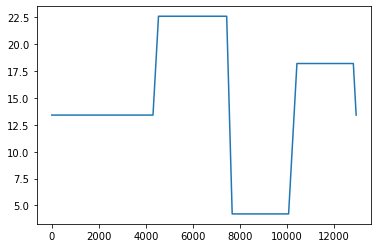

In [4]:
import numpy as np
import matplotlib.pyplot as plt

dt = 0.0166666666666667
#dt = 0.04
duration = 1200
m2m = 1/2.2369
v0 = 30*m2m*np.ones(4300)
for i in range(230):
    v0 = np.append(v0, v0[-1]+1*dt*(0.04/dt))
v0 = np.append(v0, v0[-1]*np.ones(duration*2+500))
for i in range(230):
    v0 = np.append(v0, v0[-1]-2*dt*(0.04/dt))
v0 = np.append(v0, v0[-1]*np.ones(duration*2))
for i in range(350):
    v0 = np.append(v0, v0[-1]+1*dt*(0.04/dt))
v0 = np.append(v0, v0[-1]*np.ones(duration*2))
for i in range(120):
    v0 = np.append(v0, v0[-1]-1*dt*(0.04/dt))
''' 
v0 = np.append(v0, v0[-1]*np.ones(duration*2))
for i in range(230):
    v0 = np.append(v0, v0[-1]+1*dt*(0.04/dt))
v0 = np.append(v0, v0[-1]*np.ones(duration*2+500))
for i in range(230):
    v0 = np.append(v0, v0[-1]-2*dt*(0.04/dt))
v0 = np.append(v0, v0[-1]*np.ones(duration*2))
for i in range(350):
    v0 = np.append(v0, v0[-1]+1*dt*(0.04/dt))
v0 = np.append(v0, v0[-1]*np.ones(duration*2))
for i in range(120):
    v0 = np.append(v0, v0[-1]-1*dt*(0.04/dt))

v0 = np.append(v0, v0[-1]*np.ones(duration*2))
for i in range(230):
    v0 = np.append(v0, v0[-1]+1*dt*(0.04/dt))
v0 = np.append(v0, v0[-1]*np.ones(duration*2+500))
for i in range(230):
    v0 = np.append(v0, v0[-1]-2*dt*(0.04/dt))
v0 = np.append(v0, v0[-1]*np.ones(duration*2))
for i in range(350):
    v0 = np.append(v0, v0[-1]+1*dt*(0.04/dt))

v0 = np.append(v0, v0[-1]*np.ones(duration*3))
''' 
plt.plot(v0)

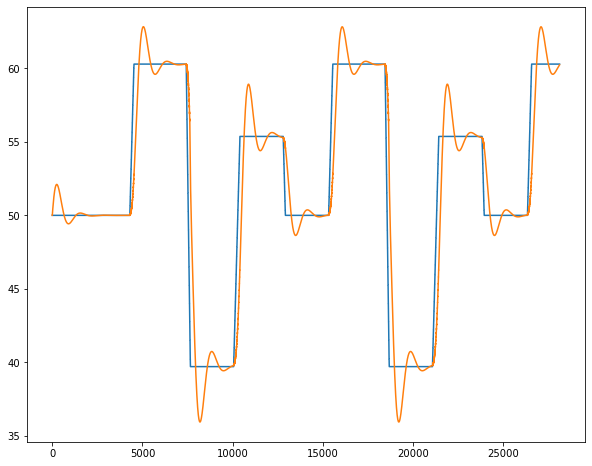

In [2]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.plot((speed[0:step,0])/m2m)
plt.plot((speed[0:step,1])/m2m)
#plt.plot((speed_record[0:step,1]))

In [4]:
step*dt/60

10.019166666666687

In [3]:
traci.vehicle.getSpeed("ego")

22.477843202830044

## NA

In [1]:
import os, sys, socket, re, json, random
import numpy as np
import matplotlib.pyplot as plt

if 'SUMO_HOME' in os.environ:
    tools = os.path.join(os.environ['SUMO_HOME'], 'tools')
    sys.path.append(tools)
else:
    sys.exit("please declare environment variable 'SUMO_HOME'")

#sumoBinary = os.path.join(os.environ['SUMO_HOME'], 'bin/sumo-gui')
#sumoCmd = [sumoBinary, "-c", "longhighway.sumo.cfg", "--start"]

import traci
import sumolib
from sumolib import checkBinary
import sumolib.net
from sumolib.net import readNet
from sumolib.net import Net
from sumolib.net import NetReader
from sumolib.net import lane
from sumolib.net import edge
from sumolib.net import node 
from sumolib.net import connection
from sumolib.net import roundabout
from sumolib.net.edge import Edge

##################### Lead Traj ########################
dt = 1/60
duration = 2000
m2m = 1/2.2369
v18na = np.loadtxt('na_speed_18mph.txt')
a18na = np.diff(v18na)/0.1
a18na = np.append(0,a18na)
for i in range(len(a18na)):
    if a18na[i]>5:
        a18na[i] = 5
    elif a18na[i]<-6:
        a18na[i] = -6
        
#plt.plot(a18na)
v18new = np.zeros(a18na.shape)
v18new[0] = v18na[0]
for i in range(1,len(v18new)):
    v18new[i] = v18new[i-1] + 0.1*a18na[i]*1.3
v18new = v18new/m2m-14
for i in range(1,len(v18new)):
    if v18new[i]<0:
        v18new[i] = 0
v0 = v18new

x = np.linspace(0, v0.shape[0], v0.shape[0])
x1 = np.linspace(0, v0.shape[0], v0.shape[0]*6)
from scipy.interpolate import interp1d
vinterp = interp1d(x, v0)
v01 = vinterp(x1)
########################## Parameters of platoon ##########################
N_lane_0, N_lane_1, N_lane_2, N_behind = 0, 0, 2, 3

N_VEHICLES = N_lane_0 + N_lane_1 + N_lane_2

lead_v = v01
lead_a = np.diff(lead_v)/dt
lead_a = np.append(0, lead_a)

# used to randomly color the vehicles
random.seed(1)
step = 0

max_iter = len(lead_a)//3
#max_iter = 2
#print(max_iter)

position = np.zeros((max_iter+1, N_VEHICLES))
pos_ego = np.zeros((max_iter+1,))
speed = np.zeros((max_iter+1, N_VEHICLES))
speed_record = np.zeros((max_iter+1, N_VEHICLES))
accel = np.zeros((max_iter+1, N_VEHICLES))
light = np.zeros((max_iter+1, N_VEHICLES))

def EIDM(spacing, v, v0, s0=3, a0=1.8, b0=2.8, T=1, sigma=4, Kf=1, Kg=0.6, *cv_arg):

    cv_arg = cv_arg[0]
    CAV_count = len(cv_arg)//2
    temp_v, temp_a = 0, 0
    alpha, beta = np.zeros((1,CAV_count)), np.zeros((1,CAV_count))
    if CAV_count > 0:
        for i in range(CAV_count):
            alpha[i] = 0.3/(0.3+np.exp(i))
            beta[i] = 0.3/(0.3+np.exp(i))
            temp_v += alpha[i]*cv_arg[2*i]
            temp_a += beta[i]*cv_arg[2*i+1]
        #s_star = s0 + v*T - v*alpha[0]*cv_arg[0]/(2*np.sqrt(a0*b0))
        s_star = s0 + v*T - v*cv_arg[0]/(2*np.sqrt(a0*b0))
    else:
        print('Error because no CAV speed and acceleration input!')
    a_free = a0*(1-(v/v0)**sigma)
    a_int = -a0*(s_star/spacing)**2
    acc = a_free + a_int
    
    return Kf*acc + Kg*(temp_v + temp_a)

def acc_linear(h, v, space, rel_v, rel_a, ks, kv, ka):
    return ks*(space-h*v) + kv*rel_v + ka*rel_a

s0=2.5
a0=1
b0=2
T=2.6
sigma=4
Kf=1
Kg=0

length = 5
spd = lead_v[0]
v0 = 33
dis = (s0+spd*T)/np.sqrt(1-(spd/v0)**sigma)


# 50mph SU
h = 0.9
ks, kv, ka = 5, 5, 2
dis = spd*h + 5
#dis = 45
#########################################################################

graph = sumolib.net.readNet('LLC.net.xml', withInternal=True) #internal edge are edges inside interseciton or connections 
vertex = graph.getNodes()
edge = graph.getEdges(withInternal=True)
#print('edge length:')
#print(len(edge))

sumoCmd = [sumolib.checkBinary('sumo-gui'), '-c', 'LLC_SUMO_no.sumo.cfg']
traci.start(sumoCmd)
step = 0

traci.route.add(routeID = 'route1', edges = ['-17.0.00'])
#traci.vehicle.add('ego', "route")
traci.vehicle.add('ego', "route1", departPos=str(500), departSpeed=str(spd), departLane = str(2), typeID="vtypeauto")
traci.vehicle.setColor('ego', color=(255, 0, 0, 255))
traci.vehicle.setLaneChangeMode('ego', 256)

#UDP_IP = "192.168.0.11"
UDP_IP = "192.168.0.181"
UDP_PORT = 23333

'''
serverSock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
serverSock.bind((UDP_IP, UDP_PORT))

data, address = serverSock.recvfrom(1024*6)
data = data.decode('utf-8').split("$")[0]
y, x, z, vx, vy = data.split(";")
#x, y = '6448.97', '-6645.57'
X_offset, Y_offset = 0, 0      #10273, 1000.5  #882.504, 846.15
x, y, z = X_offset+float(x.replace("\x00", "")), Y_offset+float(y.replace("\x00", "")), float(z.replace("\x00", ""))*180/3.14159265
vx, vy = float(vx.replace("\x00", "")), float(vy.replace("\x00", ""))
eEdge = traci.vehicle.getRoadID('ego')
ePos = traci.vehicle.getPosition('ego')
traci.vehicle.moveToXY('ego', '', 0, x, y, angle=z, keepRoute=2)
'''

traci.simulationStep()
eLanePos = traci.vehicle.getLanePosition('ego')
print(eLanePos)

def dis_ego(vID_tmp):
	posi = traci.vehicle.getPosition(vID_tmp)
	dis = ((ePos[0] - posi[0])**2 + (ePos[1] - posi[1])**2)**(1/2)
	return dis
	
while step<=max_iter:
	'''
	data, address = serverSock.recvfrom(1024*6)
	data = data.decode('utf-8').split("$")[0]
	y, x, z, vx, vy = data.split(";")
	#x, y = '6448.97', '-6645.57'
	X_offset, Y_offset = 0, 0      #10273, 1000.5  #882.504, 846.15
	x, y, z = X_offset+float(x.replace("\x00", "")), Y_offset+float(y.replace("\x00", "")), float(z.replace("\x00", ""))*180/3.14159265
	vx, vy = float(vx.replace("\x00", "")), float(vy.replace("\x00", ""))
	eEdge = traci.vehicle.getRoadID('ego')
	ePos = traci.vehicle.getPosition('ego')
	traci.vehicle.moveToXY('ego', '', 0, x, y, angle=z, keepRoute=2)
	traci.vehicle.setSpeed('ego', 0.0)
	eLanePos = traci.vehicle.getLanePosition('ego')
	#print(eLanePos)
	pos_ego[step] = eLanePos
	'''
	eLanePos = traci.vehicle.getLanePosition('ego')
	#print(eLanePos)
	if step==0:
		for i in range(N_VEHICLES):
			position[0, i] = eLanePos + (N_lane_0+N_lane_1+N_lane_2-i)*dis
			speed[0, i] = spd
			accel[0, i] = 0
			vid = "%d" % i
			traci.vehicle.add(vid, "route1", departPos=str(position[0, i]), departSpeed=str(spd), departLane = str(2), typeID="vtypeauto")
			traci.vehicle.setColor(vid, (random.uniform(0, 255), random.uniform(0, 255), random.uniform(0, 255), 255))
			traci.vehicle.setLaneChangeMode(vid, 256)
			speed_record[step,i] = spd
			traci.gui.trackVehicle("View #0", "%d" % i)
			traci.gui.setZoom("View #0", 3500)
			
	elif step>=1:
		if True:
			#dt = 1
			space = position[step, N_lane_0 + N_lane_1 + N_lane_2 - 1] - traci.vehicle.getLanePosition('ego')
			rel_v = speed[step, N_lane_0 + N_lane_1 + N_lane_2 - 1] - traci.vehicle.getSpeed('ego')
			rel_acc = accel[step, N_lane_0 + N_lane_1 + N_lane_2 - 1] - traci.vehicle.getAcceleration('ego')
			#acceleration = EIDM(space, traci.vehicle.getSpeed('ego'), v0, s0, a0, b0, T, sigma, Kf, Kg, (rel_v,rel_acc))
			acceleration = acc_linear(h, traci.vehicle.getSpeed('ego'), space, rel_v, rel_acc, ks, kv, ka)
			traci.vehicle.setSpeed('ego', traci.vehicle.getSpeed('ego') + acceleration*dt)
            
			for i in range(N_VEHICLES):
				if i == 0:
					#traci.vehicle.setSpeed("v.%d" % i, lead_v[step//10])
					traci.vehicle.setSpeed("%d" % i, speed[step,i] + lead_a[step//1]*dt)
					Pos = position[step,i] + speed[step,i]*dt + 0.5*lead_a[step+1]*(dt**2)
					#traci.vehicle.moveTo("%d" % i, '-17.0.00_2', Pos) 
					if lead_a[step//1]<0:
						traci.vehicle.setSignals("%d" % i, 3)
				else:
					space = position[step,i-1] - position[step,i]
					v = speed[step,i]
					rel_v = speed[step,i-1] - speed[step,i]
					rel_acc = accel[step,i-1] - accel[step,i]
					#acceleration = EIDM(space, v, v0, s0, a0, b0, T, sigma, Kf, Kg, (rel_v,rel_acc))
					acceleration = acc_linear(h, v, space, rel_v, rel_acc, ks, kv, ka)
					Pos = position[step,i] + speed[step,i]*dt + 0.5*acceleration*(dt**2)
					#traci.vehicle.moveTo("%d" % i, '-17.0.00_2', Pos)       
					traci.vehicle.setSpeed("%d" % i, speed[step,i] + acceleration*dt)
					speed_record[step,i] = speed[step,i] + acceleration*dt
	#print(traci.vehicle.getPosition('ego'))
	#print(traci.vehicle.getLanePosition('ego'))
					
	'''
	Message=''
	Message =  "0" + "," + "0" + "," + Message
	for k in range(N_VEHICLES):
		vID = str(k)
		
		Position = traci.vehicle.getPosition(vID)
		sig = light[step,k]      #traci.vehicle.getSignals(vID)
		vel = traci.vehicle.getSpeed(vID)

		#if (Position[0]-x)**2 + (Position[1]-y)**2 > 90000:
		#		continue
		Message += str(vID)+","

		#xx = "{0:.3f}".format(position[0]-x) 
		xx = "{0:.3f}".format(Position[0]-X_offset) 

		#yy = "{0:.3f}".format(position[1]-y) 
		yy = "{0:.3f}".format(Position[1]-Y_offset) 

		Message += xx + "," + yy +","
		#print(vID,Position[0],Position[1])
		#print(vID,xx,yy)
		angle = traci.vehicle.getAngle(vID)
		angle = "{0:.3f}".format(angle) 
		Message += angle + ","
		
		Message +=  str(sig) + "," + str(vel) + ","

	Message = Message[:-1]
	#print(repr(Message))
	serverSock.sendto(Message.encode('utf-8'), (address[0], 23334))
	'''
	step += 1
	traci.simulationStep()
    
	for i in range(N_VEHICLES):
		position[step,i] = traci.vehicle.getLanePosition("%d" % i)
		if step==0:
			speed[step,i] = spd
			accel[step,i] = 0
		else:
			speed[step,i] = traci.vehicle.getSpeed("%d" % i)
			#speed[step,i] = (position[step,i]-position[step-1,i])/dt
			accel[step,i] = traci.vehicle.getAcceleration("%d" % i)
			#accel[step,i] = (speed[step,i]-speed[step-1,i])/dt
		#light[step,i] = traci.vehicle.getSignals("v.%d" % i)
	
	#plt.plot(speed[max(0,step-1000):step,N_lane_0 + N_lane_1])
	#print(traci.vehicle.getSpeed(str(N_lane_0 + N_lane_1)))
	if step >= max_iter-1:
		np.savetxt('./run_pos_trapz50mph_su.txt', position);
		np.savetxt('./run_vel_trapz50mph_su.txt', speed);
		np.savetxt('./run_accel_trapz50mph_su.txt', accel);
		break

traci.close()

500.0


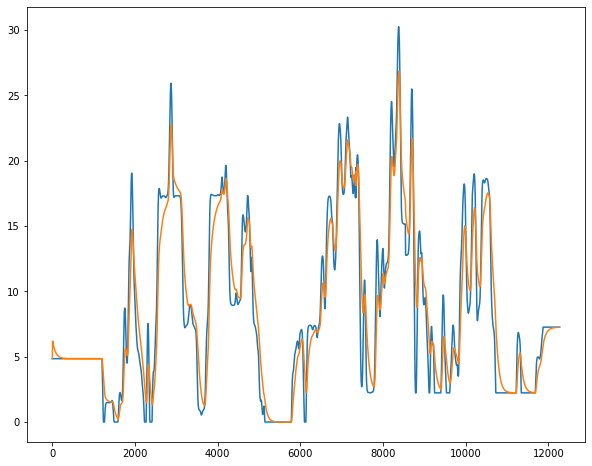

In [2]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.plot((speed[0:step,0])/m2m)
plt.plot((speed[0:step,1])/m2m)

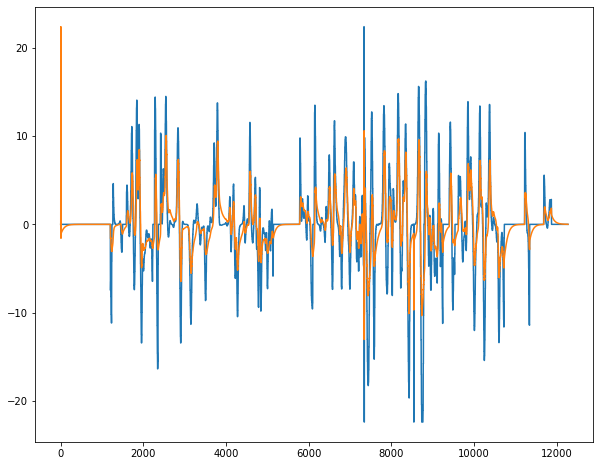

In [3]:
plt.figure(figsize=(10,8))
plt.plot((accel[0:step,0])/m2m)
plt.plot((accel[0:step,1])/m2m)

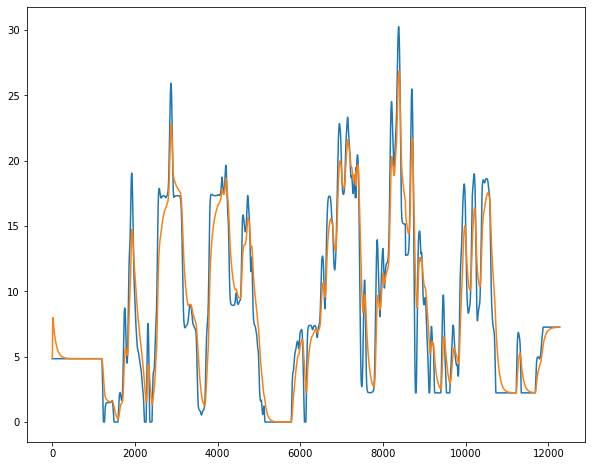

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.plot((speed[0:step,0])/m2m)
plt.plot((speed[0:step,1])/m2m)

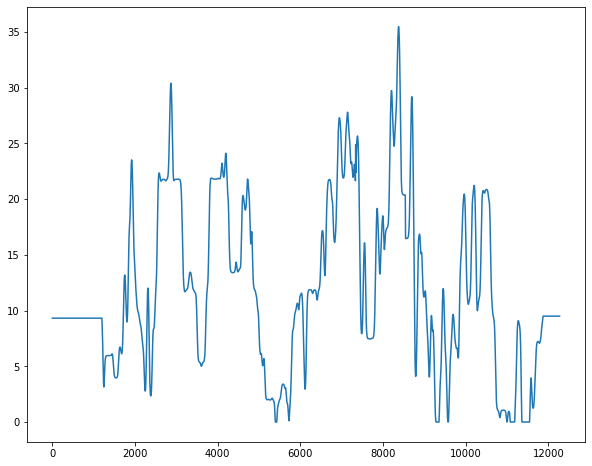

In [6]:
plt.figure(figsize=(10,8))
plt.plot(lead_v[0:step//3]/m2m)